<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/UK/RDSA/RDSA_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "RDSBGBGBX"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-07-25 05:17:36,562 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-07-25 05:17:36,564 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for RDSBGBGBX
2019-07-25 05:18:35,637 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-07-25 05:20:33,610 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-07-25 05:21:34,186 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-07-25 05:22:31,778 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-07-25 05:23:35,247 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-07-25 05:24:35,321 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-07-25 05:25:37,398 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-07-25 05:26:42,416 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-07-25 05:30:16,334 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_RDSBGBGBX__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-RDSBGBGBX__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-RDSBGBGBX to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open       High        Low      Close    Volume
Date                                                                     
2018-01-02 08:00:00  25.004971  25.004971  24.784969  24.859980  0.498269
2018-01-02 09:00:00  24.854980  25.029980  24.829969  25.029970  0.999567
2018-01-02 10:00:00  25.029980  25.044979  24.944969  24.959970  0.943823
2018-01-02 11:00:00  24.959980  24.994980  24.934971  24.994980  0.795009
2018-01-02 12:00:00  24.994970  25.004980  24.949970  24.964970  0.569445
...                        ...        ...        ...        ...       ...
2018-12-31 08:00:00  23.349970  23.389980  23.209970  23.344971  0.702117
2018-12-31 09:00:00  23.344980  23.469980  23.294970  23.459980  0.666507
2018-12-31 10:00:00  23.459970  23.524981  23.449970  23.504971  0.599672
2018-12-31 11:00:00  23.499969  23.514980  23.314970  23.324980  0.730618
2018-12-31 12:00:00  23.324970  23.374981  23.299971  23.309971  0.526979

[2257 rows x 5 columns]

Open         High          Low        Close       Volume
count  2257.000000  2257.000000  2257.000000  2257.000000  2257.000000
mean     25.193155    25.263521    25.125668    25.195745     1.481361
std       1.538035     1.539311     1.538692     1.540363     0.896452
min      21.999981    22.034981    21.934971    21.994970     0.195039
25%      23.939970    24.019979    23.824970    23.934971     0.881005
50%      25.479980    25.544979    25.399969    25.484980     1.206775
75%      26.484970    26.549980    26.404970    26.489981     1.863210
max      28.404980    28.439980    28.364969    28.424980     8.105173

25

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open       High        Low      Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08      SMA_8     TEMA_8    TRIMA_8      WMA_8     MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  25.729971  25.754971  25.704969  25.709980  0.812909    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  25.679487  25.328382  25.559866  25.707496  25.665812  25.602915   25.659975   25.649970  25.572683  25.648100  25.721698  25.644225  25.674976  25.648100  25.716643  25.596646               25.764608                25.648100               25.531591               25.822863                25.648100               25.473337               25.881117                25.648100               25.415083               25.939371                25.648100               25.356828  25.665812  25.705042  25.603398               25.782320                25.665812               25.549303               25.840575                25.665812               25.491049               25.898829                25.665812               25.432795               25.957083   
2018-01-09 14:00:00  25.709970  25.759979  25.624969  25.634979  2.180358    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  25.676788  25.338945  25.579377  25.686052  25.658960  25.603693   25.659975   25.652474  25.587266  25.654351  25.685748  25.664476  25.672061  25.654351  25.672480  25.604473               25.761642                25.654351               25.547060               25.815287                25.654351               25.493415               25.868933                25.654351               25.439769               25.922578                25.654351               25.386124  25.658960  25.660778  25.611576               25.766251                25.658960               25.551669               25.819897                25.658960               25.498024               25.873542                25.658960               25.444378               25.927188   
2018-01-09 15:00:00  25.629971  25.689980  25.619970  25.6

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000    2207.000000  2207.000000   2207.000000     2207.000000     2207.000000       2207.000000  2207.000000  2207.000000  2207.000000  2207.000000   2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000             2207.000000              2207.000000             2207.000000             2207.000000              2207.000000             2207.000000             2207.000000              2207.000000             2207.000000             2207.000000              2207.000000             2207.000000  2207.000000  2207.000000  2207.000000             2207.000000              2207.000000             2207.000000             2207.000000              2207.000000             2207.000000             2207.000000   
mean     25.188725    25.259598    25.120552    25.191149     1.485657    15.895333     2.038061   185.700952      30.419574    11.384232      0.034436        0.028092        0.002266          0.004078     6.609425     2.537381    26.976892     2.038061      1.975986    26.976892    25.196901    25.205392     1.916221    25.191061    25.194864    25.194597    25.191557    25.188535    25.185997    25.194802    25.191208    25.194797    25.193596    25.194802    25.192744    25.202615               25.411177                25.194802               24.978427               25.519365                25.194802               24.870239               25.627553                25.194802               24.762051               25.735740                25.194802               24.653864    25.194864    25.192186    25.201393               25.411239                25.194864               24.978488               25.519427                25.194864               24.870301               25.627614   
std       1.554617     1.555994     1.555176     1.556960     0.900984     8.583567     1.403080   102.265743       0.856280     2.616824      0.182387        0.165274        0.047554          0.063743     3.364615     1.107681    14.610349     1.403080      1.398375    14.610349     1.544175     1.521229    25.166051     1.559292     1.547716     1.543095     1.551364     1.549708     1.557299     1.550318     1.558215     1.551454     1.551666     1.550318     1.554932     1.536961                1.559100                 1.550318                1.551663                1.567242                 1.550318                1.556133                1.577839                 1.550318                1.563109                1.590840                 1.550318                1.572559     1.547716     1.554491     1.539020                1.556385                 1.547716                1.549191                1.564479                 1.547716                1.553731                1.575032   
min      21.999981    22.034981    21.9349

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.582356  0.580795  0.586314  0.577761  0.078111    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.576900  0.524916  0.951909  0.576802  0.573300  0.567445    0.572677    0.572460  0.559217  0.570112  0.580890  0.568590  0.574016  0.570112  0.579605  0.565167                0.551328                 0.570112                0.573382                0.531388                 0.570112                0.578900                0.511066                 0.570112                0.584573                0.492303                 0.570112                0.590774  0.573300  0.577903  0.565268                0.560044                 0.573300                0.582859                0.540001                 0.573300                0.588937                0.518942                 0.573300                0.595159                0.499100                 0.573300   
2018-01-09 14:00:00  0.579233  0.581577  0.573872  0.566097  0.250984    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.576466  0.526696  0.952253  0.573473  0.572205  0.567571    0.572677    0.572863  0.561459  0.571103  0.575330  0.571783  0.573555  0.571103  0.572711  0.566451                0.550876                 0.571103                0.575811                0.530282                 0.571103                0.582008                0.509360                 0.571103                0.588339                0.490047                 0.571103                0.595172  0.572205  0.570976  0.566604                0.557553                 0.572205                0.583231                0.536923                 0.572205                0.590017                0.515338                 0.572205                0.596924                0.495018                 0.572205   
2018-01-09 15:00:00  0.566743  0.570648  

52

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         5 hours 59 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_mysi7r
H2O cluster total nodes:    1
H2O cluster free memory:    8.35 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.757635  0.598160              0.323933  0.452727  0.204962
1  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.746059  0.615776              0.337315  0.461381  0.212873
2  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.737274  0.727005              0.282389  0.479654  0.230068
3  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.725862  0.631131              0.320977  0.470653  0.221514
4  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.715271  0.896364              0.330952  0.517839  0.268157
5  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.713300  0.659309              0.325739  0.483252  0.233533
6              DeepLearning_1_AutoML_20190725_053842  0.684154  0.671105              0.340476  0.489273  0.239388
7  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.662644  3.054379              0.389491  0.585364  0.342651
8  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.621552  0.669612              0.386782  0.488767  0.238893
9  DeepLearning_grid_1_AutoML_20190725_053842_mod...  0.503448  0.720687              0.450082  0.513373  0.263552

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.003937
1           CDLCLOSINGMARUBOZU             0.609404           0.609404    0.002399
2                  CDLLONGLINE             0.586257           0.586257    0.002308
3                          SUB             0.581585           0.581585    0.002290
4                          DIV             0.543759           0.543759    0.002141
...                        ...                  ...                ...         ...
1030                   MA_14_0             0.210647           0.210647    0.000829
1031    BBANDS_upperband_8_7_2             0.210240           0.210240    0.000828
1032  BBANDS_middleband_24_5_4             0.209610           0.209610    0.000825
1033                    TSF_24             0.209288           0.209288    0.000824
1034   BBANDS_middleband_8_3_2             0.206343           0.206343    0.000812

[1035 rows x 4 columns]

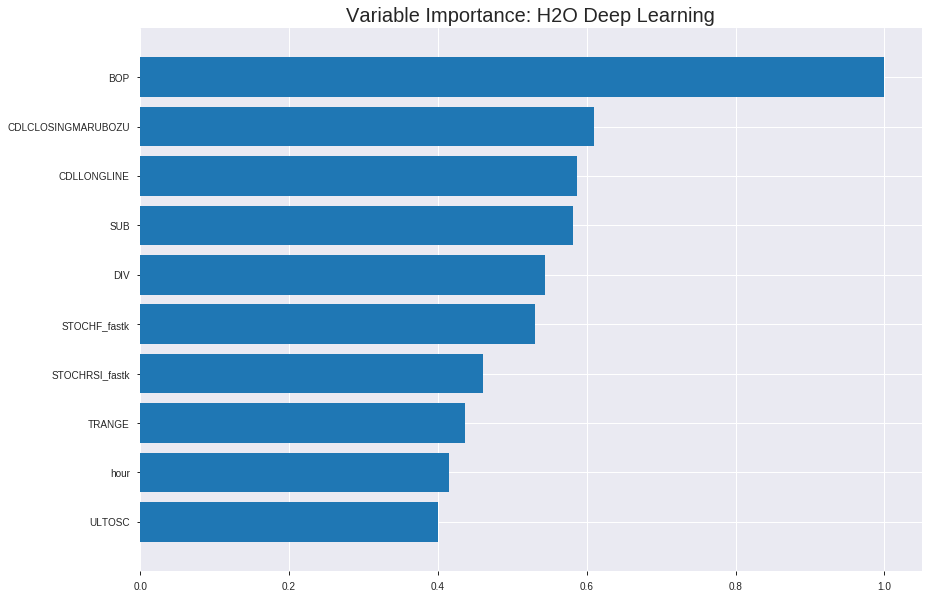

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_053842_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19703678078325446
RMSE: 0.4438882525853263
LogLoss: 0.5772066504096723
Mean Per-Class Error: 0.301778583173932
AUC: 0.7686214302493373
pr_auc: 0.7549824811026293
Gini: 0.5372428604986745
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37993365095433235: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      342  428   0.5558   (428.0/770.0)
1      82   692   0.1059   (82.0/774.0)
Total  424  1120  0.3303   (510.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379934     0.730729  261
max f2                       0.216395     0.848567  325
max f0point5                 0.65047      0.705864  140
max accuracy                 0.581525     0.698187  173
max precision                0.963639     1         0
max recall                   0.0398046    1         391
max specificity              0.963639     1         0
max absolute_mcc             0.465162     0.399208  227
max min_per_class_accuracy   0.574366     0.68961   178
max mean_per_class_accuracy  0.581525     0.698221  173

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 53.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.929213           1.87016   1.87016            0.9375           0.944143  0.9375                      0.944143            0.0193798       0.0193798                  87.0155   87.0155
    2        0.0200777                   0.909264           1.72885   1.80178            0.866667         0.920482  0.903226                    0.932694            0.0167959       0.0361757                  72.8854   80.1784
    3        0.0304404                   0.888302           1.74548   1.78262            0.875            0.897788  0.893617                    0.920811            0.0180879       0.0542636                  74.5478   78.2616
    4        0.0401554                   0.874212           1.86184   1.80178            0.933333         0.881104  0.903226                    0.911205            0.0180879       0.0723514                  86.1843   80.1784
    5        0.0505181                   0.860063           1.99483   1.84138            1                0.867059  0.923077                    0.902149            0.0206718       0.0930233                  99.4832   84.1383
    6        0.100389                    0.821238           1.65804   1.7503             0.831169         0.84045   0.877419                    0.871499            0.0826873       0.175711                   65.8042   75.0304
    7        0.150259                    0.782493           1.55441   1.68529            0.779221         0.800877  0.844828                    0.84806             0.0775194       0.25323                    55.4415   68.5289
    8        0.20013                     0.752907           1.42488   1.6204             0.714286         0.76664   0.812298                    0.827771            0.0710594       0.324289                   42.488    62.0398
    9        0.29987                     0.696494           1.43783   1.55967            0.720779         0.724291  0.781857                    0.793352            0.143411        0.4677                     43.7833   55.9674
    10       0.400259                    0.640878           1.23551   1.47837            0.619355         0.668783  0.7411                      0.762109            0.124031        0.591731                   23.5509   47.8371
    11       0.5                         0.5744             0.984463  1.37984            0.493506         0.60584   0.69171                     0.730936            0.0981912       0.689922                   -1.55374  37.9845
    12       0.599741                    0.495111           0.984463  1.31409            0.493506         0.538965  0.658747                    0.69901             0.0981912       0.788114                   -1.55374  31.409
    13       0.70013                     0.399113           0.772193  1.23639            0.387097         0.449691  0.619796                    0.663261            0.0775194       0.865633                   -22.7807  23.639
    14       0.79987                     0.288526           0.725393  1.17267            0.363636         0.347992  0.587854                    0.623948            0.0723514       0.937984                   -27.4607  17.267
    15       0.899611                    0.169759           0.414511  1.08861            0.207792         0.231783  0.545716                    0.580468            0.0413437       0.979328                   -58.5489  8.86124
    16       1                           0.00646469         0.205918  1                  0.103226         0.100453  0.501295                    0.53228             



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19865516731950109
RMSE: 0.44570749075991656
LogLoss: 0.5791379983644496
Mean Per-Class Error: 0.2935890557939914
AUC: 0.7667031198415319
pr_auc: 0.7431494309729991
Gini: 0.5334062396830639
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4973660672606683: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      138  95   0.4077   (95.0/233.0)
1      41   167  0.1971   (41.0/208.0)
Total  179  262  0.3084   (136.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497366     0.710638  235
max f2                       0.263056     0.840966  333
max f0point5                 0.625407     0.699761  138
max accuracy                 0.577081     0.707483  182
max precision                0.915905     1         0
max recall                   0.0721728    1         385
max specificity              0.915905     1         0
max absolute_mcc             0.57475      0.412933  184
max min_per_class_accuracy   0.56962      0.697115  189
max mean_per_class_accuracy  0.57475      0.706411  184

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.900576           2.12019   2.12019            1                0.912682   1                           0.912682            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.868679           2.12019   2.12019            1                0.879396   1                           0.897888            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.853975           1.69615   1.96875            0.8              0.865396   0.928571                    0.886284            0.0192308       0.0625                     69.6154   96.875
    4        0.0408163                   0.816371           2.12019   2.0024             1                0.824705   0.944444                    0.8726              0.0192308       0.0817308                  112.019   100.24
    5        0.0521542                   0.803916           2.12019   2.02801            1                0.81065    0.956522                    0.859132            0.0240385       0.105769                   112.019   102.801
    6        0.102041                    0.751544           1.83108   1.93173            0.863636         0.774726   0.911111                    0.817867            0.0913462       0.197115                   83.1075   93.1731
    7        0.151927                    0.725058           1.25284   1.70881            0.590909         0.734121   0.80597                     0.790368            0.0625          0.259615                   25.2841   70.8812
    8        0.201814                    0.703882           1.34921   1.61992            0.636364         0.713176   0.764045                    0.771287            0.0673077       0.326923                   34.9213   61.9922
    9        0.301587                    0.650978           1.54196   1.59413            0.727273         0.674327   0.75188                     0.73921             0.153846        0.480769                   54.1958   59.413
    10       0.401361                    0.601211           1.15647   1.48533            0.545455         0.626228   0.700565                    0.711124            0.115385        0.596154                   15.6469   48.5332
    11       0.501134                    0.547241           1.15647   1.41986            0.545455         0.580634   0.669683                    0.685144            0.115385        0.711538                   15.6469   41.9857
    12       0.600907                    0.494124           0.915538  1.33612            0.431818         0.520859   0.630189                    0.657867            0.0913462       0.802885                   -8.44624  33.6121
    13       0.70068                     0.399094           0.674607  1.24192            0.318182         0.447799   0.585761                    0.627954            0.0673077       0.870192                   -32.5393  24.1925
    14       0.800454                    0.305197           0.722793  1.17722            0.340909         0.349981   0.555241                    0.593306            0.0721154       0.942308                   -27.7207  17.7217
    15       0.900227                    0.166392           0.337303  1.08413            0.159091         0.240353   0.511335                    0.554188            0.0336538       0.975962                   -66.2697  8.41286
    16       1                           0.00785283         0.240931  1                  0.113636         0.0882278  0.471655                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:40:29  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:40:32  1 min 48.903 sec  431 obs/sec       0.79728   1             1231       0.637123         4.90504             -0.623715      0.570463        0.500073           1.37145          0.498705                         0.619951           2.36481               -0.542316        0.622617          0.563851             1.69615            0.439909
    2019-07-25 05:40:45  2 min  1.960 sec  428 obs/sec       4.08873   5             6313       0.529883         0.953069            -0.12311       0.632658        0.651487           1.49612          0.489637                         0.483435           0.669837              0.0621472        0.667805          0.634258             2.12019            0.428571
    2019-07-25 05:40:58  2 min 14.650 sec  433 obs/sec       7.3342    9             11324      0.443888         0.577207            0.211848       0.768621        0.754982           1.87016          0.330311                         0.445707           0.579138              0.202817         0.766703          0.743149             2.12019            0.30839
    2019-07-25 05:41:13  2 min 29.814 sec  440 obs/sec       11.4074   14            17613      0.459379         0.614102            0.155877       0.76337         0.745533           1.87016          0.305699                         0.463075           0.614716              0.139482         0.752187          0.727033             2.12019            0.321995
    2019-07-25 05:41:28  2 min 44.535 sec  448 obs/sec       15.4942   19            23923      0.476169         0.648112            0.0930467      0.701482        0.671351           1.37145          0.393782                         0.459178           0.608268              0.153903         0.722             0.684178             2.12019            0.342404
    2019-07-25 05:41:42  2 min 59.080 sec  453 obs/sec       19.5628   24            30205      0.439246         0.566488            0.228245       0.78013         0.763597           1.74548          0.342617                         0.458999           0.60588               0.154561         0.739043          0.717117             2.12019            0.31746
    2019-07-25 05:41:58  3 min 14.491 sec  452 obs/sec       23.6632   29            36536      0.457401         0.621532            0.163132       0.753191        0.73609            1.87016          0.33614                          0.466985           0.653363              0.124889         0.73113           0.694285             2.12019            0.335601
    2019-07-25 05:42:12  3 min 28.442 sec  459 obs/sec       27.7526   34            42850      0.473303         0.6567              0.103932       0.728311        0.735747           1.99483          0.388601                         0.469018           0.639587              0.117251         0.721123          0.690727             2.12019            0.365079
    2019-07-25 05:42:13  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.003936917575271772
CDLCLOSINGMARUBOZU        0.6094040870666504     0.6094040870666504   0.002399173660815145
CDLLONGLINE               0.5862571597099304     0.5862571597099304   0.002308046115690935
SUB                       0.5815845727920532     0.5815845727920532   0.0022896505261319595
DIV                       0.5437592267990112     0.5437592267990112   0.0021407352567012167
---                       ---                    ---                  ---
MA_14_0                   0.21064719557762146    0.21064719557762146  0.0008293006464512482
BBANDS_upperband_8_7_2    0.21024015545845032    0.21024015545845032  0.0008276981630522426
BBANDS_middleband_24_5_4  0.2096095085144043     0.2096095085144043   0.0008252153580144364
TSF_24                    0.20928779244422913    0.20928779244422913  0.0008239487883635164
BBANDS_middleband_8_3_2   0.20634250342845917    0.20634250342845917  0.0008123534282730768


See the whole table with table.as_data_frame()


('accuracy', 0.7149321266968326)

('F1', 0.7175572519083969)

('auc', 0.7576354679802956)

('logloss', 0.5981602136550186)

('mean_per_class_error', 0.28916256157635467)

('rmse', 0.4527273130002804)

('mse', 0.20496201993645388)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


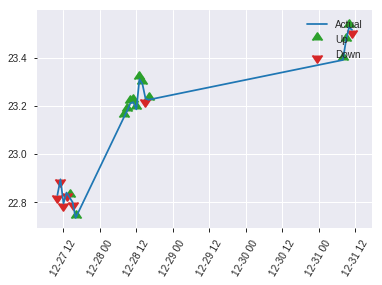


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20496201993645388
RMSE: 0.4527273130002804
LogLoss: 0.5981602136550186
Mean Per-Class Error: 0.28916256157635467
AUC: 0.7576354679802956
pr_auc: 0.7022373492267864
Gini: 0.5152709359605911
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4194735449000287: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   63   0.5431   (63.0/116.0)
1      11   94   0.1048   (11.0/105.0)
Total  64   157  0.3348   (74.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419474     0.717557  156
max f2                       0.189623     0.830645  199
max f0point5                 0.612024     0.709677  89
max accuracy                 0.612024     0.714932  89
max precision                0.929786     1         0
max recall                   0.0840851    1         213
max specificity              0.929786     1         0
max absolute_mcc             0.612024     0.428592  89
max min_per_class_accuracy   0.569929     0.689655  108
max mean_per_class_accuracy  0.612024     0.710837  89

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 53.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.923332           2.10476   2.10476            1                0.927501  1                           0.927501            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.874161           1.05238   1.68381            0.5              0.896686  0.8                         0.915175            0.00952381      0.0380952                  5.2381    68.381
    3        0.0316742                   0.860767           2.10476   1.80408            1                0.86438   0.857143                    0.900662            0.0190476       0.0571429                  110.476   80.4082
    4        0.040724                    0.846866           0         1.40317            0                0.854447  0.666667                    0.890392            0               0.0571429                  -100      40.3175
    5        0.0542986                   0.840178           1.40317   1.40317            0.666667         0.843118  0.666667                    0.878574            0.0190476       0.0761905                  40.3175   40.3175
    6        0.104072                    0.789477           1.91342   1.6472             0.909091         0.805638  0.782609                    0.843691            0.0952381       0.171429                   91.342    64.7205
    7        0.153846                    0.76728            1.72208   1.67143            0.818182         0.775993  0.794118                    0.821789            0.0857143       0.257143                   72.2078   67.1429
    8        0.20362                     0.744391           1.53074   1.63704            0.727273         0.753971  0.777778                    0.805211            0.0761905       0.333333                   53.0736   63.7037
    9        0.303167                    0.687658           1.43506   1.57072            0.681818         0.712391  0.746269                    0.774733            0.142857        0.47619                    43.5065   57.0718
    10       0.402715                    0.612609           1.43506   1.53719            0.681818         0.656553  0.730337                    0.74552             0.142857        0.619048                   43.5065   53.7186
    11       0.502262                    0.568288           0.95671   1.42214            0.454545         0.589965  0.675676                    0.714689            0.0952381       0.714286                   -4.329    42.2136
    12       0.60181                     0.506557           0.95671   1.34515            0.454545         0.532634  0.639098                    0.684575            0.0952381       0.809524                   -4.329    34.5149
    13       0.701357                    0.431615           0.669697  1.24928            0.318182         0.469515  0.593548                    0.65405             0.0666667       0.87619                    -33.0303  24.9278
    14       0.800905                    0.319741           0.478355  1.15346            0.227273         0.370189  0.548023                    0.618768            0.047619        0.92381                    -52.1645  15.3457
    15       0.900452                    0.192061           0.478355  1.07882            0.227273         0.267075  0.512563                    0.579887            0.047619        0.971429                   -52.1645  7.88227
    16       1                           0.0268263          0.287013  1                  0.136364         0.115211  0.475113                    0.53363           

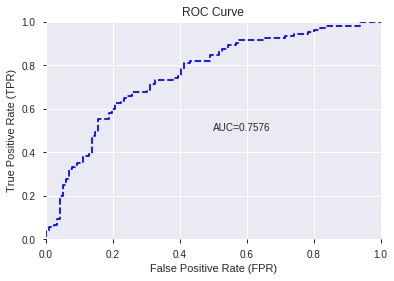

This function is available for GLM models only


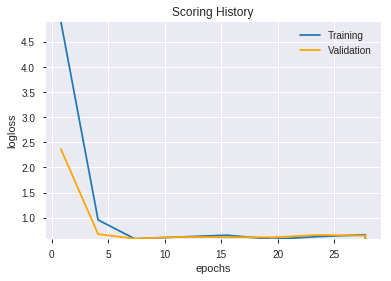

--2019-07-25 06:14:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


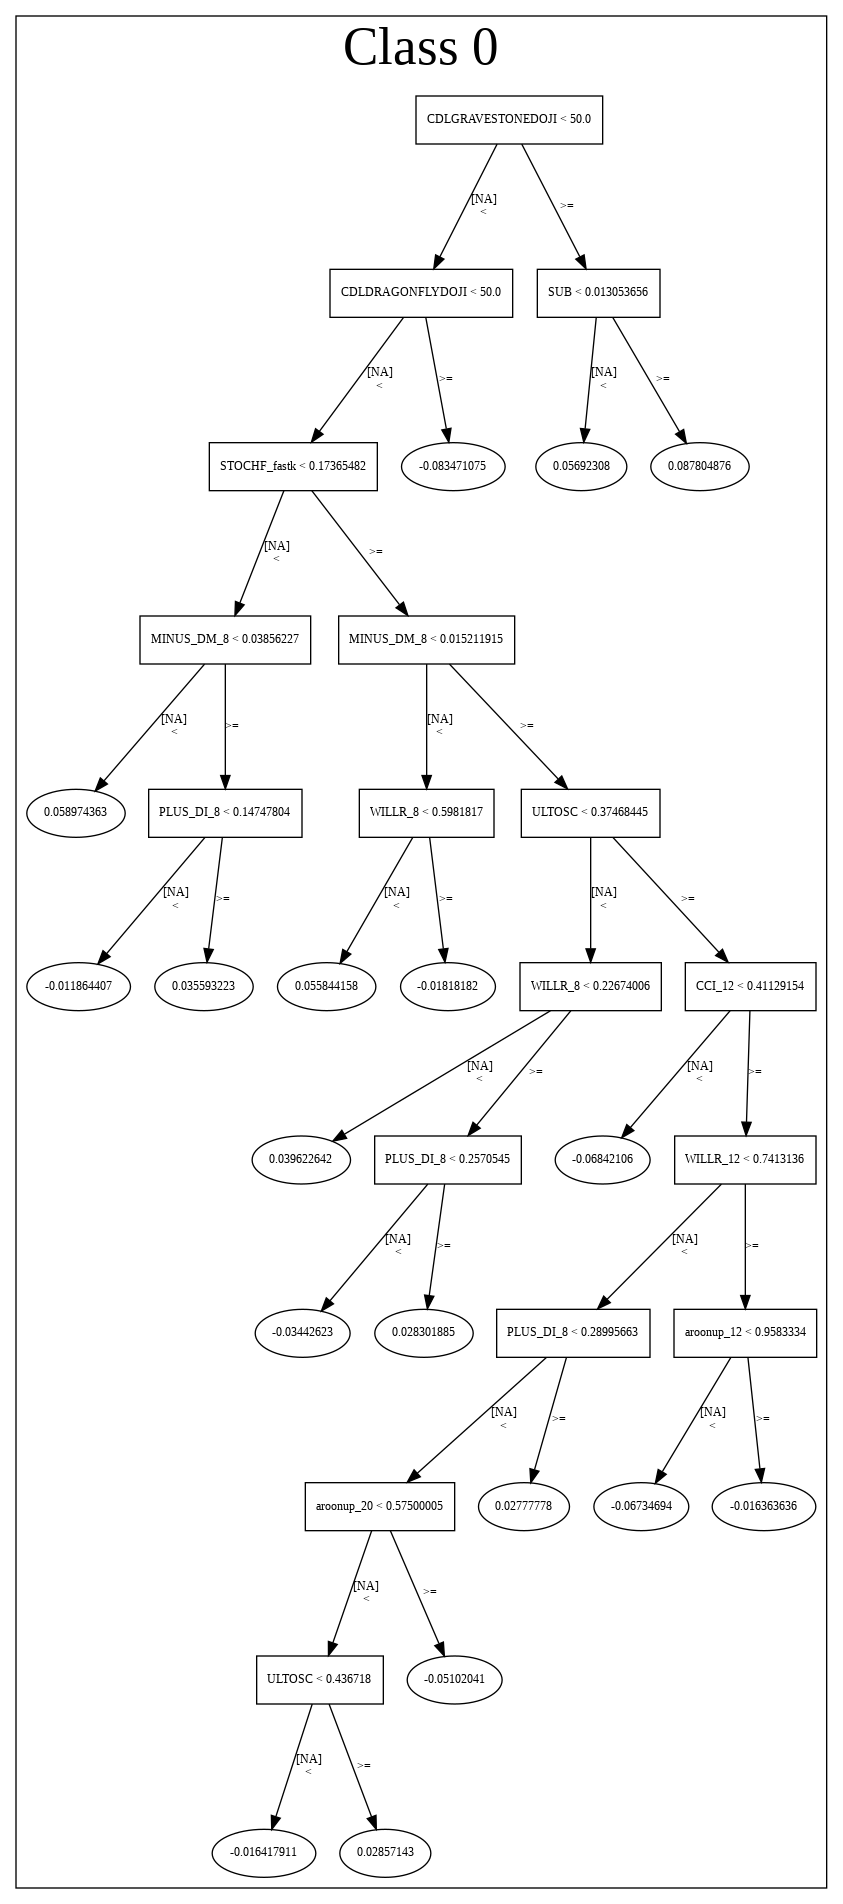

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_053842_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_053842_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [0]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_061450_model_6  0.761658  0.614483              0.296018  0.456513  0.208404
1  DeepLearning_grid_1_AutoML_20190725_061450_model_9  0.759770  0.587765              0.296470  0.447377  0.200146
2  DeepLearning_grid_1_AutoML_20190725_061450_model_8  0.756199  0.603994              0.304639  0.449743  0.202268
3  DeepLearning_grid_1_AutoML_20190725_061450_model_5  0.746059  0.625399              0.281034  0.461192  0.212698
4  DeepLearning_grid_1_AutoML_20190725_061450_model_3  0.741051  0.683921              0.325287  0.462118  0.213553
5  DeepLearning_grid_1_AutoML_20190725_061450_model_2  0.730870  0.707204              0.359319  0.473669  0.224362
6  DeepLearning_grid_1_AutoML_20190725_061450_model_4  0.730049  0.806684              0.327340  0.482571  0.232875
7  DeepLearning_grid_1_AutoML_20190725_061450_model_7  0.701396  0.938295              0.344335  0.516663  0.266940
8  DeepLearning_grid_1_AutoML_20190725_061450_model_1  0.700493  0.824537              0.350698  0.496428  0.246441
9               DeepLearning_1_AutoML_20190725_061450  0.695238  0.653744              0.330706  0.474423  0.225078

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.031192
1   CDLCLOSINGMARUBOZU             0.937043           0.937043    0.029229
2          CDLLONGLINE             0.883808           0.883808    0.027568
3                  DIV             0.723033           0.723033    0.022553
4               ULTOSC             0.709683           0.709683    0.022137
5         HT_TRENDMODE             0.701346           0.701346    0.021877
6               TRANGE             0.695283           0.695283    0.021687
7                  SUB             0.688942           0.688942    0.021490
8         STOCHF_fastk             0.676701           0.676701    0.021108
9            CORREL_12             0.656884           0.656884    0.020490
10       CDLHANGINGMAN             0.649814           0.649814    0.020269
11     CDLLADDERBOTTOM             0.641957           0.641957    0.020024
12                hour             0.638666           0.638666    0.019921
13          aroonup_24             0.634569           0.634569    0.019794
14           CORREL_30             0.633634           0.633634    0.019765
15                DX_8             0.625372           0.625372    0.019507
16      STOCHRSI_fastk             0.624715           0.624715    0.019486
17           CDLHAMMER             0.622771           0.622771    0.019426
18           CDLTAKURI             0.621580           0.621580    0.019389
19         STOCH_slowd             0.621511           0.621511    0.019386
20   CDLDARKCLOUDCOVER             0.619969           0.619969    0.019338
21         HT_DCPERIOD             0.619939           0.619939    0.019337
22              SAREXT             0.618593           0.618593    0.019295
23           dayofweek             0.617840           0.617840    0.019272
24   CDLGRAVESTONEDOJI             0.617020           0.617020    0.019246
25  CDLIDENTICAL3CROWS             0.616999           0.616999    0.019246
26   CDLLONGLEGGEDDOJI             0.615976           0.615976    0.019214
27                 day             0.612586           0.612586    0.019108
28      STOCHRSI_fastd             0.612457           0.612457    0.019104
29      CDLEVENINGSTAR             0.611923           0.611923    0.019087
30      CDL3BLACKCROWS             0.611672           0.611672    0.019079
31         CDLBELTHOLD             0.610829           0.610829    0.019053
32               ADOSC             0.610559           0.610559    0.019045
33              Volume             0.605849           0.605849    0.018898
34           CORREL_24             0.605427           0.605427    0.018885
35      CDLSPINNINGTOP             0.605389           0.605389    0.018883
36           aroonup_8             0.605373           0.605373    0.018883
37            WILLR_24             0.605218           0.605218    0.018878
38          AROONOSC_8             0.604943           0.604943    0.018870
39            WILLR_20             0.604004           0.604004    0.018840
40              BETA_8             0.603891           0.603891    0.018837
41             WILLR_8             0.599606           0.599606    0.018703
42             weekday             0.597194           0.597194    0.018628
43   CDL3WHITESOLDIERS             0.593571           0.593571    0.018515
44            WILLR_12             0.592696           0.592696    0.018488
45             CDLDOJI             0.588563           0.588563    0.018359
46            WILLR_14             0.581582           0.581582    0.018141
47        weekday_name             0.566094           0.566094    0.017658
48      is_month_start             0.560426           0.560426    0.017481
49           CORREL_20             0.555690           0.555690    0.017333

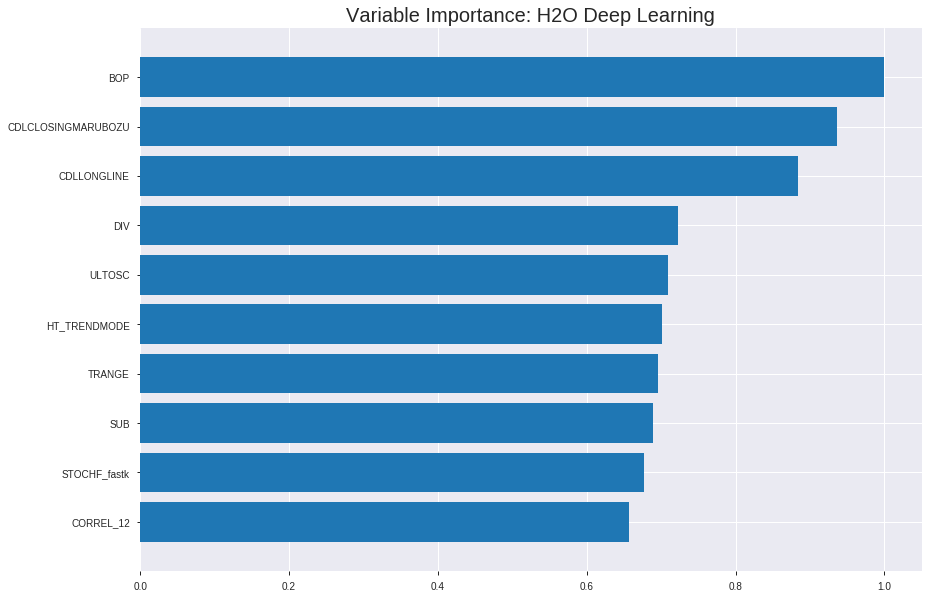

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_061450_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19316056562748365
RMSE: 0.4395003590754889
LogLoss: 0.5656459338588347
Mean Per-Class Error: 0.28751300379207356
AUC: 0.7865675022651767
pr_auc: 0.7763139107861509
Gini: 0.5731350045303534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29045587259155653: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      353  417   0.5416   (417.0/770.0)
1      68   706   0.0879   (68.0/774.0)
Total  421  1123  0.3141   (485.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290456     0.744333  279
max f2                       0.114334     0.852514  352
max f0point5                 0.466044     0.716753  184
max accuracy                 0.444089     0.712435  197
max precision                0.958042     1         0
max recall                   0.0417705    1         386
max specificity              0.958042     1         0
max absolute_mcc             0.444089     0.425294  197
max min_per_class_accuracy   0.43531      0.705195  203
max mean_per_class_accuracy  0.444089     0.712487  197

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 43.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.932549           1.74548   1.74548            0.875            0.945108   0.875                       0.945108            0.0180879       0.0180879                  74.5478   74.5478
    2        0.0200777                   0.917533           1.86184   1.80178            0.933333         0.924977   0.903226                    0.935367            0.0180879       0.0361757                  86.1843   80.1784
    3        0.0304404                   0.902865           1.99483   1.8675             1                0.911072   0.93617                     0.927096            0.0206718       0.0568475                  99.4832   86.7502
    4        0.0401554                   0.87938            1.86184   1.86613            0.933333         0.890599   0.935484                    0.918266            0.0180879       0.0749354                  86.1843   86.6133
    5        0.0505181                   0.865829           1.74548   1.84138            0.875            0.874126   0.923077                    0.909212            0.0180879       0.0930233                  74.5478   84.1383
    6        0.100389                    0.789454           1.76167   1.80178            0.883117         0.827905   0.903226                    0.868821            0.0878553       0.180879                   76.167    80.1784
    7        0.150259                    0.674132           1.65804   1.75408            0.831169         0.726514   0.87931                     0.821589            0.0826873       0.263566                   65.8042   75.4076
    8        0.20013                     0.616081           1.5026    1.69141            0.753247         0.646106   0.847896                    0.777861            0.0749354       0.338501                   50.2601   69.1411
    9        0.29987                     0.543011           1.29535   1.55967            0.649351         0.574979   0.781857                    0.710379            0.129199        0.4677                     29.5345   55.9674
    10       0.400259                    0.481429           1.29986   1.49451            0.651613         0.509508   0.749191                    0.659999            0.130491        0.598191                   29.9858   49.451
    11       0.5                         0.434909           1.07514   1.41085            0.538961         0.457758   0.707254                    0.619656            0.107235        0.705426                   7.51367   41.0853
    12       0.599741                    0.382421           0.958556  1.33563            0.480519         0.411281   0.669546                    0.585002            0.0956072       0.801034                   -4.14443  33.5633
    13       0.70013                     0.314835           0.862282  1.26776            0.432258         0.352594   0.635523                    0.551678            0.0865633       0.887597                   -13.7718  26.7761
    14       0.79987                     0.213199           0.582905  1.18236            0.292208         0.264317   0.592713                    0.515845            0.0581395       0.945736                   -41.7095  18.2362
    15       0.899611                    0.108442           0.401557  1.09579            0.201299         0.160301   0.549316                    0.476425            0.0400517       0.985788                   -59.8443  9.57933
    16       1                           0.00740695         0.141569  1                  0.0709677        0.0658854  0.501295                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20413854260290065
RMSE: 0.45181693483412133
LogLoss: 0.5930849017154214
Mean Per-Class Error: 0.2773605150214593
AUC: 0.7667959722680753
pr_auc: 0.7442755914462112
Gini: 0.5335919445361506
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3803392024623093: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      162  71   0.3047   (71.0/233.0)
1      52   156  0.25     (52.0/208.0)
Total  214  227  0.2789   (123.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380339     0.717241  207
max f2                       0.131549     0.834032  330
max f0point5                 0.380339     0.698925  207
max accuracy                 0.380339     0.721088  207
max precision                0.965348     1         0
max recall                   0.0330867    1         390
max specificity              0.965348     1         0
max absolute_mcc             0.380339     0.444756  207
max min_per_class_accuracy   0.39708      0.716346  197
max mean_per_class_accuracy  0.380339     0.722639  207

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 38.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.945455           2.12019   2.12019            1                0.955754   1                           0.955754            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.915519           2.12019   2.12019            1                0.929484   1                           0.944078            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.894638           1.69615   1.96875            0.8              0.905663   0.928571                    0.930359            0.0192308       0.0625                     69.6154   96.875
    4        0.0408163                   0.846251           2.12019   2.0024             1                0.866218   0.944444                    0.916105            0.0192308       0.0817308                  112.019   100.24
    5        0.0521542                   0.832479           2.12019   2.02801            1                0.839719   0.956522                    0.899499            0.0240385       0.105769                   112.019   102.801
    6        0.102041                    0.659423           1.7347    1.88462            0.818182         0.720573   0.888889                    0.812024            0.0865385       0.192308                   73.4703   88.4615
    7        0.151927                    0.592811           1.25284   1.67717            0.590909         0.618691   0.791045                    0.748542            0.0625          0.254808                   25.2841   67.7167
    8        0.201814                    0.553004           1.83108   1.71521            0.863636         0.569813   0.808989                    0.704362            0.0913462       0.346154                   83.1075   71.5212
    9        0.301587                    0.499035           1.25284   1.56225            0.590909         0.523523   0.736842                    0.644535            0.125           0.471154                   25.2841   56.2247
    10       0.401361                    0.439548           1.34921   1.50929            0.636364         0.467137   0.711864                    0.600436            0.134615        0.605769                   34.9213   50.9289
    11       0.501134                    0.392699           1.25284   1.45823            0.590909         0.413938   0.687783                    0.563305            0.125           0.730769                   25.2841   45.8232
    12       0.600907                    0.327929           0.530048  1.30412            0.25             0.357221   0.615094                    0.529088            0.0528846       0.783654                   -46.9952  30.4118
    13       0.70068                     0.238024           0.770979  1.2282             0.363636         0.285131   0.579288                    0.49435             0.0769231       0.860577                   -22.9021  22.8202
    14       0.800454                    0.151757           0.770979  1.17121            0.363636         0.194058   0.552408                    0.456919            0.0769231       0.9375                     -22.9021  17.1211
    15       0.900227                    0.0730743          0.433676  1.08947            0.204545         0.107774   0.513854                    0.418223            0.0432692       0.980769                   -56.6324  8.94691
    16       1                           0.0181992          0.192745  1                  0.0909091        0.0451872  0.471655                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:18:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:18:44  2 min  9.179 sec  921 obs/sec       1.53627   1             2372       0.490851         0.779204            0.0362531      0.746599        0.712926           1.6208           0.356865                         0.495813           0.775479              0.0135079        0.725827          0.700849             1.69615            0.365079
    2019-07-25 06:18:51  2 min 15.720 sec  1696 obs/sec      9.31282   6             14379      0.4395           0.565646            0.227353       0.786568        0.776314           1.74548          0.314119                         0.451817           0.593085              0.180813         0.766796          0.744276             2.12019            0.278912
    2019-07-25 06:18:58  2 min 22.396 sec  2144 obs/sec      20.1593   13            31126      0.430013         0.543884            0.260351       0.804399        0.797327           1.99483          0.277202                         0.448933           0.600523              0.191238         0.770046          0.760524             2.12019            0.287982
    2019-07-25 06:19:05  2 min 29.406 sec  2401 obs/sec      32.489    21            50163      0.419306         0.521974            0.296726       0.824028        0.814131           1.99483          0.272021                         0.445669           0.607683              0.202954         0.770851          0.760097             2.12019            0.267574
    2019-07-25 06:19:12  2 min 36.424 sec  2543 obs/sec      44.8666   29            69274      0.409675         0.502297            0.32866        0.841366        0.830983           1.99483          0.248705                         0.454174           0.629643              0.172245         0.758604          0.758073             2.12019            0.281179
    2019-07-25 06:19:19  2 min 43.423 sec  2632 obs/sec      57.3122   37            88490      0.397165         0.480184            0.369036       0.863429        0.853836           1.99483          0.228627                         0.455141           0.640732              0.168716         0.748814          0.750467             2.12019            0.287982
    2019-07-25 06:19:25  2 min 50.276 sec  2705 obs/sec      69.6846   45            107593     0.390493         0.46304             0.390056       0.87045         0.859748           1.99483          0.225389                         0.459612           0.677898              0.152303         0.747802          0.742512             2.12019            0.287982
    2019-07-25 06:19:26  2 min 50.933 sec  2704 obs/sec      69.6846   45            107593     0.4395           0.565646            0.227353       0.786568        0.776314           1.74548          0.314119                         0.451817           0.593085              0.180813         0.766796          0.744276             2.12019            0.278912

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.031192300587709516
CDLCLOSINGMARUBOZU  0.9370428323745728     0.9370428323745728   0.029228521690986376
CDLLONGLINE         0.8838075995445251     0.8838075995445251   0.02756799230669483
DIV                 0.7230332493782043     0.7230332493782043   0.022553070449513286
ULTOSC              0.7096831798553467     0.7096831798553467   0.02213665106808949
---                 ---                    ---                  ---
CDLDOJI             0.5885633230209351     0.5885633230209351   0.01835864408657018
WILLR_14            0.5815819501876831     0.5815819501876831   0.018140879006640513
weekday_name        0.5660936236381531     0.5660936236381531   0.017657762469306972
is_month_start      0.5604264736175537     0.5604264736175537   0.017480991022388793
CORREL_20           0.5556899309158325     0.5556899309158325   0.017333247358690185


See the whole table with table.as_data_frame()


('accuracy', 0.7194570135746606)

('F1', 0.7265306122448979)

('auc', 0.7616584564860427)

('logloss', 0.6144832106144846)

('mean_per_class_error', 0.2803366174055829)

('rmse', 0.45651322437994973)

('mse', 0.20840432403377832)

deeplearning prediction progress: |███████████████████████████████████████| 100%


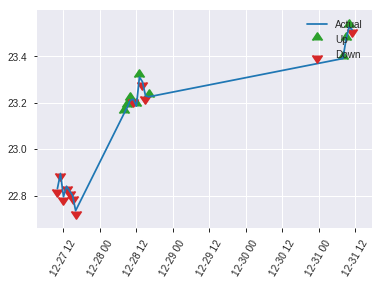


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20840432403377832
RMSE: 0.45651322437994973
LogLoss: 0.6144832106144846
Mean Per-Class Error: 0.2803366174055829
AUC: 0.7616584564860427
pr_auc: 0.720284511462545
Gini: 0.5233169129720854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25796642677356285: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   51   0.4397   (51.0/116.0)
1      16   89   0.1524   (16.0/105.0)
Total  81   140  0.3032   (67.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257966     0.726531  139
max f2                       0.0454567    0.825397  209
max f0point5                 0.472112     0.717647  79
max accuracy                 0.397347     0.719457  106
max precision                0.940626     1         0
max recall                   0.0175507    1         220
max specificity              0.940626     1         0
max absolute_mcc             0.38704      0.438823  108
max min_per_class_accuracy   0.38704      0.715517  108
max mean_per_class_accuracy  0.38704      0.719663  108

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 37.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.91848            2.10476   2.10476            1                0.933497   1                           0.933497            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.896692           1.05238   1.68381            0.5              0.908973   0.8                         0.923687            0.00952381      0.0380952                  5.2381    68.381
    3        0.0316742                   0.870728           2.10476   1.80408            1                0.881075   0.857143                    0.911512            0.0190476       0.0571429                  110.476   80.4082
    4        0.040724                    0.852174           2.10476   1.8709             1                0.860862   0.888889                    0.900257            0.0190476       0.0761905                  110.476   87.0899
    5        0.0542986                   0.848862           2.10476   1.92937            1                0.850282   0.916667                    0.887763            0.0285714       0.104762                   110.476   92.9365
    6        0.104072                    0.703428           1.72208   1.83023            0.818182         0.775377   0.869565                    0.834013            0.0857143       0.190476                   72.2078   83.0228
    7        0.153846                    0.617364           1.33939   1.67143            0.636364         0.642449   0.794118                    0.772036            0.0666667       0.257143                   33.9394   67.1429
    8        0.20362                     0.545782           1.14805   1.54349            0.545455         0.570649   0.733333                    0.722808            0.0571429       0.314286                   14.8052   54.3492
    9        0.303167                    0.49721            1.72208   1.60213            0.818182         0.521503   0.761194                    0.656708            0.171429        0.485714                   72.2078   60.2132
    10       0.402715                    0.442584           1.24372   1.51354            0.590909         0.473261   0.719101                    0.611362            0.12381         0.609524                   24.3723   51.3537
    11       0.502262                    0.384144           1.14805   1.4411             0.545455         0.415958   0.684685                    0.572633            0.114286        0.72381                    14.8052   44.1098
    12       0.60181                     0.30269            0.861039  1.34515            0.409091         0.343271   0.639098                    0.534693            0.0857143       0.809524                   -13.8961  34.5149
    13       0.701357                    0.216022           0.669697  1.24928            0.318182         0.248745   0.593548                    0.494107            0.0666667       0.87619                    -33.0303  24.9278
    14       0.800905                    0.138391           0.478355  1.15346            0.227273         0.170667   0.548023                    0.453906            0.047619        0.92381                    -52.1645  15.3457
    15       0.900452                    0.0794497          0.478355  1.07882            0.227273         0.103511   0.512563                    0.415168            0.047619        0.971429                   -52.1645  7.88227
    16       1                           0.0175507          0.287013  1                  0.136364         0.0456943  0.475113                    

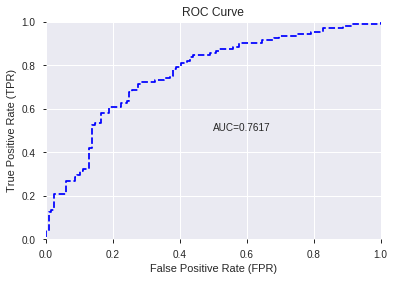

This function is available for GLM models only


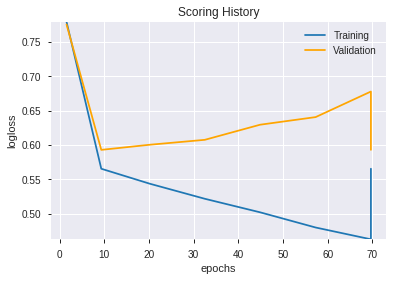

--2019-07-25 06:23:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


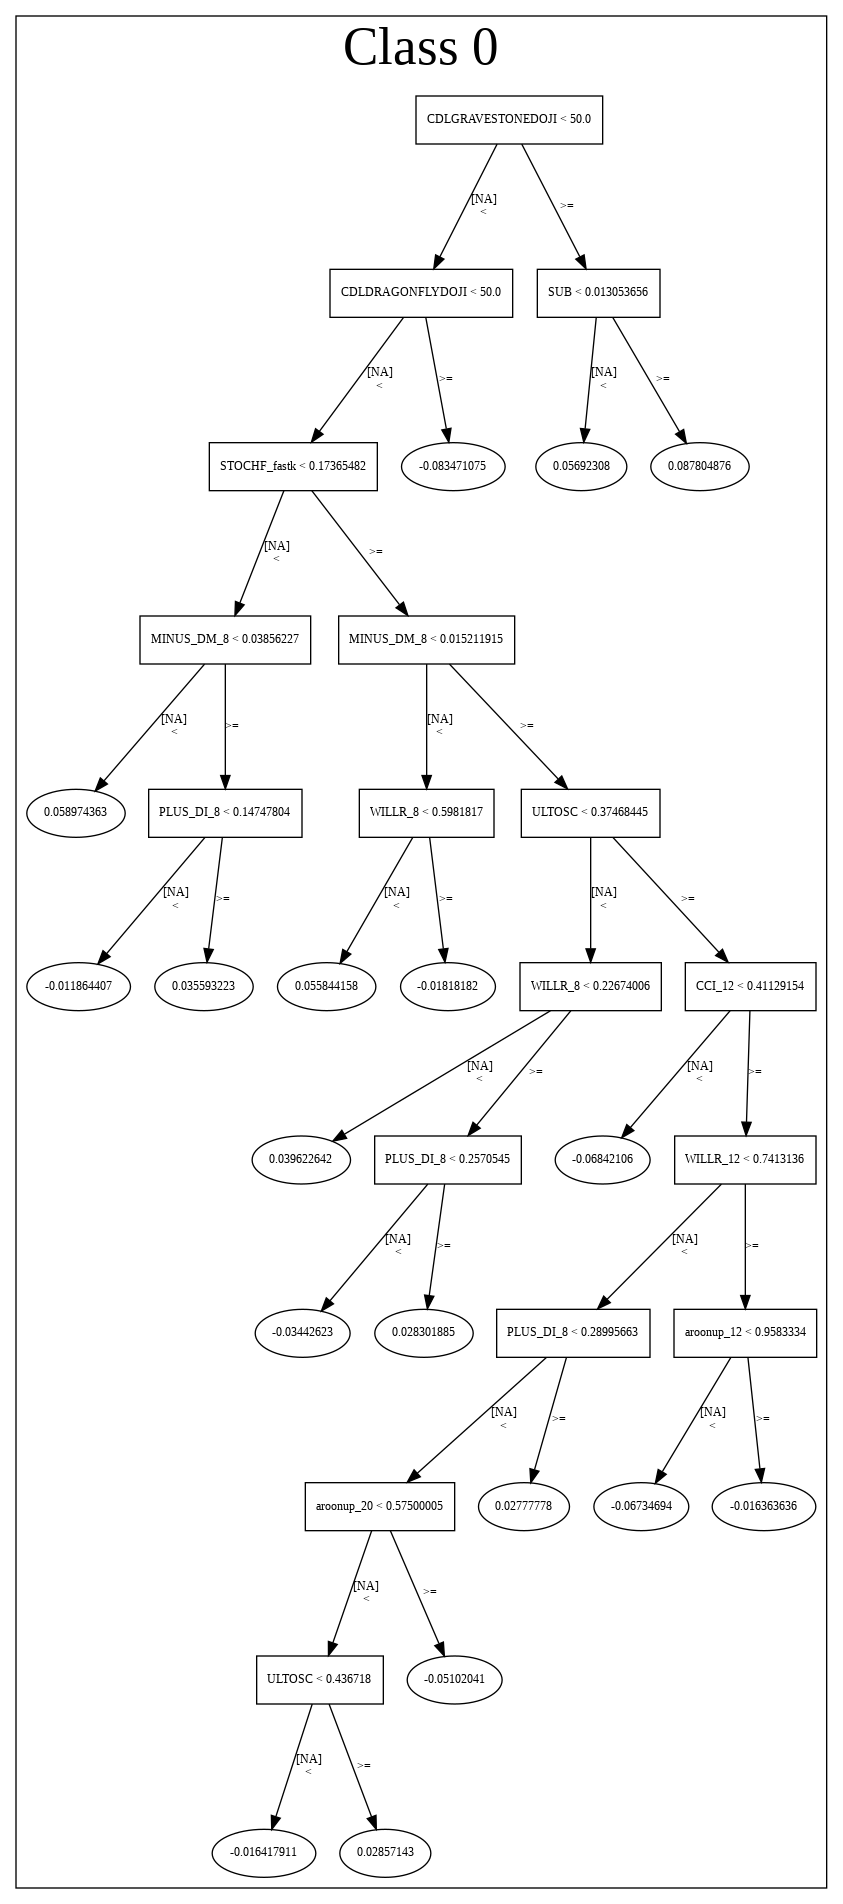

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_061450_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_061450_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'DIV',
 'ULTOSC',
 'HT_TRENDMODE',
 'TRANGE',
 'SUB',
 'STOCHF_fastk',
 'CORREL_12',
 'CDLHANGINGMAN',
 'CDLLADDERBOTTOM',
 'hour',
 'aroonup_24',
 'CORREL_30',
 'DX_8',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'CDLTAKURI',
 'STOCH_slowd',
 'CDLDARKCLOUDCOVER',
 'HT_DCPERIOD',
 'SAREXT',
 'dayofweek',
 'CDLGRAVESTONEDOJI',
 'CDLIDENTICAL3CROWS',
 'CDLLONGLEGGEDDOJI',
 'day',
 'STOCHRSI_fastd',
 'CDLEVENINGSTAR',
 'CDL3BLACKCROWS',
 'CDLBELTHOLD',
 'ADOSC',
 'Volume',
 'CORREL_24',
 'CDLSPINNINGTOP',
 'aroonup_8',
 'WILLR_24',
 'AROONOSC_8',
 'WILLR_20',
 'BETA_8',
 'WILLR_8',
 'weekday',
 'CDL3WHITESOLDIERS',
 'WILLR_12',
 'CDLDOJI',
 'WILLR_14',
 'weekday_name',
 'is_month_start',
 'CORREL_20']

In [0]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_062352_model_1  0.75509  0.59914              0.284893  0.450661  0.203095

variable  relative_importance  scaled_importance  percentage
0                  SUB             1.398324           1.000000    0.133945
1                  DIV             0.728790           0.521188    0.069810
2                  BOP             0.687756           0.491843    0.065880
3         STOCHF_fastk             0.549306           0.392831    0.052618
4          STOCH_slowd             0.527582           0.377296    0.050537
5               ULTOSC             0.525319           0.375677    0.050320
6             WILLR_24             0.394721           0.282281    0.037810
7    CDLDARKCLOUDCOVER             0.365486           0.261374    0.035010
8       STOCHRSI_fastk             0.353760           0.252989    0.033886
9               TRANGE             0.314559           0.224954    0.030131
10   CDL3WHITESOLDIERS             0.288874           0.206586    0.027671
11         CDLLONGLINE             0.262673           0.187848    0.025161
12           CORREL_30             0.252740           0.180745    0.024210
13  CDLIDENTICAL3CROWS             0.240875           0.172260    0.023073
14            WILLR_20             0.235653           0.168525    0.022573
15            WILLR_12             0.232960           0.166599    0.022315
16          aroonup_24             0.225179           0.161035    0.021570
17  CDLCLOSINGMARUBOZU             0.207344           0.148280    0.019861
18                hour             0.198184           0.141730    0.018984
19     CDLLADDERBOTTOM             0.196570           0.140575    0.018829
20         CDLBELTHOLD             0.192489           0.137657    0.018438
21           aroonup_8             0.177687           0.127071    0.017020
22      CDL3BLACKCROWS             0.163210           0.116718    0.015634
23         HT_DCPERIOD             0.147331           0.105362    0.014113
24      STOCHRSI_fastd             0.145258           0.103880    0.013914
25              BETA_8             0.123834           0.088559    0.011862
26          AROONOSC_8             0.116931           0.083622    0.011201
27             WILLR_8             0.110244           0.078840    0.010560
28        HT_TRENDMODE             0.107529           0.076899    0.010300
29              Volume             0.099444           0.071117    0.009526
30       CDLHANGINGMAN             0.096067           0.068701    0.009202
31           CDLHAMMER             0.092600           0.066222    0.008870
32           CORREL_12             0.080735           0.057737    0.007734
33           CDLTAKURI             0.068862           0.049246    0.006596
34           CORREL_24             0.065450           0.046806    0.006269
35            WILLR_14             0.061061           0.043667    0.005849
36           CORREL_20             0.059965           0.042884    0.005744
37                 day             0.058598           0.041906    0.005613
38      is_month_start             0.055674           0.039814    0.005333
39                DX_8             0.050856           0.036369    0.004871
40      CDLEVENINGSTAR             0.041233           0.029487    0.003950
41              SAREXT             0.035789           0.025594    0.003428
42           dayofweek             0.025570           0.018286    0.002449
43             weekday             0.024379           0.017434    0.002335
44   CDLGRAVESTONEDOJI             0.018470           0.013209    0.001769
45               ADOSC             0.012988           0.009288    0.001244
46      CDLSPINNINGTOP             0.007929           0.005670    0.000759
47   CDLLONGLEGGEDDOJI             0.005048           0.003610    0.000484
48        weekday_name             0.003853           0.002756    0.000369
49             CDLDOJI             0.003827           0.002737    0.000367

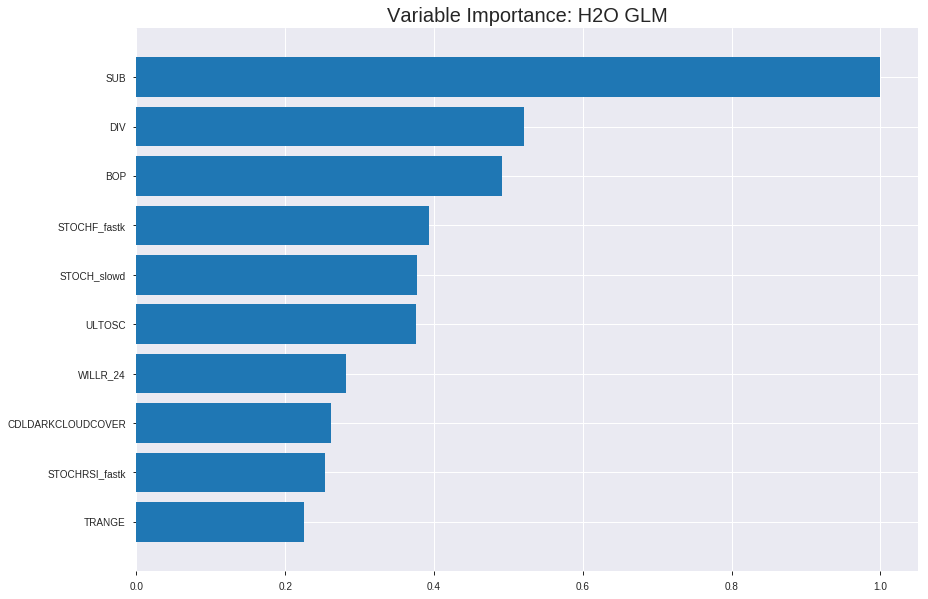

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_062352_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18764513985795342
RMSE: 0.43318026254430547
LogLoss: 0.5540202908645274
Null degrees of freedom: 1543
Residual degrees of freedom: 1493
Null deviance: 2140.428130863218
Residual deviance: 1710.8146581896608
AIC: 1812.8146581896608
AUC: 0.7871228900298668
pr_auc: 0.7691549689174877
Gini: 0.5742457800597336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40325188428610403: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  340   0.4416   (340.0/770.0)
1      109  665   0.1408   (109.0/774.0)
Total  539  1005  0.2908   (449.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403252     0.747611  246
max f2                       0.190052     0.85104   332
max f0point5                 0.536469     0.715829  181
max accuracy                 0.475173     0.716321  214
max precision                0.999761     1         0
max recall                   0.0516584    1         385
max specificity              0.999761     1         0
max absolute_mcc             0.421697     0.441877  239
max min_per_class_accuracy   0.521019     0.712987  190
max mean_per_class_accuracy  0.475173     0.716155  214

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.953015           1.87016   1.87016            0.9375           0.967007   0.9375                      0.967007            0.0193798       0.0193798                  87.0155   87.0155
    2        0.0200777                   0.927584           1.72885   1.80178            0.866667         0.937765   0.903226                    0.952858            0.0167959       0.0361757                  72.8854   80.1784
    3        0.0304404                   0.914181           1.87016   1.82506            0.9375           0.921132   0.914894                    0.942058            0.0193798       0.0555556                  87.0155   82.5059
    4        0.0401554                   0.901384           1.86184   1.83396            0.933333         0.907688   0.919355                    0.933742            0.0180879       0.0736434                  86.1843   83.3958
    5        0.0505181                   0.890742           1.74548   1.81581            0.875            0.897128   0.910256                    0.926232            0.0180879       0.0917313                  74.5478   81.5809
    6        0.100389                    0.833461           1.76167   1.78891            0.883117         0.864143   0.896774                    0.895388            0.0878553       0.179587                   76.167    78.8914
    7        0.150259                    0.782888           1.55441   1.71108            0.779221         0.808297   0.857759                    0.866483            0.0775194       0.257106                   55.4415   71.1084
    8        0.20013                     0.731097           1.5026    1.65913            0.753247         0.755381   0.831715                    0.838797            0.0749354       0.332041                   50.2601   65.9132
    9        0.29987                     0.655331           1.39897   1.5726             0.701299         0.693159   0.788337                    0.790356            0.139535        0.471576                   39.8973   57.26
    10       0.400259                    0.585284           1.23551   1.48805            0.619355         0.619736   0.745955                    0.747563            0.124031        0.595607                   23.5509   48.8054
    11       0.5                         0.521118           1.16581   1.42377            0.584416         0.554765   0.713731                    0.709103            0.116279        0.711886                   16.5811   42.3773
    12       0.599741                    0.445834           0.945602  1.34425            0.474026         0.484715   0.673866                    0.671786            0.0943152       0.806202                   -5.43978  34.425
    13       0.70013                     0.354882           0.836542  1.27145            0.419355         0.402105   0.637373                    0.633118            0.0839793       0.890181                   -16.3458  27.1452
    14       0.79987                     0.254189           0.569952  1.18398            0.285714         0.304495   0.593522                    0.59214             0.0568475       0.947028                   -43.0048  18.3977
    15       0.899611                    0.140957           0.323836  1.08861            0.162338         0.199069   0.545716                    0.548559            0.0322997       0.979328                   -67.6164  8.86124
    16       1                           1.90865e-05        0.205918  1                  0.103226         0.0777493  0.501295                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18850089121977703
RMSE: 0.4341668932792746
LogLoss: 0.5543906519383016
Null degrees of freedom: 440
Residual degrees of freedom: 390
Null deviance: 611.4883070433551
Residual deviance: 488.972555009582
AIC: 590.972555009582
AUC: 0.7851704357873887
pr_auc: 0.7658592916534083
Gini: 0.5703408715747773
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39583816372458747: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  99   0.4249   (99.0/233.0)
1      36   172  0.1731   (36.0/208.0)
Total  170  271  0.3061   (135.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395838     0.718163  239
max f2                       0.203489     0.835422  328
max f0point5                 0.557902     0.723039  140
max accuracy                 0.557902     0.718821  140
max precision                0.974311     1         0
max recall                   0.0766624    1         377
max specificity              0.974311     1         0
max absolute_mcc             0.557902     0.442607  140
max min_per_class_accuracy   0.486999     0.706731  191
max mean_per_class_accuracy  0.429376     0.711311  217

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 46.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.89154            2.12019   2.12019            1                0.92387    1                           0.92387             0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.868301           2.12019   2.12019            1                0.87784    1                           0.903412            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.856807           1.69615   1.96875            0.8              0.861841   0.928571                    0.888565            0.0192308       0.0625                     69.6154   96.875
    4        0.0408163                   0.837064           2.12019   2.0024             1                0.844782   0.944444                    0.878836            0.0192308       0.0817308                  112.019   100.24
    5        0.0521542                   0.826345           1.69615   1.93583            0.8              0.829731   0.913043                    0.868161            0.0192308       0.100962                   69.6154   93.5828
    6        0.102041                    0.769721           1.83108   1.88462            0.863636         0.796532   0.888889                    0.833142            0.0913462       0.192308                   83.1075   88.4615
    7        0.151927                    0.725423           1.92745   1.89868            0.909091         0.742577   0.895522                    0.803404            0.0961538       0.288462                   92.7448   89.868
    8        0.201814                    0.680544           1.54196   1.8105             0.727273         0.703288   0.853933                    0.778656            0.0769231       0.365385                   54.1958   81.0501
    9        0.301587                    0.59628            1.3974    1.67384            0.659091         0.643293   0.789474                    0.733875            0.139423        0.504808                   39.7399   67.3836
    10       0.401361                    0.527583           0.963724  1.49731            0.454545         0.556203   0.706215                    0.689708            0.0961538       0.600962                   -3.62762  49.7311
    11       0.501134                    0.480336           1.10828   1.41986            0.522727         0.503013   0.669683                    0.652538            0.110577        0.711538                   10.8282   41.9857
    12       0.600907                    0.404896           0.963724  1.34412            0.454545         0.433694   0.633962                    0.616201            0.0961538       0.807692                   -3.62762  34.4122
    13       0.70068                     0.329682           0.62642   1.24192            0.295455         0.371313   0.585761                    0.581331            0.0625          0.870192                   -37.358   24.1925
    14       0.800454                    0.239985           0.770979  1.18322            0.363636         0.285703   0.558074                    0.544482            0.0769231       0.947115                   -22.9021  18.3223
    15       0.900227                    0.122162           0.337303  1.08947            0.159091         0.177193   0.513854                    0.503775            0.0336538       0.980769                   -66.2697  8.94691
    16       1                           0.00419721         0.192745  1                  0.0909091        0.0686068  0.471655                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 06:23:52  0.000 sec   2            .2E2      51            1.364190226758374   1.3667910236332164
     2019-07-25 06:23:52  0.009 sec   4            .12E2     51            1.3531316905457011  1.3567910412334865
     2019-07-25 06:23:52  0.019 sec   6            .76E1     51            1.3380823028143753  1.3430743154760845
     2019-07-25 06:23:52  0.028 sec   8            .47E1     51            1.3188623547022686  1.325345543416773
     2019-07-25 06:23:52  0.037 sec   10           .29E1     51            1.29587718440371    1.3038128066579673
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 06:23:53  0.231 sec   47           .21E-3    51            1.108122440116475   1.1091371125675025
     2019-07-25 06:23:53  0.236 sec   48           .13E-3    51            1.1080779251959587  1.1089779613487334
     2019-07-25 06:23:53  0.245 sec   49           .82E-4    51            1.108056103085385   1.1088796753629135
     2019-07-25 06:23:53  0.250 sec   50           .51E-4    51            1.1080458614733448  1.1088169054025587
     2019-07-25 06:23:53  0.256 sec   51           .32E-4    51            1.1080405817290548  1.1087813038766032


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7104072398190046)

('F1', 0.7264957264957264)

('auc', 0.7550903119868637)

('logloss', 0.5991399003780321)

('mean_per_class_error', 0.28489326765188827)

('rmse', 0.4506608527124509)

('mse', 0.20309520416751334)

glm prediction progress: |████████████████████████████████████████████████| 100%


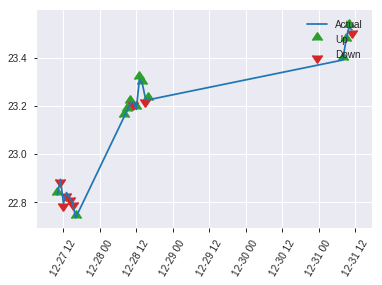


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20309520416751334
RMSE: 0.4506608527124509
LogLoss: 0.5991399003780321
Null degrees of freedom: 220
Residual degrees of freedom: 170
Null deviance: 306.4295320199308
Residual deviance: 264.81983596709017
AIC: 366.81983596709017
AUC: 0.7550903119868637
pr_auc: 0.7191059260330794
Gini: 0.5101806239737274
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44954271390889555: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   44   0.3793   (44.0/116.0)
1      20   85   0.1905   (20.0/105.0)
Total  92   129  0.2896   (64.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449543     0.726496  128
max f2                       0.277942     0.829103  170
max f0point5                 0.655905     0.687023  71
max accuracy                 0.449543     0.710407  128
max precision                0.952054     1         0
max recall                   0.025479     1         218
max specificity              0.952054     1         0
max absolute_mcc             0.449543     0.435832  128
max min_per_class_accuracy   0.536614     0.685714  107
max mean_per_class_accuracy  0.449543     0.715107  128

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 50.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.92688            2.10476   2.10476            1                0.936861   1                           0.936861            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.915971           2.10476   2.10476            1                0.92191    1                           0.93088             0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.900025           2.10476   2.10476            1                0.907474   1                           0.924193            0.0190476       0.0666667                  110.476   110.476
    4        0.040724                    0.892384           1.05238   1.8709             0.5              0.89823    0.888889                    0.918423            0.00952381      0.0761905                  5.2381    87.0899
    5        0.0542986                   0.882561           2.10476   1.92937            1                0.886505   0.916667                    0.910444            0.0285714       0.104762                   110.476   92.9365
    6        0.104072                    0.818011           1.53074   1.73872            0.727273         0.842557   0.826087                    0.877976            0.0761905       0.180952                   53.0736   73.8716
    7        0.153846                    0.769623           1.72208   1.73333            0.818182         0.788991   0.823529                    0.849187            0.0857143       0.266667                   72.2078   73.3333
    8        0.20362                     0.73769            1.14805   1.59026            0.545455         0.751806   0.755556                    0.825383            0.0571429       0.32381                    14.8052   59.0265
    9        0.303167                    0.678355           1.43506   1.5393             0.681818         0.704244   0.731343                    0.785606            0.142857        0.466667                   43.5065   53.9303
    10       0.402715                    0.612051           1.14805   1.44259            0.545455         0.636755   0.685393                    0.748811            0.114286        0.580952                   14.8052   44.259
    11       0.502262                    0.518956           1.24372   1.40317            0.590909         0.562435   0.666667                    0.711872            0.12381         0.704762                   24.3723   40.3175
    12       0.60181                     0.439145           1.05238   1.34515            0.5              0.474217   0.639098                    0.67256             0.104762        0.809524                   5.2381    34.5149
    13       0.701357                    0.350012           0.574026  1.2357             0.272727         0.386757   0.587097                    0.631995            0.0571429       0.866667                   -42.5974  23.5699
    14       0.800905                    0.2563             0.669697  1.16535            0.318182         0.299534   0.553672                    0.590672            0.0666667       0.933333                   -33.0303  16.5348
    15       0.900452                    0.144326           0.191342  1.05767            0.0909091        0.204165   0.502513                    0.547943            0.0190476       0.952381                   -80.8658  5.76693
    16       1                           0.0137118          0.478355  1                  0.227273         0.0691825  0.475113                    

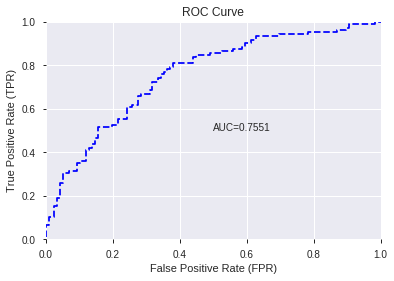

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


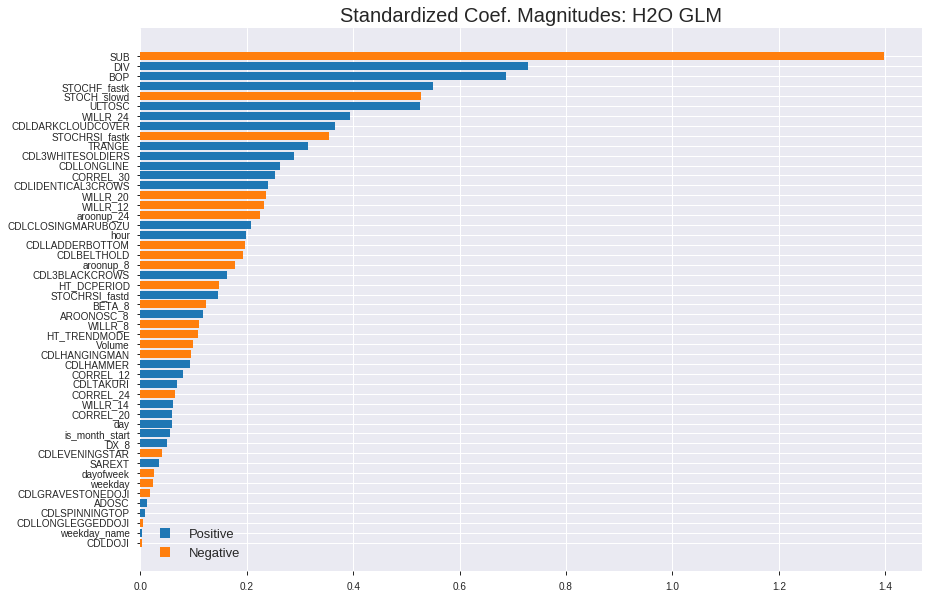

'log_likelihood'
--2019-07-25 06:23:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


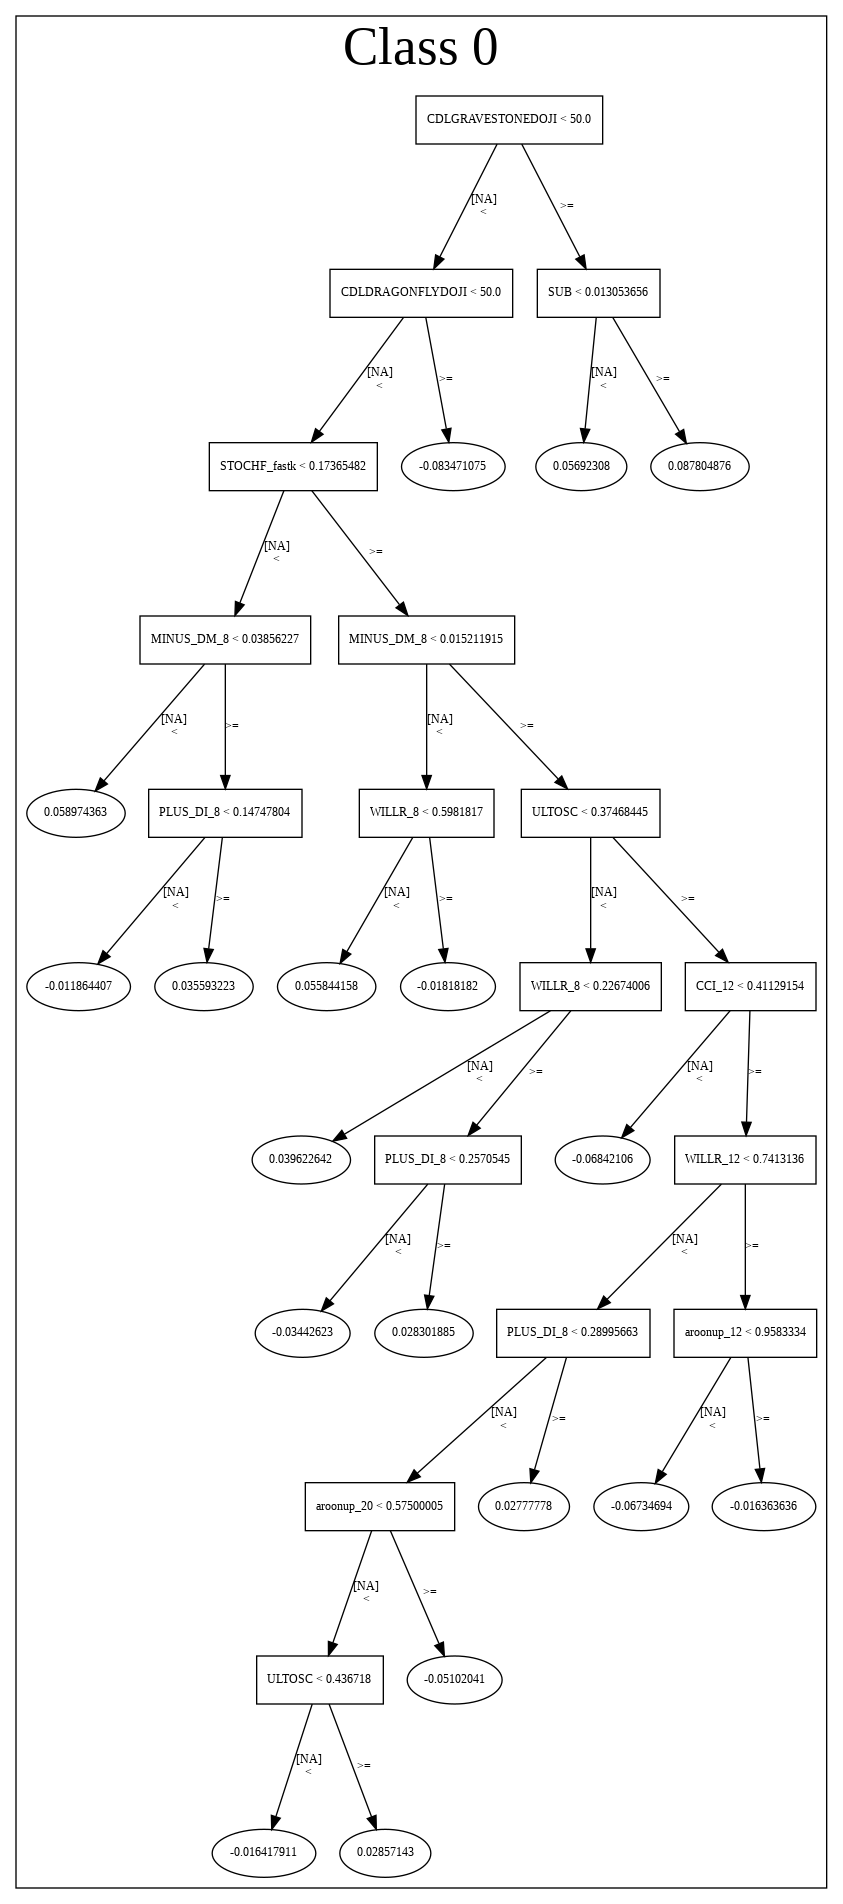

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_062352_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_062352_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SUB',
 'DIV',
 'BOP',
 'STOCHF_fastk',
 'STOCH_slowd',
 'ULTOSC',
 'WILLR_24',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'TRANGE',
 'CDL3WHITESOLDIERS',
 'CDLLONGLINE',
 'CORREL_30',
 'CDLIDENTICAL3CROWS',
 'WILLR_20',
 'WILLR_12',
 'aroonup_24',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'CDLLADDERBOTTOM',
 'CDLBELTHOLD',
 'aroonup_8',
 'CDL3BLACKCROWS',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'BETA_8',
 'AROONOSC_8',
 'WILLR_8',
 'HT_TRENDMODE',
 'Volume',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CORREL_12',
 'CDLTAKURI',
 'CORREL_24',
 'WILLR_14',
 'CORREL_20',
 'day',
 'is_month_start',
 'DX_8',
 'CDLEVENINGSTAR',
 'SAREXT',
 'dayofweek',
 'weekday',
 'CDLGRAVESTONEDOJI',
 'ADOSC',
 'CDLSPINNINGTOP',
 'CDLLONGLEGGEDDOJI',
 'weekday_name',
 'CDLDOJI']

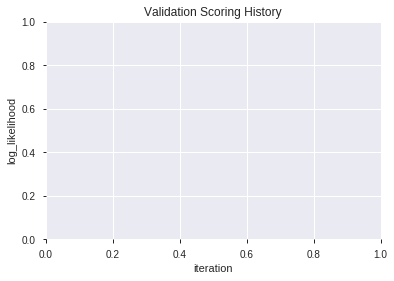

In [0]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_062408_model_6  0.768555  0.581422              0.282389  0.442694  0.195978
1  XGBoost_grid_1_AutoML_20190725_062408_model_4  0.758785  0.587882              0.307594  0.447109  0.199907
2  XGBoost_grid_1_AutoML_20190725_062408_model_2  0.757143  0.586165              0.296921  0.446801  0.199631
3  XGBoost_grid_1_AutoML_20190725_062408_model_3  0.756979  0.586850              0.311905  0.447214  0.200001
4  XGBoost_grid_1_AutoML_20190725_062408_model_5  0.752299  0.609741              0.298727  0.453324  0.205503
5  XGBoost_grid_1_AutoML_20190725_062408_model_1  0.751888  0.595834              0.292611  0.450609  0.203048
6               XGBoost_3_AutoML_20190725_062408  0.750082  0.592105              0.296921  0.450098  0.202588
7               XGBoost_1_AutoML_20190725_062408  0.748933  0.600866              0.335961  0.451991  0.204296
8  XGBoost_grid_1_AutoML_20190725_062408_model_7  0.744089  0.603925              0.324138  0.454460  0.206534
9               XGBoost_2_AutoML_20190725_062408  0.744007  0.597031              0.360016  0.452654  0.204896

variable  relative_importance  scaled_importance  percentage
0                  BOP          1886.109253           1.000000    0.187202
1         STOCHF_fastk           747.596130           0.396369    0.074201
2                  DIV           483.659729           0.256433    0.048005
3               Volume           405.282288           0.214877    0.040225
4               TRANGE           397.598572           0.210804    0.039463
5                ADOSC           390.328552           0.206949    0.038741
6               SAREXT           386.174805           0.204747    0.038329
7            CORREL_30           357.802490           0.189704    0.035513
8               BETA_8           341.724426           0.181180    0.033917
9               ULTOSC           322.064056           0.170756    0.031966
10         STOCH_slowd           306.956818           0.162746    0.030466
11                DX_8           303.312775           0.160814    0.030105
12         HT_DCPERIOD           297.836487           0.157911    0.029561
13                hour           296.935974           0.157433    0.029472
14      STOCHRSI_fastd           289.852905           0.153678    0.028769
15             WILLR_8           287.431213           0.152394    0.028528
16           CORREL_12           254.984039           0.135190    0.025308
17           CORREL_20           221.594452           0.117488    0.021994
18           CORREL_24           220.587448           0.116954    0.021894
19                 SUB           207.783142           0.110165    0.020623
20            WILLR_12           206.021790           0.109231    0.020448
21           aroonup_8           200.784927           0.106455    0.019928
22            WILLR_20           178.206604           0.094484    0.017688
23            WILLR_24           150.978867           0.080048    0.014985
24                 day           149.681641           0.079360    0.014856
25         CDLLONGLINE           126.002670           0.066806    0.012506
26            WILLR_14           111.949883           0.059355    0.011111
27           dayofweek           107.044373           0.056754    0.010624
28          aroonup_24            99.908089           0.052970    0.009916
29          AROONOSC_8            94.688271           0.050203    0.009398
30      STOCHRSI_fastk            68.340195           0.036233    0.006783
31  CDLCLOSINGMARUBOZU            61.388767           0.032548    0.006093
32        weekday_name            38.620861           0.020476    0.003833
33        HT_TRENDMODE            29.343384           0.015558    0.002912
34      CDLSPINNINGTOP            16.975706           0.009000    0.001685
35             weekday            14.329960           0.007598    0.001422
36       CDLHANGINGMAN             5.635690           0.002988    0.000559
37           CDLHAMMER             4.840034           0.002566    0.000480
38             CDLDOJI             2.885262           0.001530    0.000286
39         CDLBELTHOLD             2.034505           0.001079    0.000202

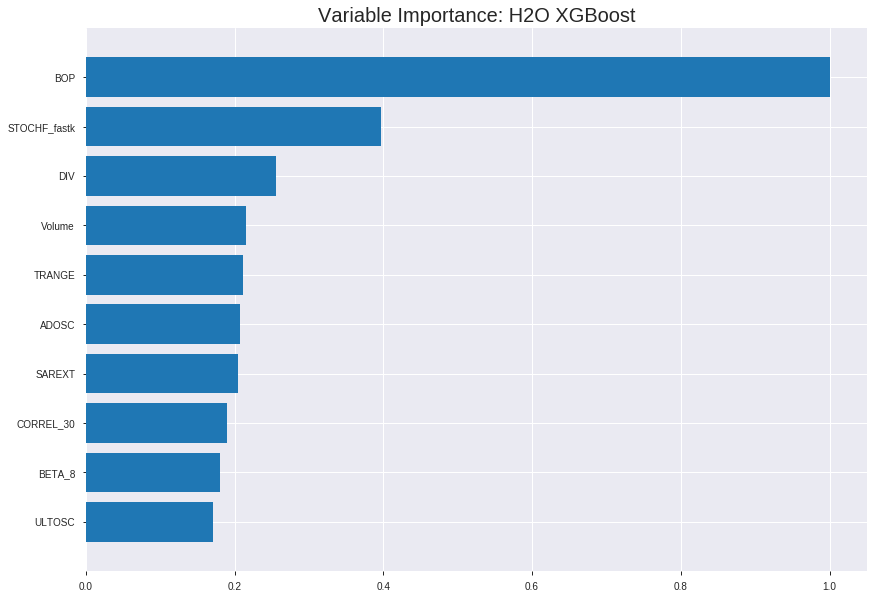

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_062408_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1266598164400882
RMSE: 0.35589298453339624
LogLoss: 0.41365743524317694
Mean Per-Class Error: 0.14644451156079064
AUC: 0.9333501124198799
pr_auc: 0.935280004285539
Gini: 0.8667002248397597
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5056730508804321: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      633  137  0.1779   (137.0/770.0)
1      89   685  0.115    (89.0/774.0)
Total  722  822  0.1464   (226.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505673     0.858396  198
max f2                       0.350187     0.906798  268
max f0point5                 0.618582     0.864217  144
max accuracy                 0.514111     0.853627  196
max precision                0.963468     1         0
max recall                   0.195545     1         333
max specificity              0.963468     1         0
max absolute_mcc             0.505673     0.708576  198
max min_per_class_accuracy   0.533601     0.845455  188
max mean_per_class_accuracy  0.514111     0.853555  196

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.934433           1.99483    1.99483            1                0.943126  1                           0.943126            0.0206718       0.0206718                  99.4832   99.4832
    2        0.0200777                   0.923982           1.99483    1.99483            1                0.928541  1                           0.936068            0.0193798       0.0400517                  99.4832   99.4832
    3        0.0304404                   0.904513           1.99483    1.99483            1                0.911901  1                           0.927841            0.0206718       0.0607235                  99.4832   99.4832
    4        0.0401554                   0.891589           1.99483    1.99483            1                0.897917  1                           0.920601            0.0193798       0.0801034                  99.4832   99.4832
    5        0.0505181                   0.877808           1.99483    1.99483            1                0.884459  1                           0.913188            0.0206718       0.100775                   99.4832   99.4832
    6        0.100389                    0.82511            1.99483    1.99483            1                0.849651  1                           0.881624            0.0994832       0.200258                   99.4832   99.4832
    7        0.150259                    0.772535           1.96893    1.98623            0.987013         0.798114  0.99569                     0.853907            0.0981912       0.29845                    96.8925   98.6234
    8        0.20013                     0.736598           1.99483    1.98838            1                0.754887  0.996764                    0.829232            0.0994832       0.397933                   99.4832   98.8376
    9        0.29987                     0.671486           1.77462    1.91728            0.88961          0.703209  0.961123                    0.787315            0.177003        0.574935                   77.4623   91.7279
    10       0.400259                    0.60189            1.44143    1.79793            0.722581         0.637796  0.901294                    0.749815            0.144703        0.719638                   44.1427   79.7931
    11       0.5                         0.53324            1.26944    1.69251            0.636364         0.565019  0.848446                    0.712951            0.126615        0.846253                   26.9439   69.2506
    12       0.599741                    0.438348           0.854928   1.55321            0.428571         0.486704  0.778618                    0.675325            0.0852713       0.931525                   -14.5072  55.3212
    13       0.70013                     0.339799           0.437576   1.39325            0.219355         0.390462  0.698427                    0.634479            0.0439276       0.975452                   -56.2424  39.3245
    14       0.79987                     0.229511           0.207255   1.24536            0.103896         0.286614  0.624291                    0.591102            0.0206718       0.996124                   -79.2745  24.5357
    15       0.899611                    0.144315           0.0388604  1.11159            0.0194805        0.18272   0.557235                    0.545824            0.00387597      1                          -96.114   11.1591
    16       1                           0.0547467          0          1                  0                0.108045  0.501295                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18686279354584823
RMSE: 0.4322762930648039
LogLoss: 0.5512281253968401
Mean Per-Class Error: 0.2861092769891054
AUC: 0.7913193298118191
pr_auc: 0.7702821793374633
Gini: 0.5826386596236381
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35077959299087524: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      131  102  0.4378   (102.0/233.0)
1      28   180  0.1346   (28.0/208.0)
Total  159  282  0.2948   (130.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35078      0.734694  256
max f2                       0.165573     0.834711  343
max f0point5                 0.574894     0.718912  131
max accuracy                 0.546879     0.716553  151
max precision                0.951939     1         0
max recall                   0.114285     1         376
max specificity              0.951939     1         0
max absolute_mcc             0.35078      0.444571  256
max min_per_class_accuracy   0.461766     0.703863  198
max mean_per_class_accuracy  0.374064     0.713891  241

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 45.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.938621           2.12019   2.12019            1                0.944487  1                           0.944487            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.914835           2.12019   2.12019            1                0.930423  1                           0.938237            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.890933           2.12019   2.12019            1                0.905412  1                           0.926513            0.0240385       0.0673077                  112.019   112.019
    4        0.0408163                   0.868539           2.12019   2.12019            1                0.881704  1                           0.916556            0.0192308       0.0865385                  112.019   112.019
    5        0.0521542                   0.844164           1.69615   2.02801            0.8              0.851989  0.956522                    0.90252             0.0192308       0.105769                   69.6154   102.801
    6        0.102041                    0.738739           1.7347    1.88462            0.818182         0.78196   0.888889                    0.84358             0.0865385       0.192308                   73.4703   88.4615
    7        0.151927                    0.695907           1.7347    1.83539            0.818182         0.714914  0.865672                    0.801331            0.0865385       0.278846                   73.4703   83.539
    8        0.201814                    0.662701           1.54196   1.76286            0.727273         0.678962  0.831461                    0.771082            0.0769231       0.355769                   54.1958   76.2857
    9        0.301587                    0.595334           1.49377   1.67384            0.704545         0.624133  0.789474                    0.722468            0.149038        0.504808                   49.3772   67.3836
    10       0.401361                    0.515103           1.10828   1.53325            0.522727         0.555658  0.723164                    0.681001            0.110577        0.615385                   10.8282   53.3246
    11       0.501134                    0.459609           0.963724  1.41986            0.454545         0.483726  0.669683                    0.641724            0.0961538       0.711538                   -3.62762  41.9857
    12       0.600907                    0.374064           1.15647   1.37612            0.545455         0.414258  0.649057                    0.603956            0.115385        0.826923                   15.6469   37.6125
    13       0.70068                     0.307378           0.62642   1.26937            0.295455         0.343968  0.598706                    0.566935            0.0625          0.889423                   -37.358   26.9371
    14       0.800454                    0.224554           0.578234  1.18322            0.272727         0.262345  0.558074                    0.528969            0.0576923       0.947115                   -42.1766  18.3223
    15       0.900227                    0.134818           0.337303  1.08947            0.159091         0.174439  0.513854                    0.489676            0.0336538       0.980769                   -66.2697  8.94691
    16       1                           0.0754269          0.192745  1                  0.0909091        0.107446  0.471655                    0.45154           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:24:18  6.419 sec   0                  0.5              0.693147            0.5             0                  1                0.498705                         0.5                0.693147              0.5               0                    1                  0.528345
    2019-07-25 06:24:18  6.475 sec   5                  0.471101         0.636611            0.839876        0.808566           1.99483          0.246114                         0.47875            0.651211              0.75099           0.716904             2.12019            0.331066
    2019-07-25 06:24:18  6.516 sec   10                 0.449586         0.595353            0.857322        0.852886           1.99483          0.22215                          0.46228            0.618896              0.782859          0.769458             2.12019            0.281179
    2019-07-25 06:24:18  6.556 sec   15                 0.433915         0.564977            0.863681        0.863001           1.99483          0.235104                         0.452119           0.598241              0.786801          0.768557             2.12019            0.285714
    2019-07-25 06:24:19  6.601 sec   20                 0.42046          0.538457            0.870039        0.868267           1.99483          0.231218                         0.445289           0.583389              0.786367          0.764967             2.12019            0.29932
    2019-07-25 06:24:19  6.644 sec   25                 0.411638         0.520623            0.875425        0.875136           1.99483          0.222798                         0.441661           0.574926              0.785759          0.770656             2.12019            0.290249
    2019-07-25 06:24:19  6.685 sec   30                 0.403055         0.50368             0.884918        0.884866           1.99483          0.207254                         0.439777           0.570149              0.787069          0.769232             2.12019            0.29932
    2019-07-25 06:24:19  6.787 sec   35                 0.396273         0.489722            0.889147        0.887362           1.99483          0.196891                         0.438022           0.565349              0.786212          0.768443             2.12019            0.301587
    2019-07-25 06:24:19  6.851 sec   40                 0.390074         0.476913            0.894038        0.892875           1.99483          0.202073                         0.435571           0.559401              0.788039          0.770573             2.12019            0.294785
    2019-07-25 06:24:19  6.922 sec   45                 0.38498          0.466862            0.899014        0.89514            1.99483          0.189119                         0.434492           0.556716              0.789112          0.76948              2.12019            0.301587
    2019-07-25 06:24:19  6.983 sec   50                 0.377703         0.453583            0.909471        0.908935           1.99483          0.182642                         0.433505           0.554433              0.789823          0.770135             2.12019            0.297052
    2019-07-25 06:24:19  7.035 sec   55                 0.371854         0.442459            0.915495        0.916882           1.99483          0.175518                         0.432017           0.551244              0.79231           0.7

Variable Importances: 


variable       relative_importance    scaled_importance      percentage
-------------  ---------------------  ---------------------  ----------------------
BOP            1886.1092529296875     1.0                    0.18720172625218828
STOCHF_fastk   747.5961303710938      0.39636947287642804    0.07420104955613725
DIV            483.65972900390625     0.2564325095445235     0.048004608453915555
Volume         405.28228759765625     0.21487741866921684    0.04022542370749158
TRANGE         397.59857177734375     0.21080357416186532    0.03946279298323238
---            ---                    ---                    ---
weekday        14.329959869384766     0.007597629801733959   0.001422289414309668
CDLHANGINGMAN  5.635689735412598      0.0029879975015544295  0.0005593582903282148
CDLHAMMER      4.840034484863281      0.0025661474685759965  0.0004803872359351096
CDLDOJI        2.8852624893188477     0.0015297430330916296  0.0002863705365170114
CDLBELTHOLD    2.0345053672790527     0.0010786784297457117  0.00020193046411939703


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7420814479638009)

('F1', 0.72)

('auc', 0.7685550082101806)

('logloss', 0.5814216484306233)

('mean_per_class_error', 0.26330049261083743)

('rmse', 0.4426938662090026)

('mse', 0.19597785917907426)

xgboost prediction progress: |████████████████████████████████████████████| 100%


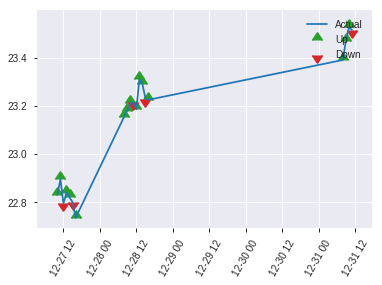


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19597785917907426
RMSE: 0.4426938662090026
LogLoss: 0.5814216484306233
Mean Per-Class Error: 0.26330049261083743
AUC: 0.7685550082101806
pr_auc: 0.7369711345546355
Gini: 0.5371100164203613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4425053596496582: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   39   0.3362   (39.0/116.0)
1      24   81   0.2286   (24.0/105.0)
Total  101  120  0.2851   (63.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442505     0.72      119
max f2                       0.167044     0.831974  192
max f0point5                 0.572828     0.748299  83
max accuracy                 0.572828     0.742081  83
max precision                0.934971     1         0
max recall                   0.0600458    1         220
max specificity              0.934971     1         0
max absolute_mcc             0.572828     0.487025  83
max min_per_class_accuracy   0.486516     0.704762  106
max mean_per_class_accuracy  0.572828     0.7367    83

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 46.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.924478           2.10476   2.10476            1                0.931652  1                           0.931652            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.899388           1.05238   1.68381            0.5              0.908878  0.8                         0.922542            0.00952381      0.0380952                  5.2381    68.381
    3        0.0316742                   0.876418           2.10476   1.80408            1                0.896716  0.857143                    0.915163            0.0190476       0.0571429                  110.476   80.4082
    4        0.040724                    0.858945           2.10476   1.8709             1                0.861407  0.888889                    0.903218            0.0190476       0.0761905                  110.476   87.0899
    5        0.0542986                   0.835847           1.40317   1.75397            0.666667         0.848993  0.833333                    0.889662            0.0190476       0.0952381                  40.3175   75.3968
    6        0.104072                    0.776237           1.91342   1.83023            0.909091         0.802222  0.869565                    0.847843            0.0952381       0.190476                   91.342    83.0228
    7        0.153846                    0.726263           1.33939   1.67143            0.636364         0.746306  0.794118                    0.814993            0.0666667       0.257143                   33.9394   67.1429
    8        0.20362                     0.693409           1.91342   1.73058            0.909091         0.712403  0.822222                    0.789915            0.0952381       0.352381                   91.342    73.0582
    9        0.303167                    0.631112           1.53074   1.66496            0.727273         0.660094  0.791045                    0.747287            0.152381        0.504762                   53.0736   66.4961
    10       0.402715                    0.557205           1.24372   1.56083            0.590909         0.588717  0.741573                    0.70809             0.12381         0.628571                   24.3723   56.0835
    11       0.502262                    0.46683            0.95671   1.4411             0.454545         0.515522  0.684685                    0.669923            0.0952381       0.72381                    -4.329    44.1098
    12       0.60181                     0.394915           0.669697  1.3135             0.318182         0.430072  0.62406                     0.630249            0.0666667       0.790476                   -33.0303  31.3498
    13       0.701357                    0.297403           0.765368  1.2357             0.363636         0.349963  0.587097                    0.590466            0.0761905       0.866667                   -23.4632  23.5699
    14       0.800905                    0.220867           0.478355  1.14157            0.227273         0.256892  0.542373                    0.549005            0.047619        0.914286                   -52.1645  14.1566
    15       0.900452                    0.133584           0.574026  1.07882            0.272727         0.17757   0.512563                    0.507942            0.0571429       0.971429                   -42.5974  7.88227
    16       1                           0.0600458          0.287013  1                  0.136364         0.101036  0.475113                    0.467435          

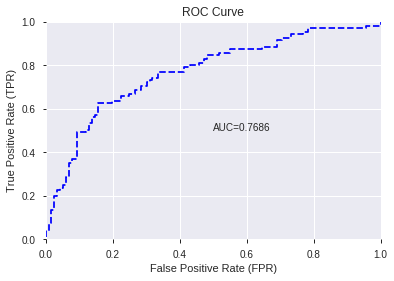

This function is available for GLM models only


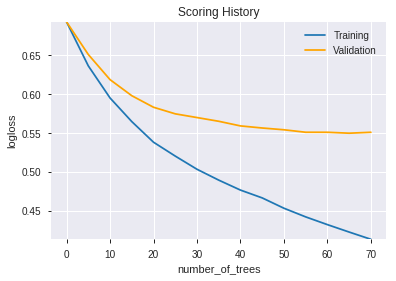

--2019-07-25 06:24:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

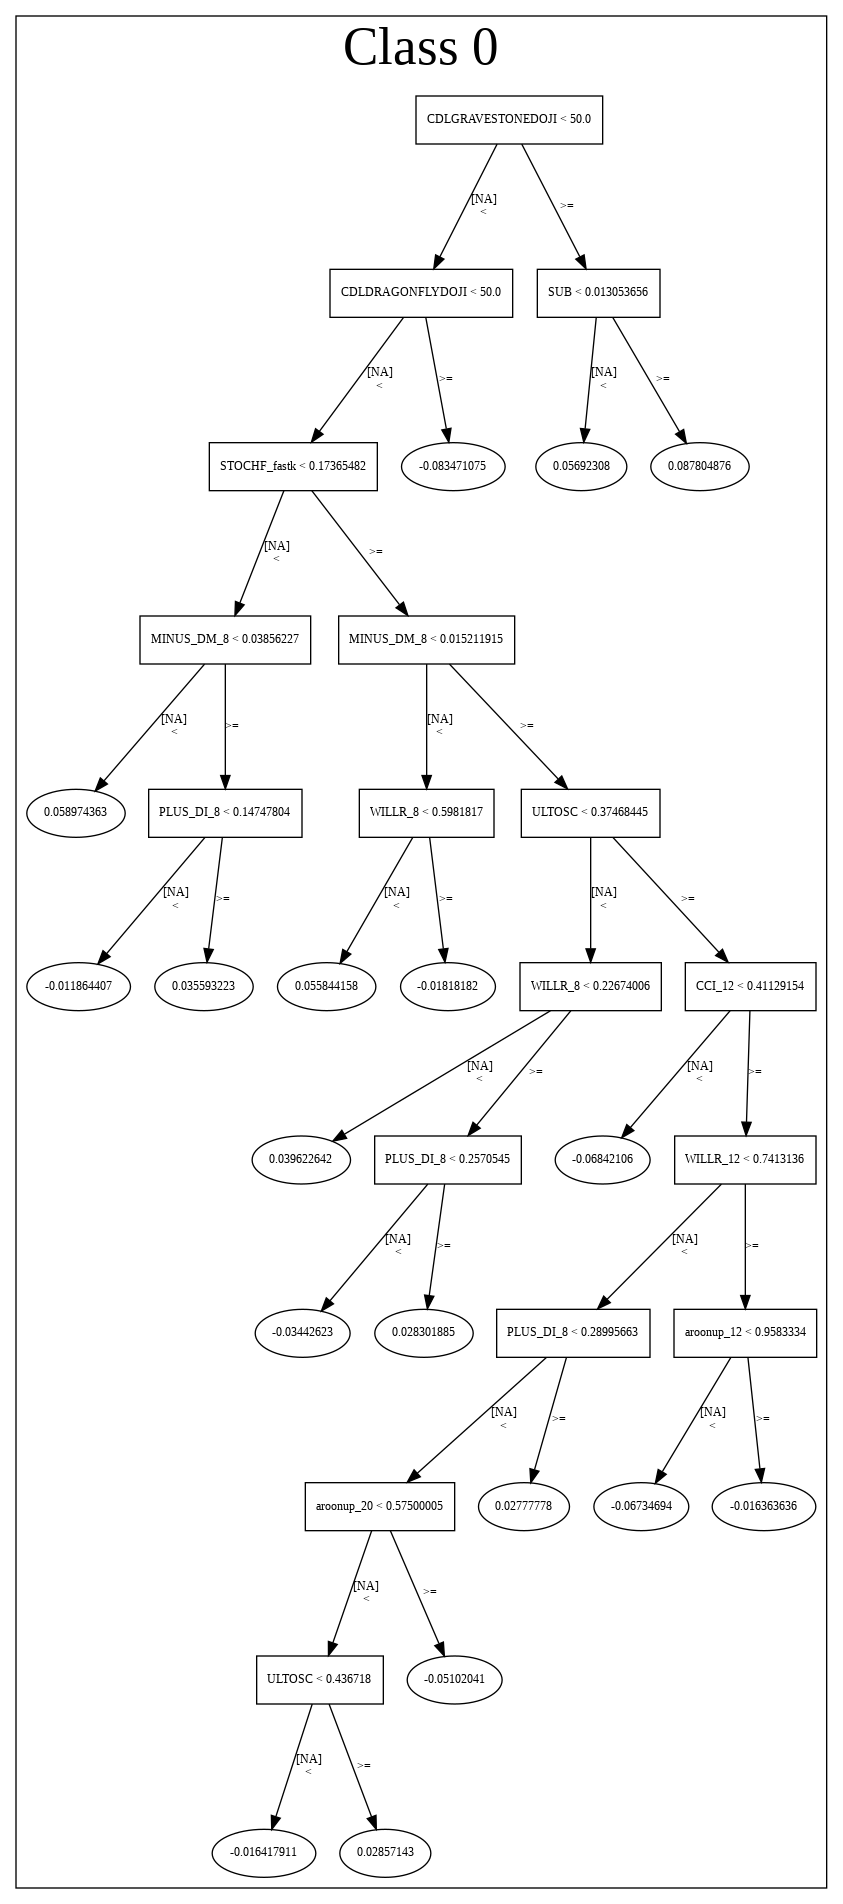

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_062408_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_062408_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'Volume',
 'TRANGE',
 'ADOSC',
 'SAREXT',
 'CORREL_30',
 'BETA_8',
 'ULTOSC',
 'STOCH_slowd',
 'DX_8',
 'HT_DCPERIOD',
 'hour',
 'STOCHRSI_fastd',
 'WILLR_8',
 'CORREL_12',
 'CORREL_20',
 'CORREL_24',
 'SUB',
 'WILLR_12',
 'aroonup_8',
 'WILLR_20',
 'WILLR_24',
 'day',
 'CDLLONGLINE',
 'WILLR_14',
 'dayofweek',
 'aroonup_24',
 'AROONOSC_8',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'weekday_name',
 'HT_TRENDMODE',
 'CDLSPINNINGTOP',
 'weekday',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CDLDOJI',
 'CDLBELTHOLD']

In [0]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190725_062434_model_1  0.748276  0.616036              0.286494  0.458017  0.20978

variable  relative_importance  scaled_importance    percentage
0                          BOP         4.241219e-01           1.000000  2.788269e-02
1           CDLCLOSINGMARUBOZU         2.658133e-01           0.626738  1.747514e-02
2                  CDLLONGLINE         2.638349e-01           0.622073  1.734508e-02
3                        CCI_8         2.500800e-01           0.589642  1.644080e-02
4                 STOCHF_fastk         2.243202e-01           0.528905  1.474729e-02
...                        ...                  ...                ...           ...
1030                 PLUS_DI_8         2.304333e-05           0.000054  1.514918e-06
1031   BBANDS_middleband_8_1_4         1.407105e-05           0.000033  9.250609e-07
1032                    VAR_30         8.272274e-06           0.000020  5.438371e-07
1033                    MA_8_0         6.563935e-06           0.000015  4.315273e-07
1034  BBANDS_middleband_24_2_4         5.889360e-07           0.000001  3.871792e-08

[1035 rows x 4 columns]

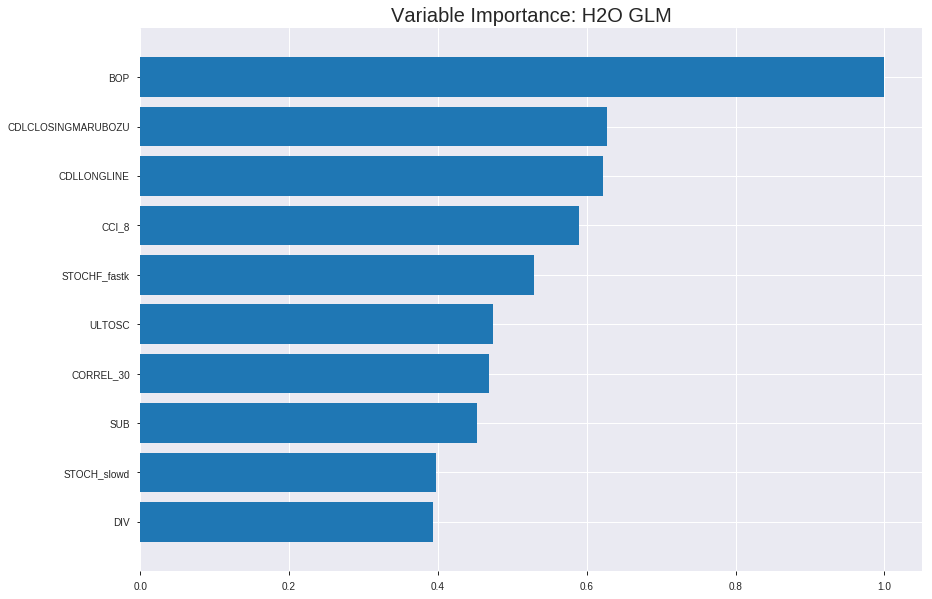

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_062434_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1772338434480247
RMSE: 0.42099150044629724
LogLoss: 0.5300615277930152
Null degrees of freedom: 1543
Residual degrees of freedom: 508
Null deviance: 2140.428130863218
Residual deviance: 1636.829997824831
AIC: 3708.829997824831
AUC: 0.8155156213295748
pr_auc: 0.8030965323650923
Gini: 0.6310312426591496
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4238858053965291: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      460  310  0.4026   (310.0/770.0)
1      101  673  0.1305   (101.0/774.0)
Total  561  983  0.2662   (411.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423886     0.766079  240
max f2                       0.305238     0.856676  292
max f0point5                 0.53419      0.749319  186
max accuracy                 0.514899     0.742876  196
max precision                0.971002     1         0
max recall                   0.088578     1         377
max specificity              0.971002     1         0
max absolute_mcc             0.514899     0.485767  196
max min_per_class_accuracy   0.513529     0.741558  197
max mean_per_class_accuracy  0.514899     0.742882  196

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.935663           1.87016   1.87016            0.9375           0.947886   0.9375                      0.947886            0.0193798       0.0193798                  87.0155   87.0155
    2        0.0200777                   0.909184           1.86184   1.86613            0.933333         0.920491   0.935484                    0.93463             0.0180879       0.0374677                  86.1843   86.6133
    3        0.0304404                   0.894597           1.99483   1.90995            1                0.901171   0.957447                    0.92324             0.0206718       0.0581395                  99.4832   90.9946
    4        0.0401554                   0.880775           1.72885   1.86613            0.866667         0.886784   0.935484                    0.91442             0.0167959       0.0749354                  72.8854   86.6133
    5        0.0505181                   0.873224           1.6208    1.81581            0.8125           0.877546   0.910256                    0.906856            0.0167959       0.0917313                  62.0801   81.5809
    6        0.100389                    0.813222           1.81348   1.81465            0.909091         0.843816   0.909677                    0.875539            0.0904393       0.182171                   81.3484   81.4654
    7        0.150259                    0.763065           1.65804   1.76267            0.831169         0.787113   0.883621                    0.846191            0.0826873       0.264858                   65.8042   76.2675
    8        0.20013                     0.720025           1.52851   1.70432            0.766234         0.740987   0.854369                    0.819975            0.0762274       0.341085                   52.8508   70.4323
    9        0.29987                     0.650171           1.51555   1.64154            0.75974          0.684284   0.822894                    0.774842            0.151163        0.492248                   51.5554   64.1536
    10       0.400259                    0.576622           1.17116   1.52356            0.587097         0.614164   0.763754                    0.734543            0.117571        0.609819                   17.1159   52.3561
    11       0.5                         0.513433           1.33421   1.48579            0.668831         0.54494    0.744819                    0.69672             0.133075        0.742894                   33.4206   48.5788
    12       0.599741                    0.450968           0.880835  1.38518            0.441558         0.481476   0.694384                    0.660924            0.0878553       0.830749                   -11.9165  38.518
    13       0.70013                     0.371295           0.759323  1.29544            0.380645         0.412      0.649399                    0.625232            0.0762274       0.906977                   -24.0677  29.5441
    14       0.79987                     0.270537           0.479278  1.19367            0.24026          0.320841   0.598381                    0.587275            0.0478036       0.95478                    -52.0722  19.3669
    15       0.899611                    0.164124           0.297929  1.09436            0.149351         0.216734   0.548596                    0.546193            0.0297158       0.984496                   -70.2071  9.43571
    16       1                           0.00417181         0.154439  1                  0.0774194        0.0989547  0.501295                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19506198220026671
RMSE: 0.4416582187622763
LogLoss: 0.5699871268965422
Null degrees of freedom: 440
Residual degrees of freedom: -595
Null deviance: 611.4883070433551
Residual deviance: 502.7286459227502
AIC: 2574.7286459227503
AUC: 0.7691379168042258
pr_auc: 0.7446620391200249
Gini: 0.5382758336084517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4577384151639476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  91   0.3906   (91.0/233.0)
1      42   166  0.2019   (42.0/208.0)
Total  184  257  0.3016   (133.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457738     0.713978  234
max f2                       0.260291     0.835432  324
max f0point5                 0.520567     0.685634  197
max accuracy                 0.520567     0.705215  197
max precision                0.920465     1         0
max recall                   0.089459     1         381
max specificity              0.920465     1         0
max absolute_mcc             0.457738     0.412555  234
max min_per_class_accuracy   0.520567     0.703863  197
max mean_per_class_accuracy  0.503174     0.706328  205

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 49.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.88832            2.12019   2.12019            1                0.900072  1                           0.900072            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.876321           2.12019   2.12019            1                0.885006  1                           0.893376            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.864589           1.69615   1.96875            0.8              0.870082  0.928571                    0.885056            0.0192308       0.0625                     69.6154   96.875
    4        0.0408163                   0.856753           2.12019   2.0024             1                0.861407  0.944444                    0.879801            0.0192308       0.0817308                  112.019   100.24
    5        0.0521542                   0.845372           2.12019   2.02801            1                0.849735  0.956522                    0.873265            0.0240385       0.105769                   112.019   102.801
    6        0.102041                    0.778694           1.83108   1.93173            0.863636         0.810892  0.911111                    0.842771            0.0913462       0.197115                   83.1075   93.1731
    7        0.151927                    0.745952           1.63833   1.83539            0.772727         0.766556  0.865672                    0.817745            0.0817308       0.278846                   63.833    83.539
    8        0.201814                    0.698715           1.15647   1.66757            0.545455         0.720274  0.786517                    0.793651            0.0576923       0.336538                   15.6469   66.7567
    9        0.301587                    0.639373           1.3974    1.57819            0.659091         0.666031  0.744361                    0.751431            0.139423        0.475962                   39.7399   57.8188
    10       0.401361                    0.581405           1.10828   1.46138            0.522727         0.607575  0.689266                    0.71567             0.110577        0.586538                   10.8282   46.1375
    11       0.501134                    0.509051           1.30103   1.42945            0.613636         0.546015  0.674208                    0.681893            0.129808        0.716346                   30.1027   42.9451
    12       0.600907                    0.430006           0.915538  1.34412            0.431818         0.475326  0.633962                    0.647595            0.0913462       0.807692                   -8.44624  34.4122
    13       0.70068                     0.36489            0.674607  1.24879            0.318182         0.397848  0.588997                    0.612032            0.0673077       0.875                      -32.5393  24.8786
    14       0.800454                    0.270893           0.722793  1.18322            0.340909         0.318353  0.558074                    0.575426            0.0721154       0.947115                   -27.7207  18.3223
    15       0.900227                    0.148169           0.38549   1.09481            0.181818         0.213292  0.516373                    0.53529             0.0384615       0.985577                   -61.451   9.48096
    16       1                           0.00952917         0.144559  1                  0.0681818        0.087867  0.471655                    0.49065             


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 06:24:37  0.000 sec   2            .2E2      1034          1.3510595780434542  1.3616967110436697
     2019-07-25 06:24:38  1.756 sec   4            .14E2     1036          1.3437127678752931  1.3556993294962114
     2019-07-25 06:24:40  3.532 sec   6            .1E2      1036          1.334961550572307   1.3479770331904766
     2019-07-25 06:24:42  5.259 sec   8            .76E1     1036          1.3245944522899156  1.338374113277637
     2019-07-25 06:24:44  7.035 sec   10           .55E1     1036          1.3124279723291006  1.3267496583299039
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 06:25:14  37.073 sec  44           .25E-1    1036          1.050274405057318   1.1404558212711011
     2019-07-25 06:25:15  38.931 sec  46           .18E-1    1036          1.041393424501308   1.1425569248148646
     2019-07-25 06:25:17  40.670 sec  48           .13E-1    1036          1.033346485495314   1.146164040706723
     2019-07-25 06:25:19  42.416 sec  50           .97E-2    1036          1.02605741378055    1.1511938543120535
     2019-07-25 06:25:21  44.165 sec  52           .7E-2     1036          1.0193978000961534  1.1575720281027844


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7058823529411765)

('F1', 0.7368421052631579)

('auc', 0.7482758620689655)

('logloss', 0.6160361983615391)

('mean_per_class_error', 0.2864942528735632)

('rmse', 0.45801723752830104)

('mse', 0.20977978987305615)

glm prediction progress: |████████████████████████████████████████████████| 100%


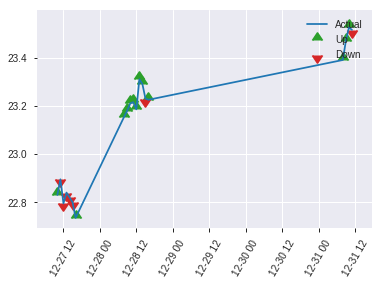


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20977978987305615
RMSE: 0.45801723752830104
LogLoss: 0.6160361983615391
Null degrees of freedom: 220
Residual degrees of freedom: -815
Null deviance: 306.4295320199308
Residual deviance: 272.2879996758003
AIC: 2344.2879996758
AUC: 0.7482758620689655
pr_auc: 0.6890881092310772
Gini: 0.4965517241379309
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4550421094109228: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   51   0.4397   (51.0/116.0)
1      14   91   0.1333   (14.0/105.0)
Total  79   142  0.2941   (65.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455042     0.736842  141
max f2                       0.177516     0.825243  197
max f0point5                 0.668001     0.694118  79
max accuracy                 0.5912       0.705882  111
max precision                0.88368      0.875     7
max recall                   0.0468345    1         216
max specificity              0.944159     0.991379  0
max absolute_mcc             0.455042     0.444944  141
max min_per_class_accuracy   0.606869     0.689655  108
max mean_per_class_accuracy  0.455042     0.713506  141

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 53.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.928931           1.40317   1.40317            0.666667         0.940265   0.666667                    0.940265            0.0190476       0.0190476                  40.3175   40.3175
    2        0.0226244                   0.897701           2.10476   1.68381            1                0.908017   0.8                         0.927366            0.0190476       0.0380952                  110.476   68.381
    3        0.0316742                   0.883844           2.10476   1.80408            1                0.887689   0.857143                    0.916029            0.0190476       0.0571429                  110.476   80.4082
    4        0.040724                    0.879216           1.05238   1.63704            0.5              0.882707   0.777778                    0.908624            0.00952381      0.0666667                  5.2381    63.7037
    5        0.0542986                   0.867363           2.10476   1.75397            1                0.872491   0.833333                    0.899591            0.0285714       0.0952381                  110.476   75.3968
    6        0.104072                    0.82731            1.14805   1.46418            0.545455         0.844866   0.695652                    0.873419            0.0571429       0.152381                   14.8052   46.4182
    7        0.153846                    0.768002           1.72208   1.54762            0.818182         0.7932     0.735294                    0.847466            0.0857143       0.238095                   72.2078   54.7619
    8        0.20362                     0.744651           2.10476   1.68381            1                0.757237   0.8                         0.82541             0.104762        0.342857                   110.476   68.381
    9        0.303167                    0.691541           1.24372   1.5393             0.590909         0.713286   0.731343                    0.788593            0.12381         0.466667                   24.3723   53.9303
    10       0.402715                    0.645433           1.24372   1.46624            0.590909         0.667709   0.696629                    0.758712            0.12381         0.590476                   24.3723   46.6239
    11       0.502262                    0.599933           1.24372   1.42214            0.590909         0.621726   0.675676                    0.731561            0.12381         0.714286                   24.3723   42.2136
    12       0.60181                     0.506334           0.765368  1.3135             0.363636         0.554731   0.62406                     0.702311            0.0761905       0.790476                   -23.4632  31.3498
    13       0.701357                    0.410784           0.95671   1.26286            0.454545         0.447196   0.6                         0.666101            0.0952381       0.885714                   -4.329    26.2857
    14       0.800905                    0.310505           0.287013  1.14157            0.136364         0.359461   0.542373                    0.627988            0.0285714       0.914286                   -71.2987  14.1566
    15       0.900452                    0.158833           0.574026  1.07882            0.272727         0.246694   0.512563                    0.585835            0.0571429       0.971429                   -42.5974  7.88227
    16       1                           0.0214884          0.287013  1                  0.136364         0.0846207  0.475113                    0

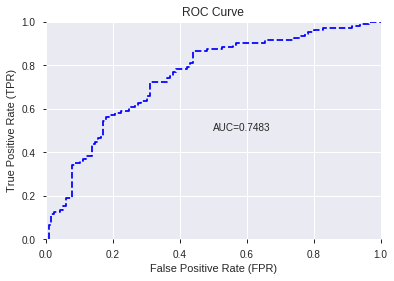

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


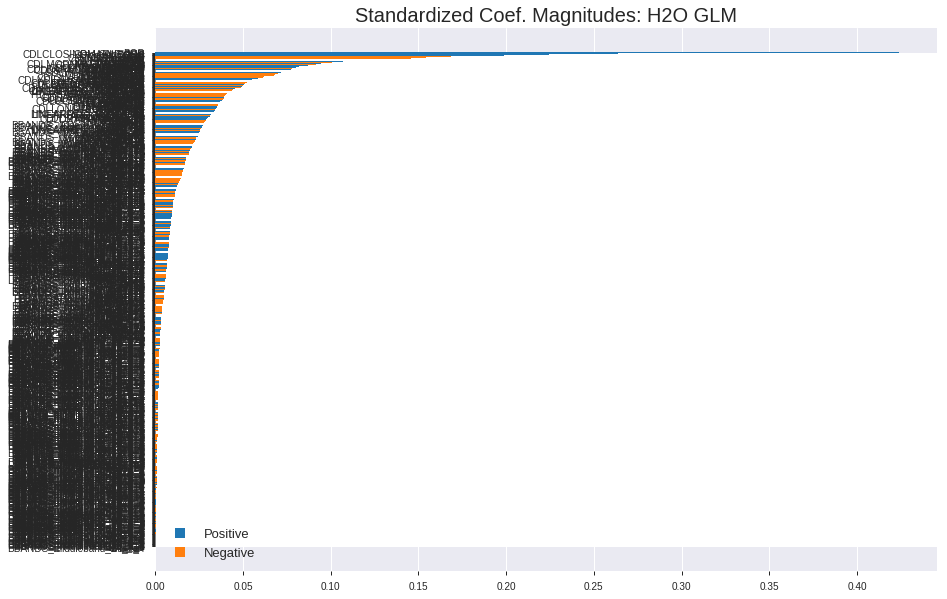

'log_likelihood'
--2019-07-25 06:25:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


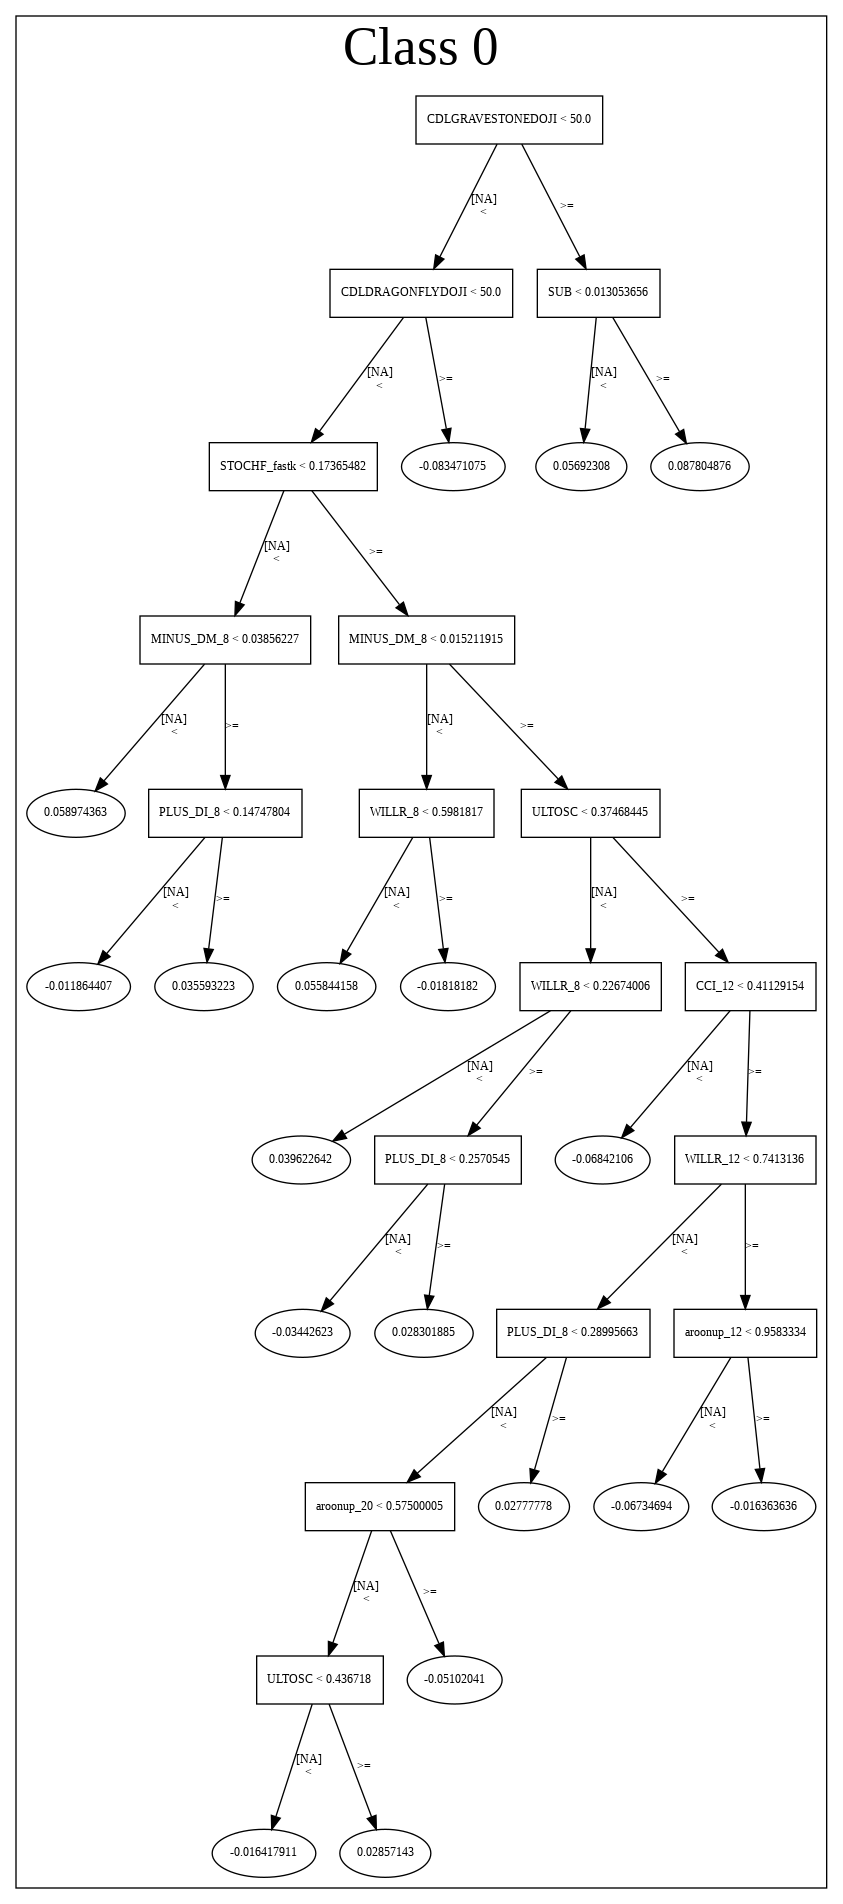

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_062434_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_062434_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

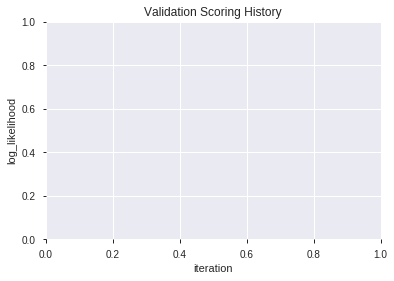

In [0]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [0]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [0]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [0]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190725_062553  0.751149  0.591453              0.304187  0.449526  0.202074
1  XGBoost_grid_1_AutoML_20190725_062553_model_4  0.744171  0.602454              0.293514  0.453979  0.206097
2  XGBoost_grid_1_AutoML_20190725_062553_model_3  0.739737  0.606308              0.279228  0.455872  0.207820
3  XGBoost_grid_1_AutoML_20190725_062553_model_5  0.738259  0.611715              0.293514  0.457821  0.209600
4  XGBoost_grid_1_AutoML_20190725_062553_model_2  0.736043  0.604441              0.306897  0.455652  0.207619
5               XGBoost_1_AutoML_20190725_062553  0.733415  0.612538              0.308498  0.457923  0.209693
6               XGBoost_2_AutoML_20190725_062553  0.733251  0.607339              0.320977  0.457195  0.209027
7  XGBoost_grid_1_AutoML_20190725_062553_model_7  0.729310  0.619565              0.311658  0.461877  0.213331
8  XGBoost_grid_1_AutoML_20190725_062553_model_6  0.724056  0.612669              0.298276  0.459738  0.211359
9  XGBoost_grid_1_AutoML_20190725_062553_model_1  0.723892  0.616644              0.315066  0.460956  0.212480

variable  relative_importance  scaled_importance  percentage
0                        BOP          1694.600952           1.000000    0.182500
1               STOCHF_fastk           759.052063           0.447924    0.081746
2                     TRANGE           258.441132           0.152509    0.027833
3                        DIV           256.396088           0.151302    0.027613
4             STOCHRSI_fastk           208.041107           0.122767    0.022405
..                       ...                  ...                ...         ...
315   BBANDS_upperband_8_2_3             0.461639           0.000272    0.000050
316               aroonup_24             0.417055           0.000246    0.000045
317  BBANDS_middleband_8_3_2             0.309330           0.000183    0.000033
318  BBANDS_upperband_30_6_5             0.281558           0.000166    0.000030
319  BBANDS_lowerband_24_1_3             0.204055           0.000120    0.000022

[320 rows x 4 columns]

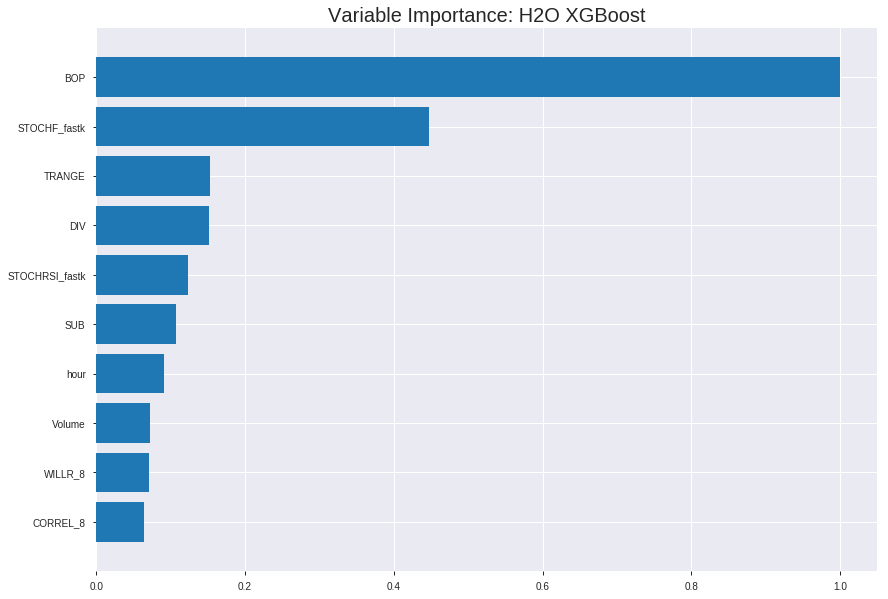

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190725_062553


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11514894209085146
RMSE: 0.3393360312298879
LogLoss: 0.3886887415645842
Mean Per-Class Error: 0.11456256921373198
AUC: 0.9580766133091715
pr_auc: 0.9588939278682919
Gini: 0.916153226618343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5293959379196167: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      680  90   0.1169   (90.0/770.0)
1      89   685  0.115    (89.0/774.0)
Total  769  775  0.1159   (179.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529396     0.884442  193
max f2                       0.385225     0.921181  258
max f0point5                 0.607956     0.911411  159
max accuracy                 0.556332     0.885363  181
max precision                0.967316     1         0
max recall                   0.276654     1         304
max specificity              0.967316     1         0
max absolute_mcc             0.556332     0.772071  181
max min_per_class_accuracy   0.529396     0.883117  193
max mean_per_class_accuracy  0.556332     0.885437  181

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.926184           1.99483    1.99483            1                0.94578   1                           0.94578             0.0206718       0.0206718                  99.4832   99.4832
    2        0.0200777                   0.91068            1.99483    1.99483            1                0.918303  1                           0.932485            0.0193798       0.0400517                  99.4832   99.4832
    3        0.0304404                   0.897259           1.99483    1.99483            1                0.903708  1                           0.922688            0.0206718       0.0607235                  99.4832   99.4832
    4        0.0401554                   0.885666           1.99483    1.99483            1                0.891566  1                           0.915159            0.0193798       0.0801034                  99.4832   99.4832
    5        0.0505181                   0.876295           1.99483    1.99483            1                0.881938  1                           0.908344            0.0206718       0.100775                   99.4832   99.4832
    6        0.100389                    0.829352           1.99483    1.99483            1                0.852628  1                           0.880666            0.0994832       0.200258                   99.4832   99.4832
    7        0.150259                    0.775296           1.96893    1.98623            0.987013         0.803818  0.99569                     0.855161            0.0981912       0.29845                    96.8925   98.6234
    8        0.20013                     0.738153           1.99483    1.98838            1                0.756283  0.996764                    0.830521            0.0994832       0.397933                   99.4832   98.8376
    9        0.29987                     0.674624           1.91711    1.96467            0.961039         0.705619  0.984881                    0.788977            0.191214        0.589147                   91.7111   96.4673
    10       0.400259                    0.615336           1.73743    1.90768            0.870968         0.647721  0.956311                    0.753549            0.174419        0.763566                   73.7434   90.7679
    11       0.5                         0.52972            1.20467    1.76744            0.603896         0.574192  0.88601                     0.71777             0.120155        0.883721                   20.4671   76.7442
    12       0.599741                    0.437829           0.660626   1.58337            0.331169         0.485385  0.793737                    0.679123            0.0658915       0.949612                   -33.9374  58.3371
    13       0.70013                     0.341056           0.411836   1.41539            0.206452         0.384722  0.709528                    0.63691             0.0413437       0.990956                   -58.8164  41.539
    14       0.79987                     0.220616           0.0906742  1.2502             0.0454545        0.282139  0.626721                    0.592671            0.00904393      1                          -90.9326  25.0202
    15       0.899611                    0.141563           0          1.11159            0                0.180149  0.557235                    0.546935            0               1                          -100      11.1591
    16       1                           0.0527457          0          1                  0                0.104363  0.501295                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18268396495048553
RMSE: 0.42741544772093293
LogLoss: 0.5431108782938641
Mean Per-Class Error: 0.2645675140310333
AUC: 0.8051233905579399
pr_auc: 0.7885723249663685
Gini: 0.6102467811158798
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4004562199115753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  85   0.3648   (85.0/233.0)
1      37   171  0.1779   (37.0/208.0)
Total  185  256  0.2766   (122.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400456     0.737069  234
max f2                       0.244868     0.846088  313
max f0point5                 0.602557     0.729167  109
max accuracy                 0.413721     0.732426  221
max precision                0.942615     1         0
max recall                   0.106093     1         388
max specificity              0.942615     1         0
max absolute_mcc             0.413721     0.471595  221
max min_per_class_accuracy   0.44718      0.711538  198
max mean_per_class_accuracy  0.413721     0.735432  221

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 44.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.898551           2.12019   2.12019            1                0.918687  1                           0.918687            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.88247            2.12019   2.12019            1                0.886106  1                           0.904207            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.859893           2.12019   2.12019            1                0.870914  1                           0.892316            0.0240385       0.0673077                  112.019   112.019
    4        0.0408163                   0.844295           2.12019   2.12019            1                0.852589  1                           0.883488            0.0192308       0.0865385                  112.019   112.019
    5        0.0521542                   0.825702           2.12019   2.12019            1                0.836326  1                           0.873235            0.0240385       0.110577                   112.019   112.019
    6        0.102041                    0.735949           1.63833   1.88462            0.772727         0.77193   0.888889                    0.823708            0.0817308       0.192308                   63.833    88.4615
    7        0.151927                    0.682812           1.83108   1.86704            0.863636         0.709772  0.880597                    0.786296            0.0913462       0.283654                   83.1075   86.7035
    8        0.201814                    0.642695           1.83108   1.85815            0.863636         0.663032  0.876404                    0.755826            0.0913462       0.375                      83.1075   85.8146
    9        0.301587                    0.567829           1.30103   1.67384            0.613636         0.605532  0.789474                    0.706105            0.129808        0.504808                   30.1027   67.3836
    10       0.401361                    0.50489            1.15647   1.54522            0.545455         0.535702  0.728814                    0.663745            0.115385        0.620192                   15.6469   54.5225
    11       0.501134                    0.432289           1.10828   1.45823            0.522727         0.466485  0.687783                    0.624472            0.110577        0.730769                   10.8282   45.8232
    12       0.600907                    0.379666           1.01191   1.38413            0.477273         0.40986   0.65283                     0.588838            0.100962        0.831731                   1.191     38.4126
    13       0.70068                     0.310468           0.62642   1.27623            0.295455         0.350189  0.601942                    0.554856            0.0625          0.894231                   -37.358   27.6232
    14       0.800454                    0.236566           0.62642   1.19524            0.295455         0.268193  0.563739                    0.519124            0.0625          0.956731                   -37.358   19.5236
    15       0.900227                    0.153292           0.240931  1.08947            0.113636         0.196228  0.513854                    0.483337            0.0240385       0.980769                   -75.9069  8.94691
    16       1                           0.049852           0.192745  1                  0.0909091        0.121506  0.471655                    0.447236         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:26:05  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.498705                         0.5                0.693147              0.5               0                    1                  0.528345
    2019-07-25 06:26:06  0.625 sec   5                  0.470812         0.6361              0.860156        0.847345           1.99483          0.237694                         0.47862            0.651016              0.78026           0.763665             2.12019            0.315193
    2019-07-25 06:26:06  0.810 sec   10                 0.448418         0.593326            0.869323        0.858582           1.99483          0.223446                         0.462634           0.619797              0.799944          0.786831             2.12019            0.278912
    2019-07-25 06:26:06  1.007 sec   15                 0.431851         0.561595            0.876469        0.871694           1.99483          0.224741                         0.451419           0.597501              0.802771          0.790885             2.12019            0.260771
    2019-07-25 06:26:06  1.206 sec   20                 0.41691          0.532903            0.887891        0.883858           1.99483          0.205311                         0.444031           0.582259              0.803958          0.79227              2.12019            0.265306
    2019-07-25 06:26:07  1.398 sec   25                 0.406265         0.512276            0.897211        0.894227           1.99483          0.183938                         0.440273           0.573913              0.802255          0.790031             2.12019            0.283447
    2019-07-25 06:26:07  1.605 sec   30                 0.396607         0.493456            0.904177        0.901301           1.99483          0.177461                         0.437688           0.567831              0.79883           0.786278             2.12019            0.294785
    2019-07-25 06:26:07  1.793 sec   35                 0.387874         0.476702            0.912235        0.910961           1.99483          0.166451                         0.434309           0.560258              0.800027          0.786985             2.12019            0.301587
    2019-07-25 06:26:07  1.977 sec   40                 0.380308         0.462378            0.920138        0.920191           1.99483          0.159326                         0.432202           0.555731              0.802482          0.788779             2.12019            0.287982
    2019-07-25 06:26:07  2.158 sec   45                 0.373963         0.450341            0.926414        0.927129           1.99483          0.163212                         0.430227           0.551318              0.803772          0.790936             2.12019            0.287982
    2019-07-25 06:26:08  2.389 sec   50                 0.366698         0.43673             0.933574        0.934343           1.99483          0.150259                         0.428995           0.548357              0.804216          0.788755             2.12019            0.297052
    2019-07-25 06:26:08  2.597 sec   55                 0.359946         0.424372            0.939548        0.940462           1.99483          0.138601                         0.427173           0.543962              0.807094          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1694.6009521484375     1.0                     0.18249963446747922
STOCHF_fastk             759.0520629882812      0.4479237793569896      0.08174592600194241
TRANGE                   258.4411315917969      0.1525085485548334      0.0278327543644229
DIV                      256.3960876464844      0.15130174884029307     0.02761251385764383
STOCHRSI_fastk           208.04110717773438     0.12276701893385408     0.02240493608009047
---                      ---                    ---                     ---
BBANDS_upperband_8_2_3   0.461639404296875      0.000272417765204016    4.97161425721805e-05
aroonup_24               0.4170551300048828     0.00024610816456590255  4.491465007273944e-05
BBANDS_middleband_8_3_2  0.3093299865722656     0.00018253854170215884  3.33132171368707e-05
BBANDS_upperband_30_6_5  0.2815580368041992     0.00016615005228649035  3.0322323809037047e-05
BBANDS_lowerband_24_1_3  0.2040548324584961     0.00012041468063604749  2.1975635200596913e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7013574660633484)

('F1', 0.7228915662650602)

('auc', 0.7511494252873564)

('logloss', 0.5914525233099297)

('mean_per_class_error', 0.30209359605911335)

('rmse', 0.44952605236716936)

('mse', 0.20207367175681107)

xgboost prediction progress: |████████████████████████████████████████████| 100%


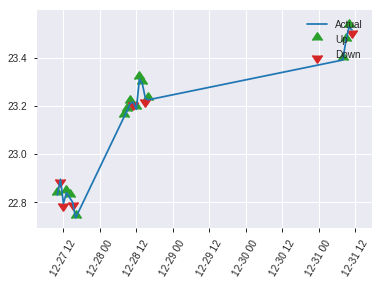


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20207367175681107
RMSE: 0.44952605236716936
LogLoss: 0.5914525233099297
Mean Per-Class Error: 0.30209359605911335
AUC: 0.7511494252873564
pr_auc: 0.7209663119340277
Gini: 0.5022988505747128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38823357224464417: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   54   0.4655   (54.0/116.0)
1      15   90   0.1429   (15.0/105.0)
Total  77   144  0.3122   (69.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388234     0.722892  143
max f2                       0.0988664    0.820313  219
max f0point5                 0.592932     0.69863   64
max accuracy                 0.511255     0.701357  92
max precision                0.934837     1         0
max recall                   0.0988664    1         219
max specificity              0.934837     1         0
max absolute_mcc             0.388234     0.410457  143
max min_per_class_accuracy   0.46513      0.67619   107
max mean_per_class_accuracy  0.511255     0.697906  92

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 46.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.904107           2.10476   2.10476            1                0.921445  1                           0.921445            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.900981           2.10476   2.10476            1                0.902158  1                           0.91373             0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.897302           2.10476   2.10476            1                0.898875  1                           0.909486            0.0190476       0.0666667                  110.476   110.476
    4        0.040724                    0.880125           1.05238   1.8709             0.5              0.888907  0.888889                    0.904913            0.00952381      0.0761905                  5.2381    87.0899
    5        0.0542986                   0.841244           2.10476   1.92937            1                0.860154  0.916667                    0.893723            0.0285714       0.104762                   110.476   92.9365
    6        0.104072                    0.761216           1.53074   1.73872            0.727273         0.784574  0.826087                    0.841521            0.0761905       0.180952                   53.0736   73.8716
    7        0.153846                    0.699425           1.53074   1.67143            0.727273         0.723358  0.794118                    0.803292            0.0761905       0.257143                   53.0736   67.1429
    8        0.20362                     0.666037           1.33939   1.59026            0.636364         0.679594  0.755556                    0.773055            0.0666667       0.32381                    33.9394   59.0265
    9        0.303167                    0.585128           1.72208   1.63355            0.818182         0.622619  0.776119                    0.723658            0.171429        0.495238                   72.2078   63.3547
    10       0.402715                    0.528731           1.05238   1.48989            0.5              0.553125  0.707865                    0.681504            0.104762        0.6                        5.2381    48.9888
    11       0.502262                    0.458172           0.861039  1.36525            0.409091         0.489528  0.648649                    0.643455            0.0857143       0.685714                   -13.8961  36.5251
    12       0.60181                     0.415344           1.14805   1.32932            0.545455         0.431586  0.631579                    0.608409            0.114286        0.8                        14.8052   32.9323
    13       0.701357                    0.349822           0.861039  1.26286            0.409091         0.383654  0.6                         0.576508            0.0857143       0.885714                   -13.8961  26.2857
    14       0.800905                    0.242603           0.287013  1.14157            0.136364         0.288607  0.542373                    0.540724            0.0285714       0.914286                   -71.2987  14.1566
    15       0.900452                    0.169354           0.382684  1.05767            0.181818         0.20848   0.502513                    0.503993            0.0380952       0.952381                   -61.7316  5.76693
    16       1                           0.0837698          0.478355  1                  0.227273         0.133294  0.475113                    0.467091         

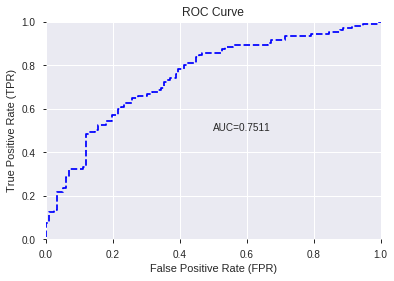

This function is available for GLM models only


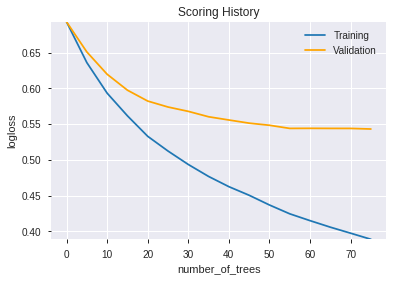

--2019-07-25 06:26:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

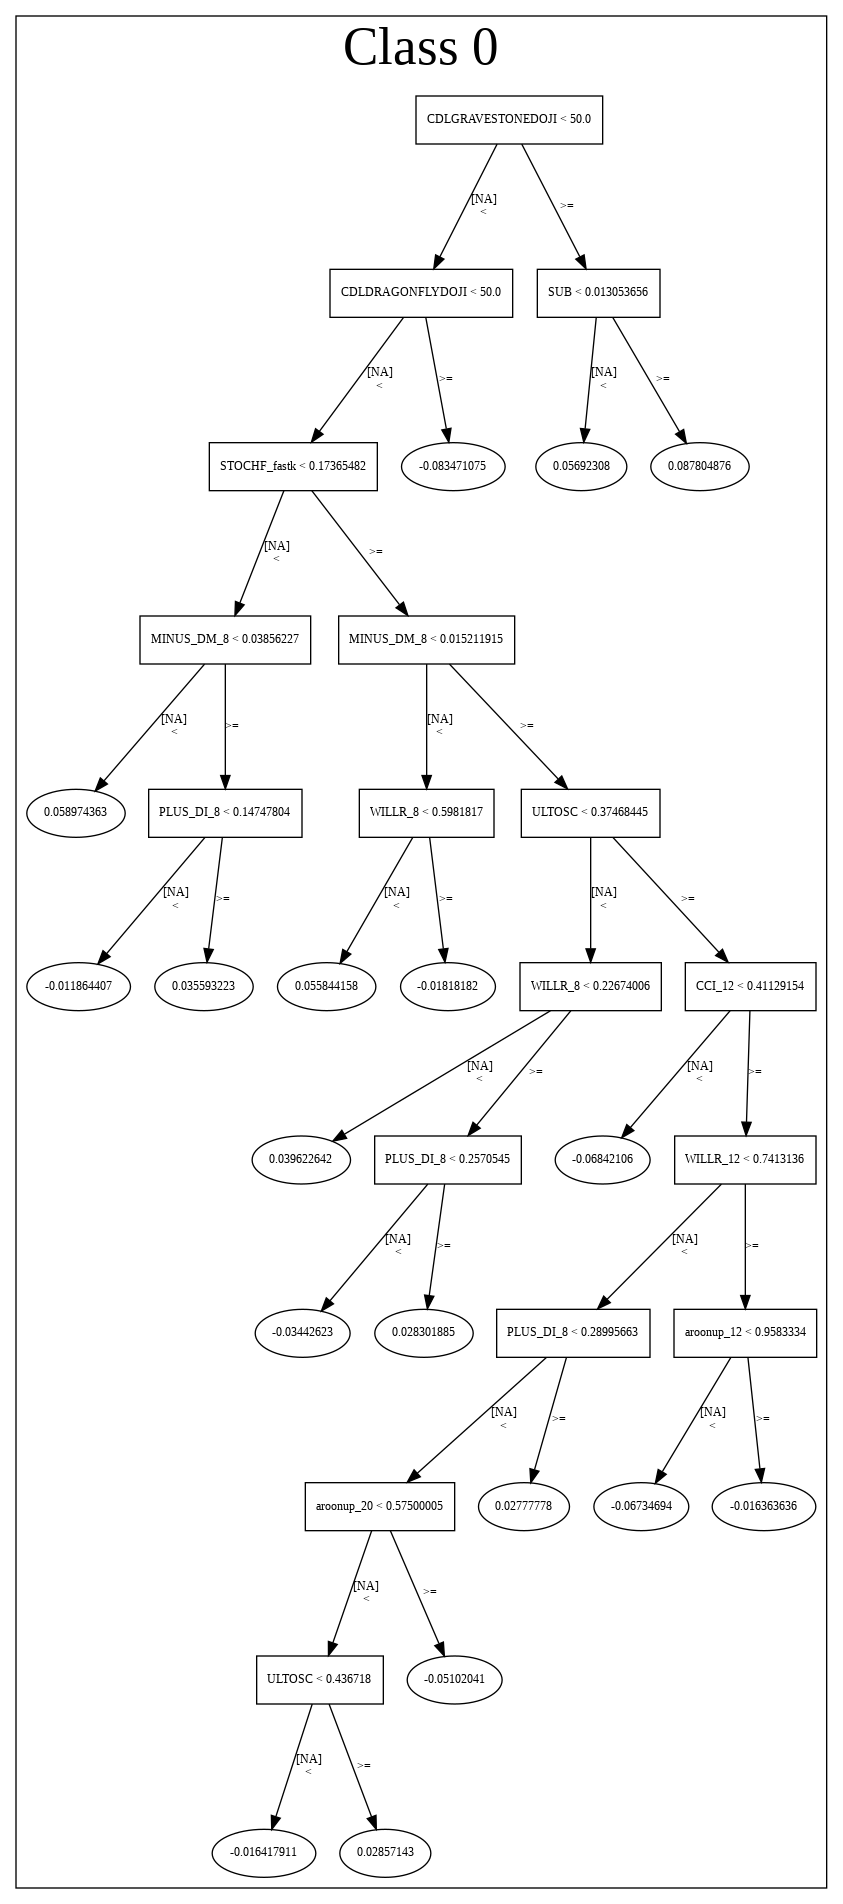

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190725_062553',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190725_062553',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a71d',
   'type

In [0]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_062657_model_9  0.769458  0.579510              0.300328  0.444158  0.197277
1  DeepLearning_grid_1_AutoML_20190725_062657_model_8  0.758703  0.590066              0.307143  0.449061  0.201656
2  DeepLearning_grid_1_AutoML_20190725_062657_model_5  0.756322  0.607399              0.330747  0.449805  0.202324
3  DeepLearning_grid_1_AutoML_20190725_062657_model_6  0.753202  0.615747              0.311453  0.456149  0.208072
4  DeepLearning_grid_1_AutoML_20190725_062657_model_4  0.742857  0.753033              0.299877  0.475849  0.226432
5  DeepLearning_grid_1_AutoML_20190725_062657_model_3  0.740640  0.705321              0.291913  0.468233  0.219242
6  DeepLearning_grid_1_AutoML_20190725_062657_model_7  0.735304  0.815909              0.323933  0.475973  0.226550
7  DeepLearning_grid_1_AutoML_20190725_062657_model_2  0.734565  0.686749              0.294869  0.465874  0.217039
8               DeepLearning_1_AutoML_20190725_062657  0.701642  0.652248              0.403120  0.472429  0.223189
9  DeepLearning_grid_1_AutoML_20190725_062657_model_1  0.659278  0.814501              0.403571  0.514590  0.264803

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.049256
1          CDLLONGLINE             0.863212           0.863212    0.042518
2                  BOP             0.657192           0.657192    0.032370
3        CDLHANGINGMAN             0.510346           0.510346    0.025137
4    CDLDARKCLOUDCOVER             0.494181           0.494181    0.024341
5       CDLEVENINGSTAR             0.492716           0.492716    0.024269
6   CDLIDENTICAL3CROWS             0.479608           0.479608    0.023623
7                 hour             0.471898           0.471898    0.023244
8    CDL3WHITESOLDIERS             0.467517           0.467517    0.023028
9               ULTOSC             0.451494           0.451494    0.022239
10                 SUB             0.449417           0.449417    0.022136
11              TRANGE             0.447095           0.447095    0.022022
12      CDL3BLACKCROWS             0.443772           0.443772    0.021858
13     CDLLADDERBOTTOM             0.440858           0.440858    0.021715
14        HT_TRENDMODE             0.440734           0.440734    0.021709
15           CDLTAKURI             0.432609           0.432609    0.021308
16                 DIV             0.422989           0.422989    0.020835
17           CORREL_30             0.413605           0.413605    0.020372
18              SAREXT             0.398317           0.398317    0.019619
19   CDLGRAVESTONEDOJI             0.397378           0.397378    0.019573
20              BETA_8             0.391758           0.391758    0.019296
21         HT_DCPERIOD             0.382974           0.382974    0.018864
22      is_month_start             0.381297           0.381297    0.018781
23          aroonup_24             0.374350           0.374350    0.018439
24           CDLHAMMER             0.368980           0.368980    0.018174
25               ADOSC             0.367547           0.367547    0.018104
26              Volume             0.359837           0.359837    0.017724
27      CDLSPINNINGTOP             0.357563           0.357563    0.017612
28   CDLLONGLEGGEDDOJI             0.357461           0.357461    0.017607
29           CORREL_12             0.355890           0.355890    0.017530
30           CORREL_24             0.351507           0.351507    0.017314
31                DX_8             0.345598           0.345598    0.017023
32           aroonup_8             0.343805           0.343805    0.016934
33        STOCHF_fastk             0.341795           0.341795    0.016835
34      STOCHRSI_fastk             0.340166           0.340166    0.016755
35         STOCH_slowd             0.338394           0.338394    0.016668
36             CDLDOJI             0.338311           0.338311    0.016664
37      STOCHRSI_fastd             0.337432           0.337432    0.016620
38        weekday_name             0.334826           0.334826    0.016492
39           dayofweek             0.334265           0.334265    0.016464
40             weekday             0.329410           0.329410    0.016225
41           CORREL_20             0.323775           0.323775    0.015948
42                 day             0.323313           0.323313    0.015925
43            WILLR_24             0.320183           0.320183    0.015771
44          AROONOSC_8             0.315264           0.315264    0.015529
45         CDLBELTHOLD             0.292917           0.292917    0.014428
46             WILLR_8             0.285107           0.285107    0.014043
47            WILLR_20             0.283364           0.283364    0.013957
48            WILLR_14             0.275616           0.275616    0.013576
49            WILLR_12             0.274564           0.274564    0.013524

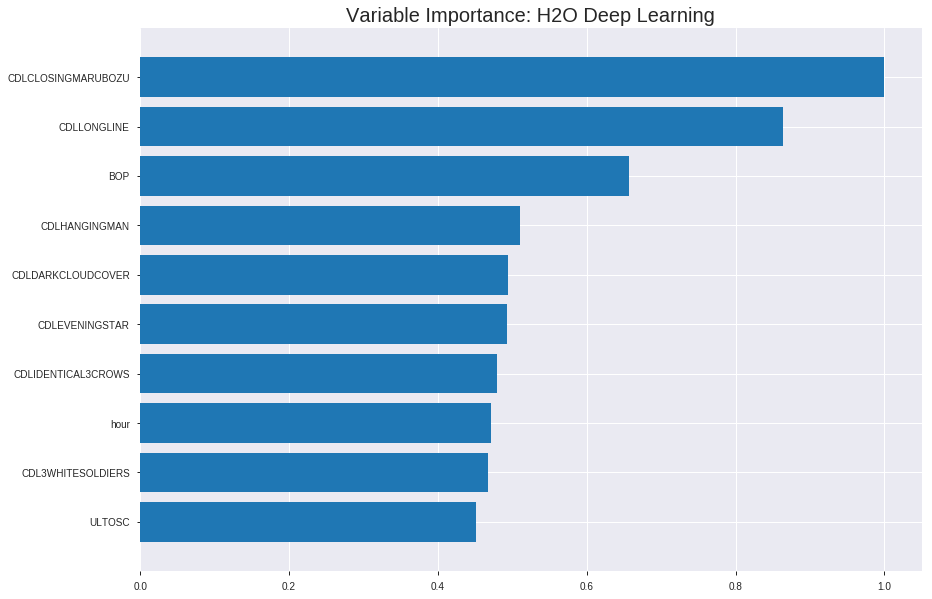

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_062657_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17799712795435066
RMSE: 0.4218970584803249
LogLoss: 0.5343442465847934
Mean Per-Class Error: 0.2593308500285245
AUC: 0.8169460384576664
pr_auc: 0.8069192589247024
Gini: 0.6338920769153329
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4164581921088658: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      448  322   0.4182   (322.0/770.0)
1      89   685   0.115    (89.0/774.0)
Total  537  1007  0.2662   (411.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416458     0.769231  250
max f2                       0.218312     0.855835  336
max f0point5                 0.557604     0.74231   165
max accuracy                 0.459228     0.740933  229
max precision                0.931816     1         0
max recall                   0.111739     1         387
max specificity              0.931816     1         0
max absolute_mcc             0.450301     0.493113  234
max min_per_class_accuracy   0.514597     0.735142  195
max mean_per_class_accuracy  0.459228     0.740669  229

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 48.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.877997           1.87016   1.87016            0.9375           0.886702  0.9375                      0.886702            0.0193798       0.0193798                  87.0155   87.0155
    2        0.0200777                   0.866633           1.99483   1.93048            1                0.872691  0.967742                    0.879923            0.0193798       0.0387597                  99.4832   93.0483
    3        0.0304404                   0.85485            1.99483   1.95239            1                0.859601  0.978723                    0.873005            0.0206718       0.0594315                  99.4832   95.2389
    4        0.0401554                   0.847877           1.72885   1.89831            0.866667         0.85187   0.951613                    0.867891            0.0167959       0.0762274                  72.8854   89.8308
    5        0.0505181                   0.840693           1.87016   1.89253            0.9375           0.844383  0.948718                    0.863069            0.0193798       0.0956072                  87.0155   89.2533
    6        0.100389                    0.796755           1.73576   1.81465            0.87013          0.81947   0.909677                    0.84141             0.0865633       0.182171                   73.5763   81.4654
    7        0.150259                    0.734483           1.68395   1.77127            0.844156         0.767035  0.887931                    0.816725            0.0839793       0.26615                    68.3949   77.1273
    8        0.20013                     0.676724           1.68395   1.74951            0.844156         0.702437  0.877023                    0.788246            0.0839793       0.350129                   68.3949   74.9513
    9        0.29987                     0.607517           1.42488   1.64154            0.714286         0.639329  0.822894                    0.738714            0.142119        0.492248                   42.488    64.1536
    10       0.400259                    0.553944           1.27412   1.54938            0.63871          0.577492  0.776699                    0.698278            0.127907        0.620155                   27.4119   54.9384
    11       0.5                         0.513137           1.15286   1.47028            0.577922         0.533749  0.737047                    0.665458            0.114987        0.735142                   15.2857   47.0284
    12       0.599741                    0.459318           1.03628   1.39811            0.519481         0.487887  0.700864                    0.635926            0.103359        0.838501                   3.62764   39.8106
    13       0.70013                     0.358381           0.682104  1.29544            0.341935         0.414528  0.649399                    0.604181            0.0684755       0.906977                   -31.7896  29.5441
    14       0.79987                     0.243354           0.505185  1.1969             0.253247         0.295806  0.6                         0.565728            0.0503876       0.957364                   -49.4815  19.6899
    15       0.899611                    0.170675           0.246116  1.09148            0.123377         0.20199   0.547156                    0.5254              0.0245478       0.981912                   -75.3884  9.14848
    16       1                           0.0447365          0.180178  1                  0.0903226        0.136853  0.501295                    0.486394         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19553896046190394
RMSE: 0.442197874782211
LogLoss: 0.5748143300577407
Mean Per-Class Error: 0.2846649059095411
AUC: 0.7724806041597887
pr_auc: 0.7622287941113398
Gini: 0.5449612083195774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3845590686059599: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  99   0.4249   (99.0/233.0)
1      40   168  0.1923   (40.0/208.0)
Total  174  267  0.3152   (139.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384559     0.707368  244
max f2                       0.168291     0.825123  351
max f0point5                 0.523242     0.717703  146
max accuracy                 0.514363     0.718821  154
max precision                0.902971     1         0
max recall                   0.11018      1         391
max specificity              0.902971     1         0
max absolute_mcc             0.514363     0.437899  154
max min_per_class_accuracy   0.468964     0.703863  199
max mean_per_class_accuracy  0.497014     0.715335  173

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 43.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.881664           2.12019   2.12019            1                0.894332  1                           0.894332            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.866996           2.12019   2.12019            1                0.873994  1                           0.885293            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.858353           2.12019   2.12019            1                0.862672  1                           0.877214            0.0240385       0.0673077                  112.019   112.019
    4        0.0408163                   0.841619           1.59014   2.0024             0.75             0.84768   0.944444                    0.870651            0.0144231       0.0817308                  59.0144   100.24
    5        0.0521542                   0.816207           1.69615   1.93583            0.8              0.825489  0.913043                    0.860833            0.0192308       0.100962                   69.6154   93.5828
    6        0.102041                    0.757935           2.02382   1.97885            0.954545         0.789043  0.933333                    0.825736            0.100962        0.201923                   102.382   97.8846
    7        0.151927                    0.660264           1.63833   1.86704            0.772727         0.691555  0.880597                    0.781676            0.0817308       0.283654                   63.833    86.7035
    8        0.201814                    0.608696           1.44559   1.76286            0.681818         0.627418  0.831461                    0.743545            0.0721154       0.355769                   44.5586   76.2857
    9        0.301587                    0.546322           1.34921   1.62601            0.636364         0.574495  0.766917                    0.687619            0.134615        0.490385                   34.9213   62.6012
    10       0.401361                    0.508042           1.34921   1.5572             0.636364         0.52506   0.734463                    0.647209            0.134615        0.625                      34.9213   55.7203
    11       0.501134                    0.456834           0.915538  1.42945            0.431818         0.484922  0.674208                    0.614898            0.0913462       0.716346                   -8.44624  42.9451
    12       0.600907                    0.389983           0.819165  1.32812            0.386364         0.42619   0.626415                    0.583566            0.0817308       0.798077                   -18.0835  32.812
    13       0.70068                     0.278647           0.674607  1.23506            0.318182         0.333107  0.582524                    0.547902            0.0673077       0.865385                   -32.5393  23.5063
    14       0.800454                    0.212696           0.578234  1.15319            0.272727         0.241463  0.543909                    0.509705            0.0576923       0.923077                   -42.1766  15.3192
    15       0.900227                    0.159024           0.433676  1.07345            0.204545         0.179992  0.506297                    0.473163            0.0432692       0.966346                   -56.6324  7.34475
    16       1                           0.0799263          0.337303  1                  0.159091         0.130896  0.471655                    0.439014           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:34:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:34:47  2 min 46.287 sec  473 obs/sec       0.78044   1             1205       0.484086         0.751026            0.0626379      0.748119        0.725969           1.74548          0.34456                          0.481874           0.739217              0.0681964        0.735505          0.719872             2.12019            0.349206
    2019-07-25 06:35:02  3 min  1.214 sec  762 obs/sec       7.97863   10            12319      0.44349          0.577071            0.21326        0.782597        0.774668           1.87016          0.316062                         0.450024           0.589381              0.187303         0.768509          0.756238             2.12019            0.331066
    2019-07-25 06:35:16  3 min 14.713 sec  869 obs/sec       15.9618   20            24645      0.444524         0.579769            0.209587       0.788253        0.783181           1.99483          0.310881                         0.456448           0.603354              0.163933         0.757604          0.747914             2.12019            0.335601
    2019-07-25 06:35:29  3 min 28.338 sec  942 obs/sec       24.7727   31            38249      0.437012         0.564734            0.236075       0.79183         0.78825            1.99483          0.301813                         0.447969           0.585769              0.194706         0.765197          0.754242             2.12019            0.331066
    2019-07-25 06:35:44  3 min 42.808 sec  1008 obs/sec      35.0959   44            54188      0.429522         0.548815            0.262038       0.803274        0.795543           1.99483          0.286269                         0.446274           0.584186              0.20079          0.772398          0.760773             2.12019            0.30839
    2019-07-25 06:35:58  3 min 56.817 sec  1057 obs/sec      45.4456   57            70168      0.421897         0.534344            0.288007       0.816946        0.806919           1.87016          0.266192                         0.442198           0.574814              0.215322         0.772481          0.762229             2.12019            0.315193
    2019-07-25 06:36:11  4 min 10.480 sec  1095 obs/sec      55.8497   70            86232      0.416797         0.521598            0.305118       0.821542        0.808283           1.87016          0.260363                         0.443593           0.582178              0.210365         0.770727          0.762923             2.12019            0.319728
    2019-07-25 06:36:13  4 min 11.778 sec  1094 obs/sec      55.8497   70            86232      0.421897         0.534344            0.288007       0.816946        0.806919           1.87016          0.266192                         0.442198           0.574814              0.215322         0.772481          0.762229             2.12019            0.315193

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.049255721630761404
CDLLONGLINE         0.8632121086120605     0.8632121086120605   0.04251813533009823
BOP                 0.6571924090385437     0.6571924090385437   0.032370486357451995
CDLHANGINGMAN       0.5103460550308228     0.5103460550308228   0.025137463221955446
CDLDARKCLOUDCOVER   0.4941812753677368     0.4941812753677368   0.024341255334647892
---                 ---                    ---                  ---
CDLBELTHOLD         0.2929173707962036     0.2929173707962036   0.014427856476752326
WILLR_8             0.2851065993309021     0.2851065993309021   0.01404313129173594
WILLR_20            0.28336358070373535    0.28336358070373535  0.013957277651438983
WILLR_14            0.27561599016189575    0.27561599016189575  0.013575664488401012
WILLR_12            0.27456405758857727    0.27456405758857727  0.013523850790395305


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7058823529411765)

('F1', 0.7235772357723578)

('auc', 0.7694581280788177)

('logloss', 0.5795097609682167)

('mean_per_class_error', 0.29692118226600983)

('rmse', 0.44415823463096615)

('mse', 0.19727653739049636)

deeplearning prediction progress: |███████████████████████████████████████| 100%


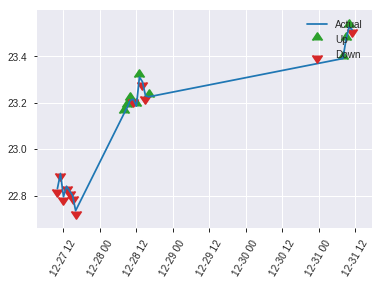


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19727653739049636
RMSE: 0.44415823463096615
LogLoss: 0.5795097609682167
Mean Per-Class Error: 0.29692118226600983
AUC: 0.7694581280788177
pr_auc: 0.7363141208870776
Gini: 0.5389162561576355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31222699324258707: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   52   0.4483   (52.0/116.0)
1      16   89   0.1524   (16.0/105.0)
Total  80   141  0.3077   (68.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.312227     0.723577  140
max f2                       0.213351     0.834739  172
max f0point5                 0.542645     0.705882  79
max accuracy                 0.542645     0.705882  79
max precision                0.889204     1         0
max recall                   0.0933321    1         217
max specificity              0.889204     1         0
max absolute_mcc             0.339224     0.416907  135
max min_per_class_accuracy   0.479448     0.685714  105
max mean_per_class_accuracy  0.339224     0.703079  135

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 44.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.865912           2.10476   2.10476            1                0.876264  1                           0.876264            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.860252           2.10476   2.10476            1                0.865158  1                           0.871821            0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.847014           2.10476   2.10476            1                0.85072   1                           0.865792            0.0190476       0.0666667                  110.476   110.476
    4        0.040724                    0.842381           0         1.63704            0                0.845955  0.777778                    0.861384            0               0.0666667                  -100      63.7037
    5        0.0542986                   0.83288            2.10476   1.75397            1                0.836623  0.833333                    0.855194            0.0285714       0.0952381                  110.476   75.3968
    6        0.104072                    0.761808           1.91342   1.83023            0.909091         0.793898  0.869565                    0.825879            0.0952381       0.190476                   91.342    83.0228
    7        0.153846                    0.677308           1.53074   1.73333            0.727273         0.705148  0.823529                    0.786819            0.0761905       0.266667                   53.0736   73.3333
    8        0.20362                     0.643949           1.72208   1.73058            0.818182         0.657814  0.822222                    0.755284            0.0857143       0.352381                   72.2078   73.0582
    9        0.303167                    0.578942           1.24372   1.57072            0.590909         0.610011  0.746269                    0.707583            0.12381         0.47619                    24.3723   57.0718
    10       0.402715                    0.515843           1.24372   1.48989            0.590909         0.543586  0.707865                    0.667044            0.12381         0.6                        24.3723   48.9888
    11       0.502262                    0.46914            0.861039  1.36525            0.409091         0.493933  0.648649                    0.632734            0.0857143       0.685714                   -13.8961  36.5251
    12       0.60181                     0.353456           1.14805   1.32932            0.545455         0.422727  0.631579                    0.597996            0.114286        0.8                        14.8052   32.9323
    13       0.701357                    0.255287           0.861039  1.26286            0.409091         0.29767   0.6                         0.555369            0.0857143       0.885714                   -13.8961  26.2857
    14       0.800905                    0.207725           0.574026  1.17724            0.272727         0.226825  0.559322                    0.514533            0.0571429       0.942857                   -42.5974  17.724
    15       0.900452                    0.156511           0.191342  1.06825            0.0909091        0.176362  0.507538                    0.477147            0.0190476       0.961905                   -80.8658  6.8246
    16       1                           0.0849212          0.382684  1                  0.181818         0.126263  0.475113                    0.442218           

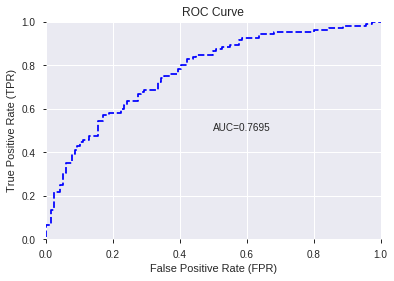

This function is available for GLM models only


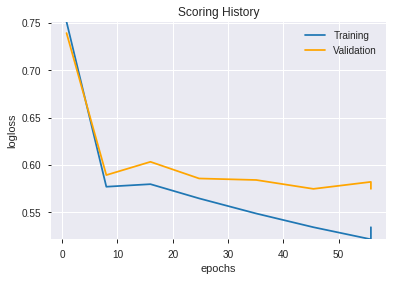

--2019-07-25 06:36:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.140
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.140|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


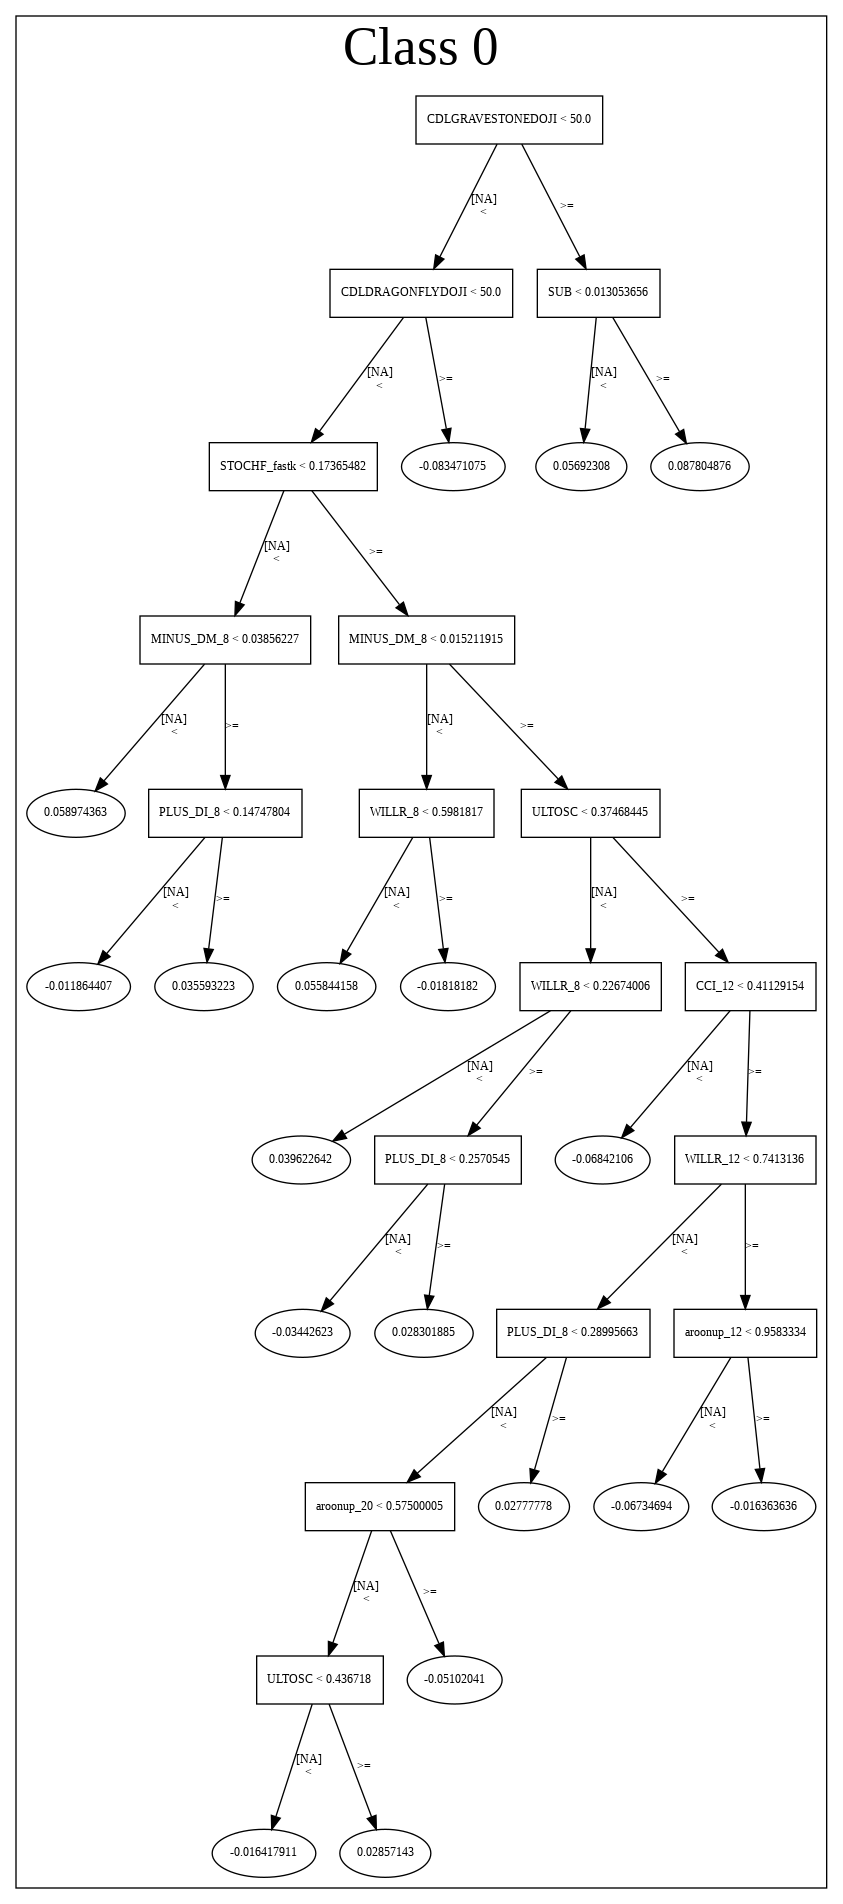

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_062657_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_062657_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'BOP',
 'CDLHANGINGMAN',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'CDLIDENTICAL3CROWS',
 'hour',
 'CDL3WHITESOLDIERS',
 'ULTOSC',
 'SUB',
 'TRANGE',
 'CDL3BLACKCROWS',
 'CDLLADDERBOTTOM',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'DIV',
 'CORREL_30',
 'SAREXT',
 'CDLGRAVESTONEDOJI',
 'BETA_8',
 'HT_DCPERIOD',
 'is_month_start',
 'aroonup_24',
 'CDLHAMMER',
 'ADOSC',
 'Volume',
 'CDLSPINNINGTOP',
 'CDLLONGLEGGEDDOJI',
 'CORREL_12',
 'CORREL_24',
 'DX_8',
 'aroonup_8',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'CDLDOJI',
 'STOCHRSI_fastd',
 'weekday_name',
 'dayofweek',
 'weekday',
 'CORREL_20',
 'day',
 'WILLR_24',
 'AROONOSC_8',
 'CDLBELTHOLD',
 'WILLR_8',
 'WILLR_20',
 'WILLR_14',
 'WILLR_12']

In [0]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_063629_model_1  0.75509  0.59914              0.284893  0.450661  0.203095

variable  relative_importance  scaled_importance  percentage
0                  SUB             1.398324           1.000000    0.133945
1                  DIV             0.728790           0.521188    0.069810
2                  BOP             0.687756           0.491843    0.065880
3         STOCHF_fastk             0.549306           0.392831    0.052618
4          STOCH_slowd             0.527582           0.377296    0.050537
5               ULTOSC             0.525319           0.375677    0.050320
6             WILLR_24             0.394721           0.282281    0.037810
7    CDLDARKCLOUDCOVER             0.365486           0.261374    0.035010
8       STOCHRSI_fastk             0.353760           0.252989    0.033886
9               TRANGE             0.314559           0.224954    0.030131
10   CDL3WHITESOLDIERS             0.288874           0.206586    0.027671
11         CDLLONGLINE             0.262673           0.187848    0.025161
12           CORREL_30             0.252740           0.180745    0.024210
13  CDLIDENTICAL3CROWS             0.240875           0.172260    0.023073
14            WILLR_20             0.235653           0.168525    0.022573
15            WILLR_12             0.232960           0.166599    0.022315
16          aroonup_24             0.225179           0.161035    0.021570
17  CDLCLOSINGMARUBOZU             0.207344           0.148280    0.019861
18                hour             0.198184           0.141730    0.018984
19     CDLLADDERBOTTOM             0.196570           0.140575    0.018829
20         CDLBELTHOLD             0.192489           0.137657    0.018438
21           aroonup_8             0.177687           0.127071    0.017020
22      CDL3BLACKCROWS             0.163210           0.116718    0.015634
23         HT_DCPERIOD             0.147331           0.105362    0.014113
24      STOCHRSI_fastd             0.145258           0.103880    0.013914
25              BETA_8             0.123834           0.088559    0.011862
26          AROONOSC_8             0.116931           0.083622    0.011201
27             WILLR_8             0.110244           0.078840    0.010560
28        HT_TRENDMODE             0.107529           0.076899    0.010300
29              Volume             0.099444           0.071117    0.009526
30       CDLHANGINGMAN             0.096067           0.068701    0.009202
31           CDLHAMMER             0.092600           0.066222    0.008870
32           CORREL_12             0.080735           0.057737    0.007734
33           CDLTAKURI             0.068862           0.049246    0.006596
34           CORREL_24             0.065450           0.046806    0.006269
35            WILLR_14             0.061061           0.043667    0.005849
36           CORREL_20             0.059965           0.042884    0.005744
37                 day             0.058598           0.041906    0.005613
38      is_month_start             0.055674           0.039814    0.005333
39                DX_8             0.050856           0.036369    0.004871
40      CDLEVENINGSTAR             0.041233           0.029487    0.003950
41              SAREXT             0.035789           0.025594    0.003428
42           dayofweek             0.025570           0.018286    0.002449
43             weekday             0.024379           0.017434    0.002335
44   CDLGRAVESTONEDOJI             0.018470           0.013209    0.001769
45               ADOSC             0.012988           0.009288    0.001244
46      CDLSPINNINGTOP             0.007929           0.005670    0.000759
47   CDLLONGLEGGEDDOJI             0.005048           0.003610    0.000484
48        weekday_name             0.003853           0.002756    0.000369
49             CDLDOJI             0.003827           0.002737    0.000367

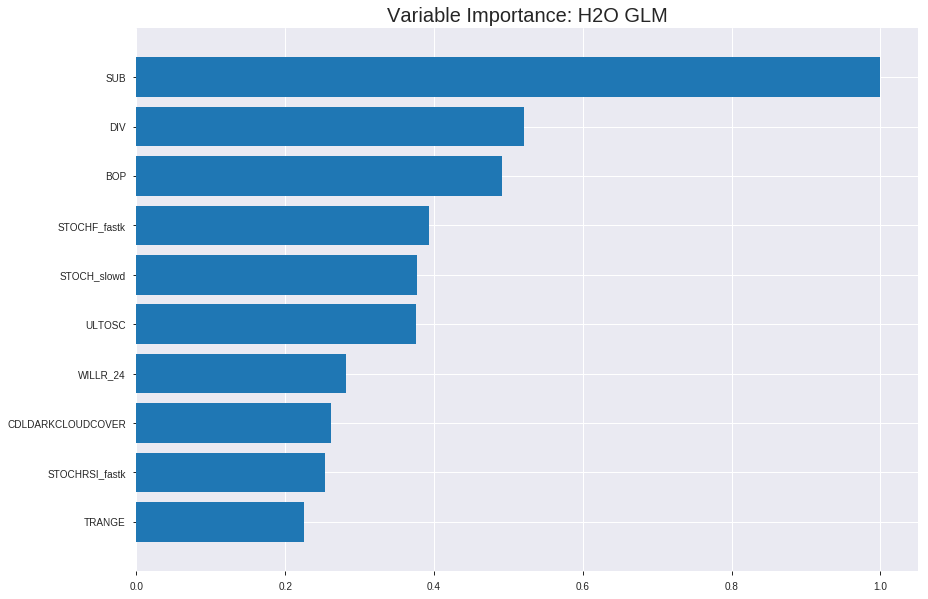

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_063629_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18764513985795342
RMSE: 0.43318026254430547
LogLoss: 0.5540202908645274
Null degrees of freedom: 1543
Residual degrees of freedom: 1493
Null deviance: 2140.428130863218
Residual deviance: 1710.8146581896608
AIC: 1812.8146581896608
AUC: 0.7871228900298668
pr_auc: 0.7691549689174877
Gini: 0.5742457800597336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40325188428610403: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  340   0.4416   (340.0/770.0)
1      109  665   0.1408   (109.0/774.0)
Total  539  1005  0.2908   (449.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403252     0.747611  246
max f2                       0.190052     0.85104   332
max f0point5                 0.536469     0.715829  181
max accuracy                 0.475173     0.716321  214
max precision                0.999761     1         0
max recall                   0.0516584    1         385
max specificity              0.999761     1         0
max absolute_mcc             0.421697     0.441877  239
max min_per_class_accuracy   0.521019     0.712987  190
max mean_per_class_accuracy  0.475173     0.716155  214

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.953015           1.87016   1.87016            0.9375           0.967007   0.9375                      0.967007            0.0193798       0.0193798                  87.0155   87.0155
    2        0.0200777                   0.927584           1.72885   1.80178            0.866667         0.937765   0.903226                    0.952858            0.0167959       0.0361757                  72.8854   80.1784
    3        0.0304404                   0.914181           1.87016   1.82506            0.9375           0.921132   0.914894                    0.942058            0.0193798       0.0555556                  87.0155   82.5059
    4        0.0401554                   0.901384           1.86184   1.83396            0.933333         0.907688   0.919355                    0.933742            0.0180879       0.0736434                  86.1843   83.3958
    5        0.0505181                   0.890742           1.74548   1.81581            0.875            0.897128   0.910256                    0.926232            0.0180879       0.0917313                  74.5478   81.5809
    6        0.100389                    0.833461           1.76167   1.78891            0.883117         0.864143   0.896774                    0.895388            0.0878553       0.179587                   76.167    78.8914
    7        0.150259                    0.782888           1.55441   1.71108            0.779221         0.808297   0.857759                    0.866483            0.0775194       0.257106                   55.4415   71.1084
    8        0.20013                     0.731097           1.5026    1.65913            0.753247         0.755381   0.831715                    0.838797            0.0749354       0.332041                   50.2601   65.9132
    9        0.29987                     0.655331           1.39897   1.5726             0.701299         0.693159   0.788337                    0.790356            0.139535        0.471576                   39.8973   57.26
    10       0.400259                    0.585284           1.23551   1.48805            0.619355         0.619736   0.745955                    0.747563            0.124031        0.595607                   23.5509   48.8054
    11       0.5                         0.521118           1.16581   1.42377            0.584416         0.554765   0.713731                    0.709103            0.116279        0.711886                   16.5811   42.3773
    12       0.599741                    0.445834           0.945602  1.34425            0.474026         0.484715   0.673866                    0.671786            0.0943152       0.806202                   -5.43978  34.425
    13       0.70013                     0.354882           0.836542  1.27145            0.419355         0.402105   0.637373                    0.633118            0.0839793       0.890181                   -16.3458  27.1452
    14       0.79987                     0.254189           0.569952  1.18398            0.285714         0.304495   0.593522                    0.59214             0.0568475       0.947028                   -43.0048  18.3977
    15       0.899611                    0.140957           0.323836  1.08861            0.162338         0.199069   0.545716                    0.548559            0.0322997       0.979328                   -67.6164  8.86124
    16       1                           1.90865e-05        0.205918  1                  0.103226         0.0777493  0.501295                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18850089121977703
RMSE: 0.4341668932792746
LogLoss: 0.5543906519383016
Null degrees of freedom: 440
Residual degrees of freedom: 390
Null deviance: 611.4883070433551
Residual deviance: 488.972555009582
AIC: 590.972555009582
AUC: 0.7851704357873887
pr_auc: 0.7658592916534083
Gini: 0.5703408715747773
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39583816372458747: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  99   0.4249   (99.0/233.0)
1      36   172  0.1731   (36.0/208.0)
Total  170  271  0.3061   (135.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395838     0.718163  239
max f2                       0.203489     0.835422  328
max f0point5                 0.557902     0.723039  140
max accuracy                 0.557902     0.718821  140
max precision                0.974311     1         0
max recall                   0.0766624    1         377
max specificity              0.974311     1         0
max absolute_mcc             0.557902     0.442607  140
max min_per_class_accuracy   0.486999     0.706731  191
max mean_per_class_accuracy  0.429376     0.711311  217

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 46.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.89154            2.12019   2.12019            1                0.92387    1                           0.92387             0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.868301           2.12019   2.12019            1                0.87784    1                           0.903412            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.856807           1.69615   1.96875            0.8              0.861841   0.928571                    0.888565            0.0192308       0.0625                     69.6154   96.875
    4        0.0408163                   0.837064           2.12019   2.0024             1                0.844782   0.944444                    0.878836            0.0192308       0.0817308                  112.019   100.24
    5        0.0521542                   0.826345           1.69615   1.93583            0.8              0.829731   0.913043                    0.868161            0.0192308       0.100962                   69.6154   93.5828
    6        0.102041                    0.769721           1.83108   1.88462            0.863636         0.796532   0.888889                    0.833142            0.0913462       0.192308                   83.1075   88.4615
    7        0.151927                    0.725423           1.92745   1.89868            0.909091         0.742577   0.895522                    0.803404            0.0961538       0.288462                   92.7448   89.868
    8        0.201814                    0.680544           1.54196   1.8105             0.727273         0.703288   0.853933                    0.778656            0.0769231       0.365385                   54.1958   81.0501
    9        0.301587                    0.59628            1.3974    1.67384            0.659091         0.643293   0.789474                    0.733875            0.139423        0.504808                   39.7399   67.3836
    10       0.401361                    0.527583           0.963724  1.49731            0.454545         0.556203   0.706215                    0.689708            0.0961538       0.600962                   -3.62762  49.7311
    11       0.501134                    0.480336           1.10828   1.41986            0.522727         0.503013   0.669683                    0.652538            0.110577        0.711538                   10.8282   41.9857
    12       0.600907                    0.404896           0.963724  1.34412            0.454545         0.433694   0.633962                    0.616201            0.0961538       0.807692                   -3.62762  34.4122
    13       0.70068                     0.329682           0.62642   1.24192            0.295455         0.371313   0.585761                    0.581331            0.0625          0.870192                   -37.358   24.1925
    14       0.800454                    0.239985           0.770979  1.18322            0.363636         0.285703   0.558074                    0.544482            0.0769231       0.947115                   -22.9021  18.3223
    15       0.900227                    0.122162           0.337303  1.08947            0.159091         0.177193   0.513854                    0.503775            0.0336538       0.980769                   -66.2697  8.94691
    16       1                           0.00419721         0.192745  1                  0.0909091        0.0686068  0.471655                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 06:36:29  0.000 sec   2            .2E2      51            1.364190226758374   1.3667910236332164
     2019-07-25 06:36:29  0.011 sec   4            .12E2     51            1.3531316905457011  1.3567910412334865
     2019-07-25 06:36:29  0.020 sec   6            .76E1     51            1.3380823028143753  1.3430743154760845
     2019-07-25 06:36:29  0.030 sec   8            .47E1     51            1.3188623547022686  1.325345543416773
     2019-07-25 06:36:29  0.040 sec   10           .29E1     51            1.29587718440371    1.3038128066579673
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 06:36:29  0.244 sec   47           .21E-3    51            1.108122440116475   1.1091371125675025
     2019-07-25 06:36:29  0.249 sec   48           .13E-3    51            1.1080779251959587  1.1089779613487334
     2019-07-25 06:36:29  0.254 sec   49           .82E-4    51            1.108056103085385   1.1088796753629135
     2019-07-25 06:36:29  0.260 sec   50           .51E-4    51            1.1080458614733448  1.1088169054025587
     2019-07-25 06:36:29  0.266 sec   51           .32E-4    51            1.1080405817290548  1.1087813038766032


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7104072398190046)

('F1', 0.7264957264957264)

('auc', 0.7550903119868637)

('logloss', 0.5991399003780321)

('mean_per_class_error', 0.28489326765188827)

('rmse', 0.4506608527124509)

('mse', 0.20309520416751334)

glm prediction progress: |████████████████████████████████████████████████| 100%


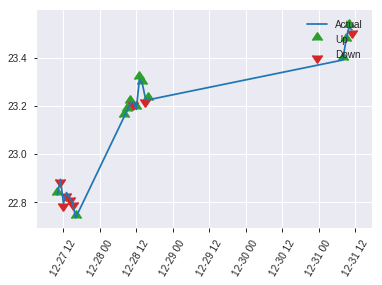


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20309520416751334
RMSE: 0.4506608527124509
LogLoss: 0.5991399003780321
Null degrees of freedom: 220
Residual degrees of freedom: 170
Null deviance: 306.4295320199308
Residual deviance: 264.81983596709017
AIC: 366.81983596709017
AUC: 0.7550903119868637
pr_auc: 0.7191059260330794
Gini: 0.5101806239737274
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44954271390889555: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   44   0.3793   (44.0/116.0)
1      20   85   0.1905   (20.0/105.0)
Total  92   129  0.2896   (64.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449543     0.726496  128
max f2                       0.277942     0.829103  170
max f0point5                 0.655905     0.687023  71
max accuracy                 0.449543     0.710407  128
max precision                0.952054     1         0
max recall                   0.025479     1         218
max specificity              0.952054     1         0
max absolute_mcc             0.449543     0.435832  128
max min_per_class_accuracy   0.536614     0.685714  107
max mean_per_class_accuracy  0.449543     0.715107  128

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 50.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.92688            2.10476   2.10476            1                0.936861   1                           0.936861            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.915971           2.10476   2.10476            1                0.92191    1                           0.93088             0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.900025           2.10476   2.10476            1                0.907474   1                           0.924193            0.0190476       0.0666667                  110.476   110.476
    4        0.040724                    0.892384           1.05238   1.8709             0.5              0.89823    0.888889                    0.918423            0.00952381      0.0761905                  5.2381    87.0899
    5        0.0542986                   0.882561           2.10476   1.92937            1                0.886505   0.916667                    0.910444            0.0285714       0.104762                   110.476   92.9365
    6        0.104072                    0.818011           1.53074   1.73872            0.727273         0.842557   0.826087                    0.877976            0.0761905       0.180952                   53.0736   73.8716
    7        0.153846                    0.769623           1.72208   1.73333            0.818182         0.788991   0.823529                    0.849187            0.0857143       0.266667                   72.2078   73.3333
    8        0.20362                     0.73769            1.14805   1.59026            0.545455         0.751806   0.755556                    0.825383            0.0571429       0.32381                    14.8052   59.0265
    9        0.303167                    0.678355           1.43506   1.5393             0.681818         0.704244   0.731343                    0.785606            0.142857        0.466667                   43.5065   53.9303
    10       0.402715                    0.612051           1.14805   1.44259            0.545455         0.636755   0.685393                    0.748811            0.114286        0.580952                   14.8052   44.259
    11       0.502262                    0.518956           1.24372   1.40317            0.590909         0.562435   0.666667                    0.711872            0.12381         0.704762                   24.3723   40.3175
    12       0.60181                     0.439145           1.05238   1.34515            0.5              0.474217   0.639098                    0.67256             0.104762        0.809524                   5.2381    34.5149
    13       0.701357                    0.350012           0.574026  1.2357             0.272727         0.386757   0.587097                    0.631995            0.0571429       0.866667                   -42.5974  23.5699
    14       0.800905                    0.2563             0.669697  1.16535            0.318182         0.299534   0.553672                    0.590672            0.0666667       0.933333                   -33.0303  16.5348
    15       0.900452                    0.144326           0.191342  1.05767            0.0909091        0.204165   0.502513                    0.547943            0.0190476       0.952381                   -80.8658  5.76693
    16       1                           0.0137118          0.478355  1                  0.227273         0.0691825  0.475113                    

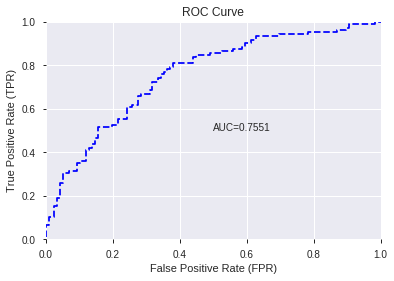

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


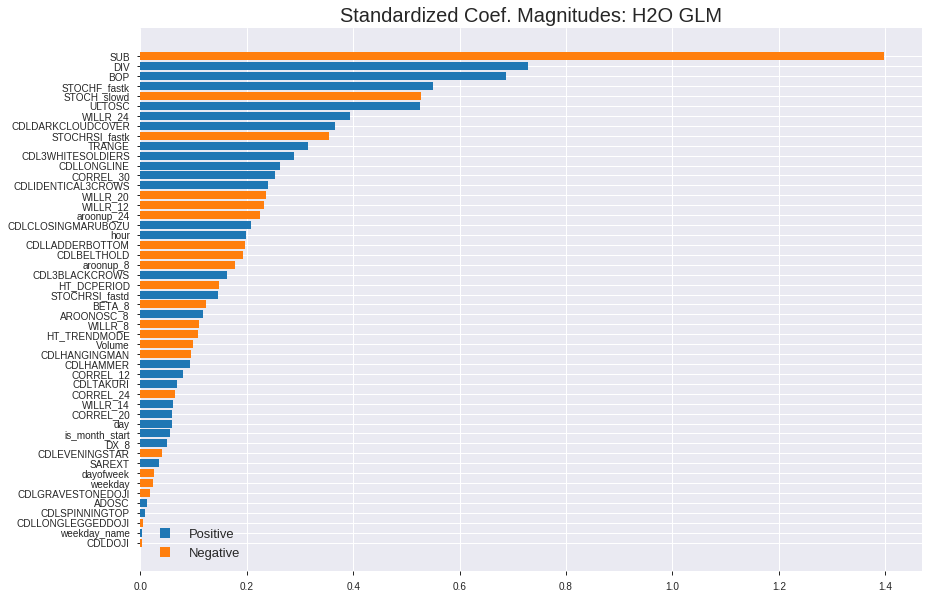

'log_likelihood'
--2019-07-25 06:36:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


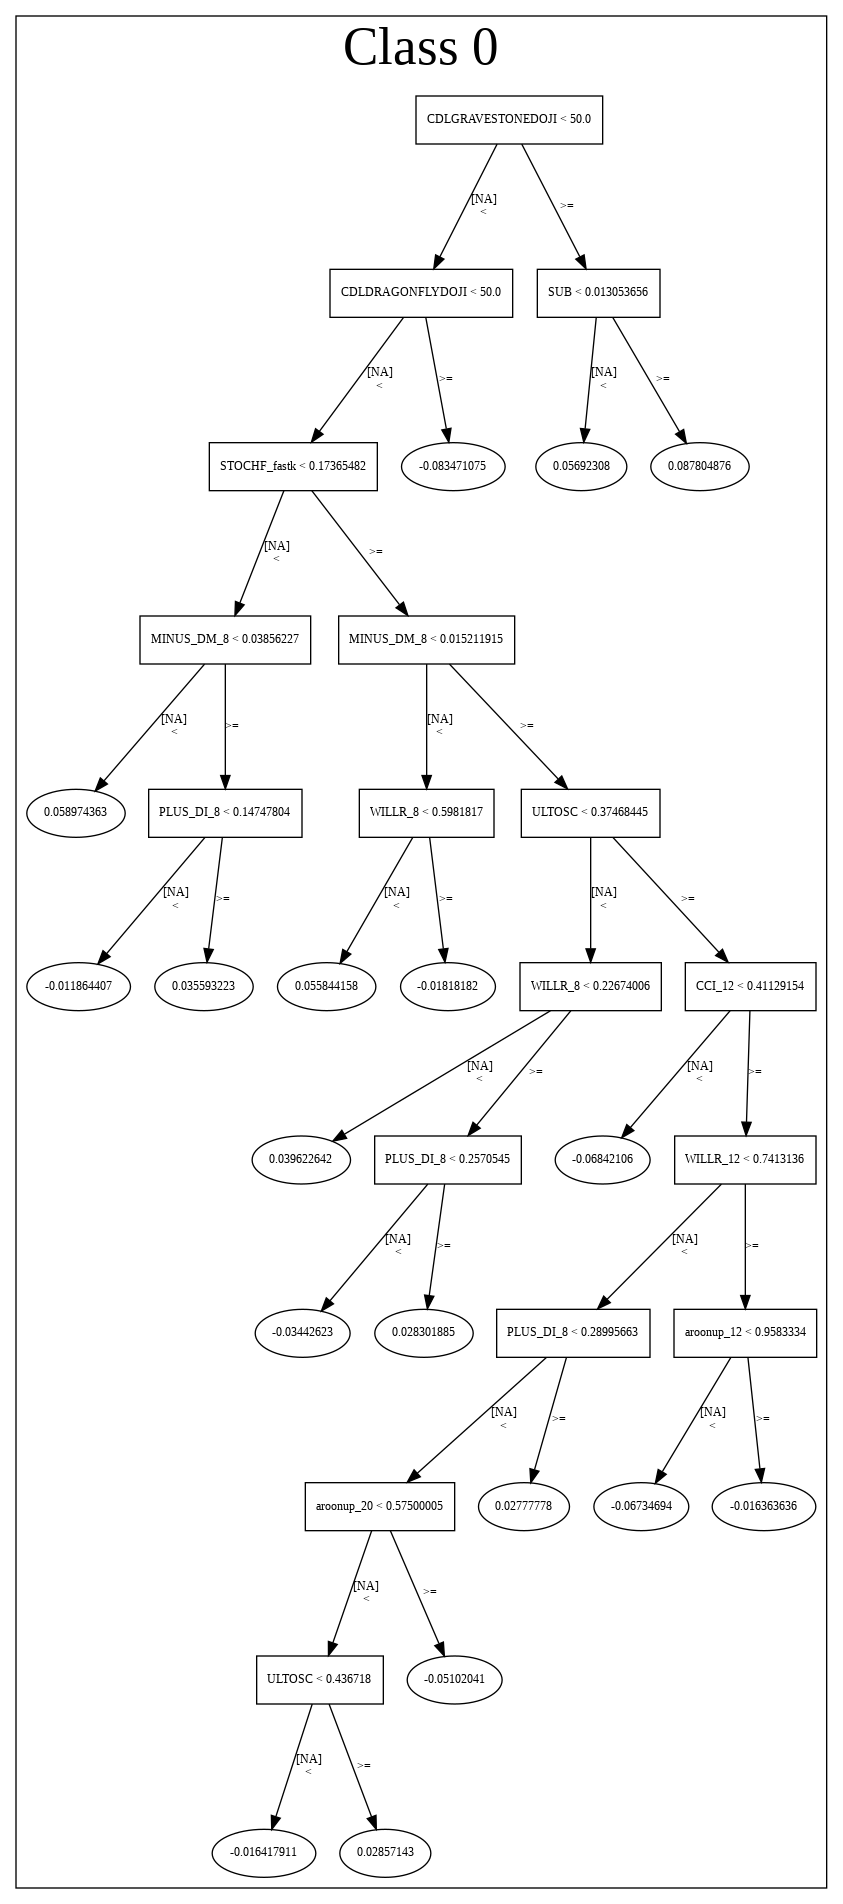

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_063629_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_063629_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SUB',
 'DIV',
 'BOP',
 'STOCHF_fastk',
 'STOCH_slowd',
 'ULTOSC',
 'WILLR_24',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'TRANGE',
 'CDL3WHITESOLDIERS',
 'CDLLONGLINE',
 'CORREL_30',
 'CDLIDENTICAL3CROWS',
 'WILLR_20',
 'WILLR_12',
 'aroonup_24',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'CDLLADDERBOTTOM',
 'CDLBELTHOLD',
 'aroonup_8',
 'CDL3BLACKCROWS',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'BETA_8',
 'AROONOSC_8',
 'WILLR_8',
 'HT_TRENDMODE',
 'Volume',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CORREL_12',
 'CDLTAKURI',
 'CORREL_24',
 'WILLR_14',
 'CORREL_20',
 'day',
 'is_month_start',
 'DX_8',
 'CDLEVENINGSTAR',
 'SAREXT',
 'dayofweek',
 'weekday',
 'CDLGRAVESTONEDOJI',
 'ADOSC',
 'CDLSPINNINGTOP',
 'CDLLONGLEGGEDDOJI',
 'weekday_name',
 'CDLDOJI']

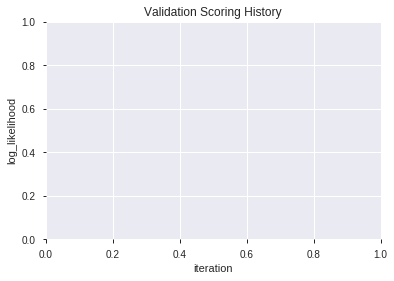

In [0]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_063646_model_6  0.768555  0.581422              0.282389  0.442694  0.195978
1  XGBoost_grid_1_AutoML_20190725_063646_model_4  0.758785  0.587882              0.307594  0.447109  0.199907
2  XGBoost_grid_1_AutoML_20190725_063646_model_2  0.757143  0.586165              0.296921  0.446801  0.199631
3  XGBoost_grid_1_AutoML_20190725_063646_model_3  0.756979  0.586850              0.311905  0.447214  0.200001
4  XGBoost_grid_1_AutoML_20190725_063646_model_5  0.752299  0.609741              0.298727  0.453324  0.205503
5  XGBoost_grid_1_AutoML_20190725_063646_model_1  0.751888  0.595834              0.292611  0.450609  0.203048
6               XGBoost_3_AutoML_20190725_063646  0.750082  0.592105              0.296921  0.450098  0.202588
7               XGBoost_1_AutoML_20190725_063646  0.748933  0.600866              0.335961  0.451991  0.204296
8  XGBoost_grid_1_AutoML_20190725_063646_model_7  0.744089  0.603925              0.324138  0.454460  0.206534
9               XGBoost_2_AutoML_20190725_063646  0.744007  0.597031              0.360016  0.452654  0.204896

variable  relative_importance  scaled_importance  percentage
0                  BOP          1886.109253           1.000000    0.187202
1         STOCHF_fastk           747.596130           0.396369    0.074201
2                  DIV           483.659729           0.256433    0.048005
3               Volume           405.282288           0.214877    0.040225
4               TRANGE           397.598572           0.210804    0.039463
5                ADOSC           390.328552           0.206949    0.038741
6               SAREXT           386.174805           0.204747    0.038329
7            CORREL_30           357.802490           0.189704    0.035513
8               BETA_8           341.724426           0.181180    0.033917
9               ULTOSC           322.064056           0.170756    0.031966
10         STOCH_slowd           306.956818           0.162746    0.030466
11                DX_8           303.312775           0.160814    0.030105
12         HT_DCPERIOD           297.836487           0.157911    0.029561
13                hour           296.935974           0.157433    0.029472
14      STOCHRSI_fastd           289.852905           0.153678    0.028769
15             WILLR_8           287.431213           0.152394    0.028528
16           CORREL_12           254.984039           0.135190    0.025308
17           CORREL_20           221.594452           0.117488    0.021994
18           CORREL_24           220.587448           0.116954    0.021894
19                 SUB           207.783142           0.110165    0.020623
20            WILLR_12           206.021790           0.109231    0.020448
21           aroonup_8           200.784927           0.106455    0.019928
22            WILLR_20           178.206604           0.094484    0.017688
23            WILLR_24           150.978867           0.080048    0.014985
24                 day           149.681641           0.079360    0.014856
25         CDLLONGLINE           126.002670           0.066806    0.012506
26            WILLR_14           111.949883           0.059355    0.011111
27           dayofweek           107.044373           0.056754    0.010624
28          aroonup_24            99.908089           0.052970    0.009916
29          AROONOSC_8            94.688271           0.050203    0.009398
30      STOCHRSI_fastk            68.340195           0.036233    0.006783
31  CDLCLOSINGMARUBOZU            61.388767           0.032548    0.006093
32        weekday_name            38.620861           0.020476    0.003833
33        HT_TRENDMODE            29.343384           0.015558    0.002912
34      CDLSPINNINGTOP            16.975706           0.009000    0.001685
35             weekday            14.329960           0.007598    0.001422
36       CDLHANGINGMAN             5.635690           0.002988    0.000559
37           CDLHAMMER             4.840034           0.002566    0.000480
38             CDLDOJI             2.885262           0.001530    0.000286
39         CDLBELTHOLD             2.034505           0.001079    0.000202

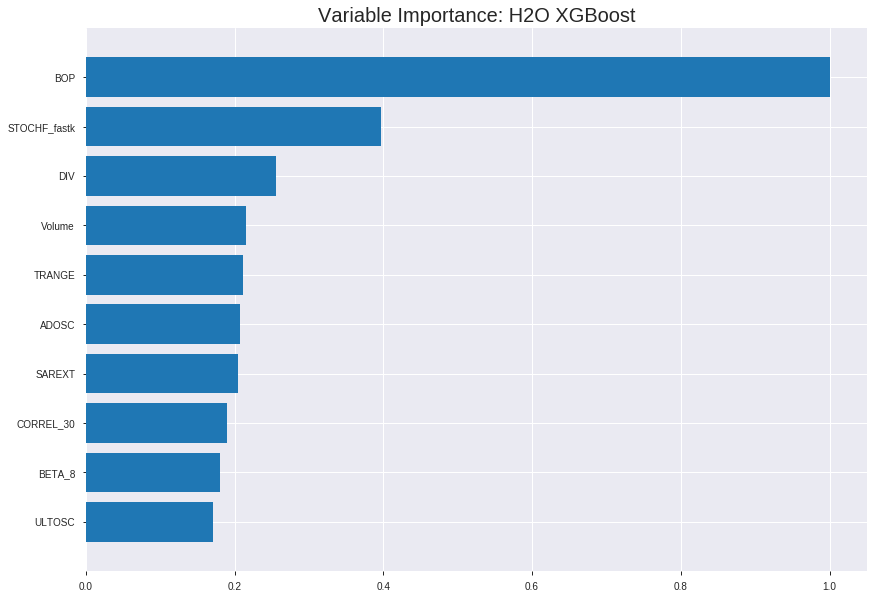

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_063646_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1266598164400882
RMSE: 0.35589298453339624
LogLoss: 0.41365743524317694
Mean Per-Class Error: 0.14644451156079064
AUC: 0.9333501124198799
pr_auc: 0.935280004285539
Gini: 0.8667002248397597
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5056730508804321: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      633  137  0.1779   (137.0/770.0)
1      89   685  0.115    (89.0/774.0)
Total  722  822  0.1464   (226.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505673     0.858396  198
max f2                       0.350187     0.906798  268
max f0point5                 0.618582     0.864217  144
max accuracy                 0.514111     0.853627  196
max precision                0.963468     1         0
max recall                   0.195545     1         333
max specificity              0.963468     1         0
max absolute_mcc             0.505673     0.708576  198
max min_per_class_accuracy   0.533601     0.845455  188
max mean_per_class_accuracy  0.514111     0.853555  196

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.934433           1.99483    1.99483            1                0.943126  1                           0.943126            0.0206718       0.0206718                  99.4832   99.4832
    2        0.0200777                   0.923982           1.99483    1.99483            1                0.928541  1                           0.936068            0.0193798       0.0400517                  99.4832   99.4832
    3        0.0304404                   0.904513           1.99483    1.99483            1                0.911901  1                           0.927841            0.0206718       0.0607235                  99.4832   99.4832
    4        0.0401554                   0.891589           1.99483    1.99483            1                0.897917  1                           0.920601            0.0193798       0.0801034                  99.4832   99.4832
    5        0.0505181                   0.877808           1.99483    1.99483            1                0.884459  1                           0.913188            0.0206718       0.100775                   99.4832   99.4832
    6        0.100389                    0.82511            1.99483    1.99483            1                0.849651  1                           0.881624            0.0994832       0.200258                   99.4832   99.4832
    7        0.150259                    0.772535           1.96893    1.98623            0.987013         0.798114  0.99569                     0.853907            0.0981912       0.29845                    96.8925   98.6234
    8        0.20013                     0.736598           1.99483    1.98838            1                0.754887  0.996764                    0.829232            0.0994832       0.397933                   99.4832   98.8376
    9        0.29987                     0.671486           1.77462    1.91728            0.88961          0.703209  0.961123                    0.787315            0.177003        0.574935                   77.4623   91.7279
    10       0.400259                    0.60189            1.44143    1.79793            0.722581         0.637796  0.901294                    0.749815            0.144703        0.719638                   44.1427   79.7931
    11       0.5                         0.53324            1.26944    1.69251            0.636364         0.565019  0.848446                    0.712951            0.126615        0.846253                   26.9439   69.2506
    12       0.599741                    0.438348           0.854928   1.55321            0.428571         0.486704  0.778618                    0.675325            0.0852713       0.931525                   -14.5072  55.3212
    13       0.70013                     0.339799           0.437576   1.39325            0.219355         0.390462  0.698427                    0.634479            0.0439276       0.975452                   -56.2424  39.3245
    14       0.79987                     0.229511           0.207255   1.24536            0.103896         0.286614  0.624291                    0.591102            0.0206718       0.996124                   -79.2745  24.5357
    15       0.899611                    0.144315           0.0388604  1.11159            0.0194805        0.18272   0.557235                    0.545824            0.00387597      1                          -96.114   11.1591
    16       1                           0.0547467          0          1                  0                0.108045  0.501295                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18686279354584823
RMSE: 0.4322762930648039
LogLoss: 0.5512281253968401
Mean Per-Class Error: 0.2861092769891054
AUC: 0.7913193298118191
pr_auc: 0.7702821793374633
Gini: 0.5826386596236381
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35077959299087524: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      131  102  0.4378   (102.0/233.0)
1      28   180  0.1346   (28.0/208.0)
Total  159  282  0.2948   (130.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35078      0.734694  256
max f2                       0.165573     0.834711  343
max f0point5                 0.574894     0.718912  131
max accuracy                 0.546879     0.716553  151
max precision                0.951939     1         0
max recall                   0.114285     1         376
max specificity              0.951939     1         0
max absolute_mcc             0.35078      0.444571  256
max min_per_class_accuracy   0.461766     0.703863  198
max mean_per_class_accuracy  0.374064     0.713891  241

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 45.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.938621           2.12019   2.12019            1                0.944487  1                           0.944487            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.914835           2.12019   2.12019            1                0.930423  1                           0.938237            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.890933           2.12019   2.12019            1                0.905412  1                           0.926513            0.0240385       0.0673077                  112.019   112.019
    4        0.0408163                   0.868539           2.12019   2.12019            1                0.881704  1                           0.916556            0.0192308       0.0865385                  112.019   112.019
    5        0.0521542                   0.844164           1.69615   2.02801            0.8              0.851989  0.956522                    0.90252             0.0192308       0.105769                   69.6154   102.801
    6        0.102041                    0.738739           1.7347    1.88462            0.818182         0.78196   0.888889                    0.84358             0.0865385       0.192308                   73.4703   88.4615
    7        0.151927                    0.695907           1.7347    1.83539            0.818182         0.714914  0.865672                    0.801331            0.0865385       0.278846                   73.4703   83.539
    8        0.201814                    0.662701           1.54196   1.76286            0.727273         0.678962  0.831461                    0.771082            0.0769231       0.355769                   54.1958   76.2857
    9        0.301587                    0.595334           1.49377   1.67384            0.704545         0.624133  0.789474                    0.722468            0.149038        0.504808                   49.3772   67.3836
    10       0.401361                    0.515103           1.10828   1.53325            0.522727         0.555658  0.723164                    0.681001            0.110577        0.615385                   10.8282   53.3246
    11       0.501134                    0.459609           0.963724  1.41986            0.454545         0.483726  0.669683                    0.641724            0.0961538       0.711538                   -3.62762  41.9857
    12       0.600907                    0.374064           1.15647   1.37612            0.545455         0.414258  0.649057                    0.603956            0.115385        0.826923                   15.6469   37.6125
    13       0.70068                     0.307378           0.62642   1.26937            0.295455         0.343968  0.598706                    0.566935            0.0625          0.889423                   -37.358   26.9371
    14       0.800454                    0.224554           0.578234  1.18322            0.272727         0.262345  0.558074                    0.528969            0.0576923       0.947115                   -42.1766  18.3223
    15       0.900227                    0.134818           0.337303  1.08947            0.159091         0.174439  0.513854                    0.489676            0.0336538       0.980769                   -66.2697  8.94691
    16       1                           0.0754269          0.192745  1                  0.0909091        0.107446  0.471655                    0.45154           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:36:56  6.677 sec   0                  0.5              0.693147            0.5             0                  1                0.498705                         0.5                0.693147              0.5               0                    1                  0.528345
    2019-07-25 06:36:56  6.733 sec   5                  0.471101         0.636611            0.839876        0.808566           1.99483          0.246114                         0.47875            0.651211              0.75099           0.716904             2.12019            0.331066
    2019-07-25 06:36:57  6.812 sec   10                 0.449586         0.595353            0.857322        0.852886           1.99483          0.22215                          0.46228            0.618896              0.782859          0.769458             2.12019            0.281179
    2019-07-25 06:36:57  6.850 sec   15                 0.433915         0.564977            0.863681        0.863001           1.99483          0.235104                         0.452119           0.598241              0.786801          0.768557             2.12019            0.285714
    2019-07-25 06:36:57  6.892 sec   20                 0.42046          0.538457            0.870039        0.868267           1.99483          0.231218                         0.445289           0.583389              0.786367          0.764967             2.12019            0.29932
    2019-07-25 06:36:57  6.931 sec   25                 0.411638         0.520623            0.875425        0.875136           1.99483          0.222798                         0.441661           0.574926              0.785759          0.770656             2.12019            0.290249
    2019-07-25 06:36:57  6.971 sec   30                 0.403055         0.50368             0.884918        0.884866           1.99483          0.207254                         0.439777           0.570149              0.787069          0.769232             2.12019            0.29932
    2019-07-25 06:36:57  7.015 sec   35                 0.396273         0.489722            0.889147        0.887362           1.99483          0.196891                         0.438022           0.565349              0.786212          0.768443             2.12019            0.301587
    2019-07-25 06:36:57  7.061 sec   40                 0.390074         0.476913            0.894038        0.892875           1.99483          0.202073                         0.435571           0.559401              0.788039          0.770573             2.12019            0.294785
    2019-07-25 06:36:57  7.100 sec   45                 0.38498          0.466862            0.899014        0.89514            1.99483          0.189119                         0.434492           0.556716              0.789112          0.76948              2.12019            0.301587
    2019-07-25 06:36:57  7.143 sec   50                 0.377703         0.453583            0.909471        0.908935           1.99483          0.182642                         0.433505           0.554433              0.789823          0.770135             2.12019            0.297052
    2019-07-25 06:36:57  7.191 sec   55                 0.371854         0.442459            0.915495        0.916882           1.99483          0.175518                         0.432017           0.551244              0.79231           0.7

Variable Importances: 


variable       relative_importance    scaled_importance      percentage
-------------  ---------------------  ---------------------  ----------------------
BOP            1886.1092529296875     1.0                    0.18720172625218828
STOCHF_fastk   747.5961303710938      0.39636947287642804    0.07420104955613725
DIV            483.65972900390625     0.2564325095445235     0.048004608453915555
Volume         405.28228759765625     0.21487741866921684    0.04022542370749158
TRANGE         397.59857177734375     0.21080357416186532    0.03946279298323238
---            ---                    ---                    ---
weekday        14.329959869384766     0.007597629801733959   0.001422289414309668
CDLHANGINGMAN  5.635689735412598      0.0029879975015544295  0.0005593582903282148
CDLHAMMER      4.840034484863281      0.0025661474685759965  0.0004803872359351096
CDLDOJI        2.8852624893188477     0.0015297430330916296  0.0002863705365170114
CDLBELTHOLD    2.0345053672790527     0.0010786784297457117  0.00020193046411939703


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7420814479638009)

('F1', 0.72)

('auc', 0.7685550082101806)

('logloss', 0.5814216484306233)

('mean_per_class_error', 0.26330049261083743)

('rmse', 0.4426938662090026)

('mse', 0.19597785917907426)

xgboost prediction progress: |████████████████████████████████████████████| 100%


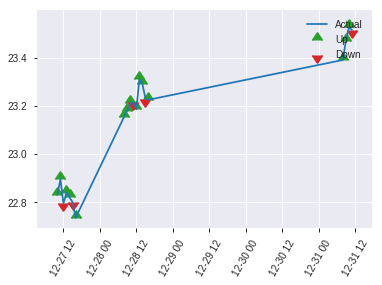


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19597785917907426
RMSE: 0.4426938662090026
LogLoss: 0.5814216484306233
Mean Per-Class Error: 0.26330049261083743
AUC: 0.7685550082101806
pr_auc: 0.7369711345546355
Gini: 0.5371100164203613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4425053596496582: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   39   0.3362   (39.0/116.0)
1      24   81   0.2286   (24.0/105.0)
Total  101  120  0.2851   (63.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442505     0.72      119
max f2                       0.167044     0.831974  192
max f0point5                 0.572828     0.748299  83
max accuracy                 0.572828     0.742081  83
max precision                0.934971     1         0
max recall                   0.0600458    1         220
max specificity              0.934971     1         0
max absolute_mcc             0.572828     0.487025  83
max min_per_class_accuracy   0.486516     0.704762  106
max mean_per_class_accuracy  0.572828     0.7367    83

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 46.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.924478           2.10476   2.10476            1                0.931652  1                           0.931652            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.899388           1.05238   1.68381            0.5              0.908878  0.8                         0.922542            0.00952381      0.0380952                  5.2381    68.381
    3        0.0316742                   0.876418           2.10476   1.80408            1                0.896716  0.857143                    0.915163            0.0190476       0.0571429                  110.476   80.4082
    4        0.040724                    0.858945           2.10476   1.8709             1                0.861407  0.888889                    0.903218            0.0190476       0.0761905                  110.476   87.0899
    5        0.0542986                   0.835847           1.40317   1.75397            0.666667         0.848993  0.833333                    0.889662            0.0190476       0.0952381                  40.3175   75.3968
    6        0.104072                    0.776237           1.91342   1.83023            0.909091         0.802222  0.869565                    0.847843            0.0952381       0.190476                   91.342    83.0228
    7        0.153846                    0.726263           1.33939   1.67143            0.636364         0.746306  0.794118                    0.814993            0.0666667       0.257143                   33.9394   67.1429
    8        0.20362                     0.693409           1.91342   1.73058            0.909091         0.712403  0.822222                    0.789915            0.0952381       0.352381                   91.342    73.0582
    9        0.303167                    0.631112           1.53074   1.66496            0.727273         0.660094  0.791045                    0.747287            0.152381        0.504762                   53.0736   66.4961
    10       0.402715                    0.557205           1.24372   1.56083            0.590909         0.588717  0.741573                    0.70809             0.12381         0.628571                   24.3723   56.0835
    11       0.502262                    0.46683            0.95671   1.4411             0.454545         0.515522  0.684685                    0.669923            0.0952381       0.72381                    -4.329    44.1098
    12       0.60181                     0.394915           0.669697  1.3135             0.318182         0.430072  0.62406                     0.630249            0.0666667       0.790476                   -33.0303  31.3498
    13       0.701357                    0.297403           0.765368  1.2357             0.363636         0.349963  0.587097                    0.590466            0.0761905       0.866667                   -23.4632  23.5699
    14       0.800905                    0.220867           0.478355  1.14157            0.227273         0.256892  0.542373                    0.549005            0.047619        0.914286                   -52.1645  14.1566
    15       0.900452                    0.133584           0.574026  1.07882            0.272727         0.17757   0.512563                    0.507942            0.0571429       0.971429                   -42.5974  7.88227
    16       1                           0.0600458          0.287013  1                  0.136364         0.101036  0.475113                    0.467435          

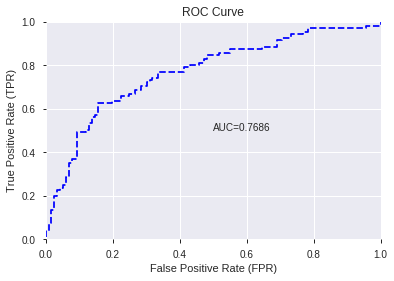

This function is available for GLM models only


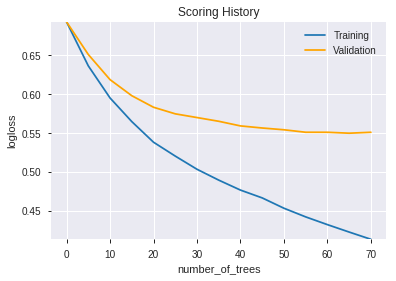

--2019-07-25 06:37:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

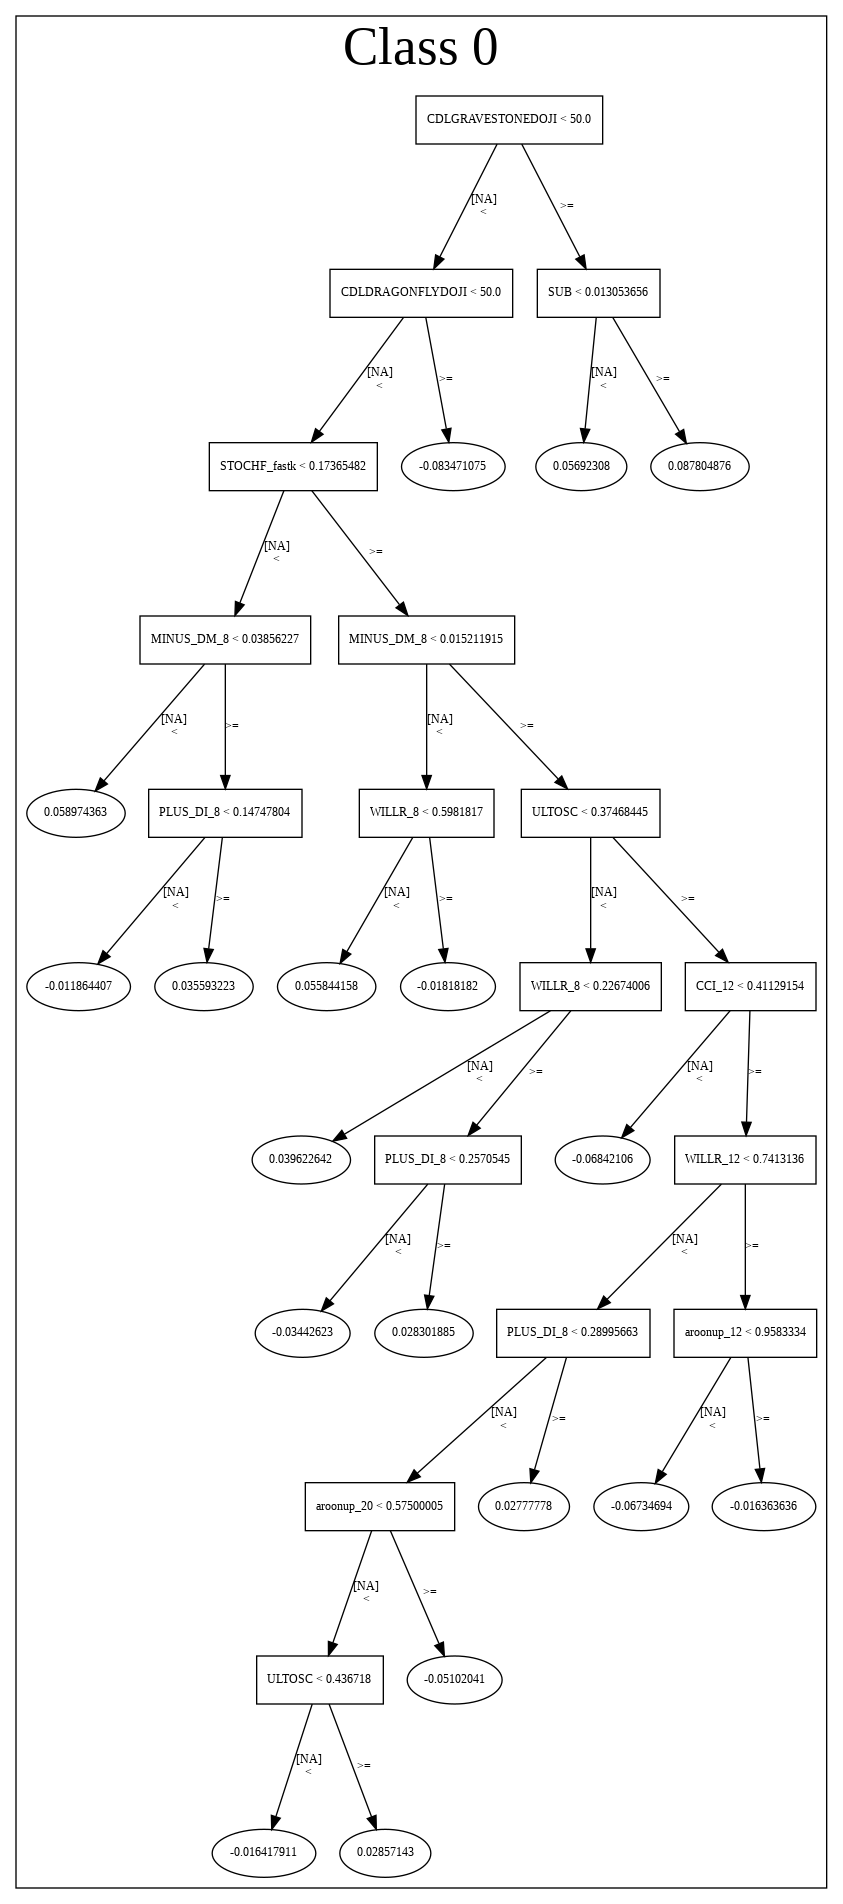

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_063646_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_063646_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'Volume',
 'TRANGE',
 'ADOSC',
 'SAREXT',
 'CORREL_30',
 'BETA_8',
 'ULTOSC',
 'STOCH_slowd',
 'DX_8',
 'HT_DCPERIOD',
 'hour',
 'STOCHRSI_fastd',
 'WILLR_8',
 'CORREL_12',
 'CORREL_20',
 'CORREL_24',
 'SUB',
 'WILLR_12',
 'aroonup_8',
 'WILLR_20',
 'WILLR_24',
 'day',
 'CDLLONGLINE',
 'WILLR_14',
 'dayofweek',
 'aroonup_24',
 'AROONOSC_8',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'weekday_name',
 'HT_TRENDMODE',
 'CDLSPINNINGTOP',
 'weekday',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CDLDOJI',
 'CDLBELTHOLD']

In [0]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 933] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


82

['BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'MOM_12',
 'PLUS_DI_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MINUS_DI_14',
 'MOM_14',
 'PLUS_DI_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MOM_20',
 'PLUS_DI_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'MOM_24',
 'PLUS_DI_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'MOM_30',
 'PLUS_DI_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_063714_model_9  0.759934  0.589847              0.311905  0.450298  0.202768
1  DeepLearning_grid_1_AutoML_20190725_063714_model_5  0.758046  0.606646              0.295115  0.451690  0.204023
2  DeepLearning_grid_1_AutoML_20190725_063714_model_6  0.754105  0.605495              0.312808  0.455805  0.207758
3  DeepLearning_grid_1_AutoML_20190725_063714_model_8  0.735550  0.633290              0.369089  0.459712  0.211335
4  DeepLearning_grid_1_AutoML_20190725_063714_model_4  0.720197  0.689518              0.341626  0.475407  0.226012
5               DeepLearning_1_AutoML_20190725_063714  0.710837  0.697409              0.346839  0.484314  0.234560
6  DeepLearning_grid_1_AutoML_20190725_063714_model_1  0.706650  0.999297              0.334811  0.515246  0.265478
7  DeepLearning_grid_1_AutoML_20190725_063714_model_3  0.698604  0.675289              0.334565  0.476508  0.227060
8  DeepLearning_grid_1_AutoML_20190725_063714_model_7  0.688259  0.673197              0.380870  0.482341  0.232653
9  DeepLearning_grid_1_AutoML_20190725_063714_model_2  0.680542  0.757038              0.399713  0.491681  0.241750

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.048713
1          CDLLONGLINE             0.879888           0.879888    0.042862
2                  BOP             0.566667           0.566667    0.027604
3                  SUB             0.451457           0.451457    0.021992
4               TRANGE             0.445536           0.445536    0.021703
..                 ...                  ...                ...         ...
77             ROCP_24             0.185129           0.185129    0.009018
78              ROC_14             0.183134           0.183134    0.008921
79              MOM_24             0.181506           0.181506    0.008842
80              RSI_12             0.180021           0.180021    0.008769
81             ROCR_14             0.178547           0.178547    0.008697

[82 rows x 4 columns]

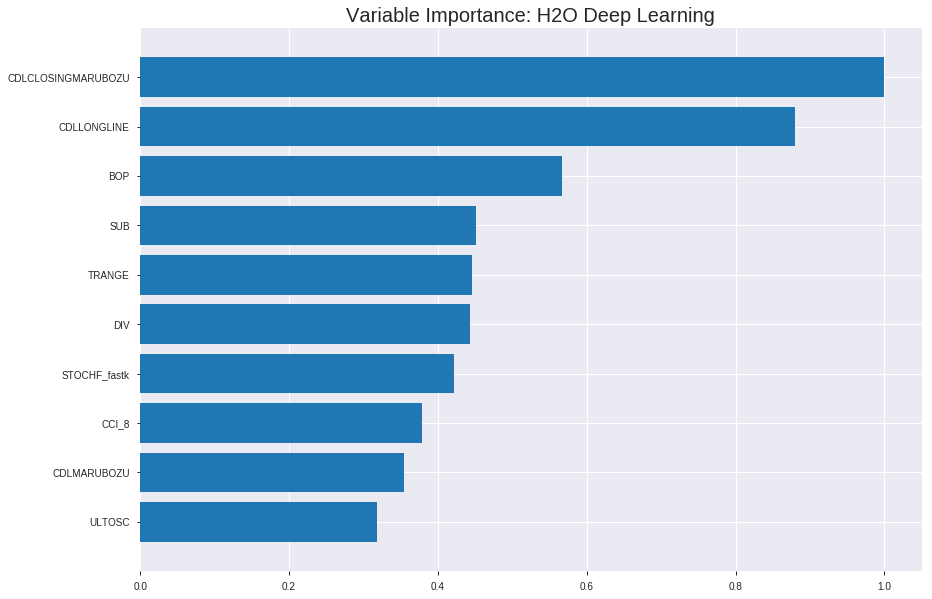

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_063714_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19104283588934665
RMSE: 0.43708447225833436
LogLoss: 0.5657238327058078
Mean Per-Class Error: 0.2836437464344441
AUC: 0.7930979227490855
pr_auc: 0.7766923761773741
Gini: 0.586195845498171
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4678675367727548: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      422  348   0.4519   (348.0/770.0)
1      100  674   0.1292   (100.0/774.0)
Total  522  1022  0.2902   (448.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467868     0.750557  236
max f2                       0.271528     0.85244   329
max f0point5                 0.519987     0.719196  193
max accuracy                 0.519987     0.716321  193
max precision                0.946875     1         0
max recall                   0.109832     1         398
max specificity              0.946875     1         0
max absolute_mcc             0.483963     0.444334  225
max min_per_class_accuracy   0.517004     0.709302  196
max mean_per_class_accuracy  0.519987     0.716356  193

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.938094           1.74548   1.74548            0.875            0.941964  0.875                       0.941964            0.0180879       0.0180879                  74.5478   74.5478
    2        0.0200777                   0.929417           1.86184   1.80178            0.933333         0.933274  0.903226                    0.937759            0.0180879       0.0361757                  86.1843   80.1784
    3        0.0304404                   0.909964           1.74548   1.78262            0.875            0.920552  0.893617                    0.931901            0.0180879       0.0542636                  74.5478   78.2616
    4        0.0401554                   0.894436           1.72885   1.76961            0.866667         0.902194  0.887097                    0.924714            0.0167959       0.0710594                  72.8854   76.9609
    5        0.0505181                   0.861457           1.6208    1.73908            0.8125           0.876362  0.871795                    0.914796            0.0167959       0.0878553                  62.0801   73.9084
    6        0.100389                    0.805259           1.83939   1.78891            0.922078         0.834982  0.896774                    0.875147            0.0917313       0.179587                   83.9391   78.8914
    7        0.150259                    0.697352           1.70986   1.76267            0.857143         0.7427    0.883621                    0.831188            0.0852713       0.264858                   70.9856   76.2675
    8        0.20013                     0.642264           1.58032   1.71723            0.792208         0.667086  0.860841                    0.790295            0.0788114       0.343669                   58.0321   71.7234
    9        0.29987                     0.573671           1.32125   1.58553            0.662338         0.606242  0.794816                    0.729077            0.131783        0.475452                   32.1252   58.5525
    10       0.400259                    0.538825           1.24838   1.50097            0.625806         0.553936  0.752427                    0.68515             0.125323        0.600775                   24.8379   50.0966
    11       0.5                         0.515569           1.10104   1.42119            0.551948         0.526622  0.712435                    0.653526            0.109819        0.710594                   10.1044   42.1189
    12       0.599741                    0.493638           0.984463  1.34856            0.493506         0.506554  0.676026                    0.629084            0.0981912       0.808786                   -1.55374  34.8558
    13       0.70013                     0.440835           0.875152  1.28068            0.43871          0.472144  0.641998                    0.606581            0.0878553       0.896641                   -12.4848  28.0678
    14       0.79987                     0.325981           0.556999  1.19044            0.279221         0.390437  0.596761                    0.579628            0.0555556       0.952196                   -44.3001  19.0438
    15       0.899611                    0.233676           0.246116  1.08574            0.123377         0.271451  0.544276                    0.54546             0.0245478       0.976744                   -75.3884  8.57401
    16       1                           0.103836           0.231658  1                  0.116129         0.189738  0.501295                    0.50975          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19444853519170013
RMSE: 0.44096319029109465
LogLoss: 0.5701994971578173
Mean Per-Class Error: 0.26869428854407396
AUC: 0.7780311158798283
pr_auc: 0.7538100080836387
Gini: 0.5560622317596566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39096077858757494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  113  0.485    (113.0/233.0)
1      26   182  0.125    (26.0/208.0)
Total  146  295  0.3152   (139.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390961     0.723658  262
max f2                       0.26889      0.839599  325
max f0point5                 0.504883     0.717054  185
max accuracy                 0.504883     0.732426  185
max precision                0.948584     1         0
max recall                   0.166711     1         386
max specificity              0.948584     1         0
max absolute_mcc             0.504883     0.462869  185
max min_per_class_accuracy   0.498988     0.716738  192
max mean_per_class_accuracy  0.504883     0.731306  185

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 47.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.931526           2.12019   2.12019            1                0.938435  1                           0.938435            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.921545           2.12019   2.12019            1                0.927767  1                           0.933694            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.894763           2.12019   2.12019            1                0.909476  1                           0.925045            0.0240385       0.0673077                  112.019   112.019
    4        0.0408163                   0.857848           2.12019   2.12019            1                0.872618  1                           0.913394            0.0192308       0.0865385                  112.019   112.019
    5        0.0521542                   0.84085            1.69615   2.02801            0.8              0.851021  0.956522                    0.899835            0.0192308       0.105769                   69.6154   102.801
    6        0.102041                    0.717649           1.83108   1.93173            0.863636         0.78152   0.911111                    0.841992            0.0913462       0.197115                   83.1075   93.1731
    7        0.151927                    0.651607           1.54196   1.80375            0.727273         0.680196  0.850746                    0.788865            0.0769231       0.274038                   54.1958   80.3746
    8        0.201814                    0.589876           1.34921   1.69139            0.636364         0.615165  0.797753                    0.745928            0.0673077       0.341346                   34.9213   69.1389
    9        0.301587                    0.547541           1.25284   1.54631            0.590909         0.564155  0.729323                    0.685792            0.125           0.466346                   25.2841   54.6306
    10       0.401361                    0.522506           1.54196   1.54522            0.727273         0.535391  0.728814                    0.648404            0.153846        0.620192                   54.1958   54.5225
    11       0.501134                    0.491578           1.0601    1.44864            0.5              0.509363  0.683258                    0.620722            0.105769        0.725962                   6.00962   44.8638
    12       0.600907                    0.445732           0.819165  1.34412            0.386364         0.468752  0.633962                    0.595489            0.0817308       0.807692                   -18.0835  34.4122
    13       0.70068                     0.363345           0.770979  1.26251            0.363636         0.405253  0.595469                    0.568401            0.0769231       0.884615                   -22.9021  26.2509
    14       0.800454                    0.286863           0.62642   1.18322            0.295455         0.320199  0.558074                    0.537463            0.0625          0.947115                   -37.358   18.3223
    15       0.900227                    0.222731           0.240931  1.07879            0.113636         0.253139  0.508816                    0.505951            0.0240385       0.971154                   -75.9069  7.8788
    16       1                           0.0995467          0.289117  1                  0.136364         0.177216  0.471655                    0.473152          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:46:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:46:25  3 min 11.427 sec  470 obs/sec       0.715026  1             1104       0.526081         0.891188            -0.107051      0.738912        0.724856           1.74548          0.349741                         0.521241           0.850045              -0.0902736       0.743067          0.723847             2.12019            0.328798
    2019-07-25 06:46:40  3 min 26.104 sec  723 obs/sec       7.32319   10            11307      0.452928         0.596922            0.17942        0.75663         0.745382           1.87016          0.333549                         0.453654           0.596202              0.174136         0.755251          0.734458             2.12019            0.333333
    2019-07-25 06:46:54  3 min 40.500 sec  830 obs/sec       15.3886   21            23760      0.447629         0.586955            0.198507       0.775069        0.762315           1.87016          0.320596                         0.447397           0.585307              0.196762         0.778887          0.758513             2.12019            0.285714
    2019-07-25 06:47:09  3 min 54.810 sec  896 obs/sec       24.1108   33            37227      0.442471         0.575421            0.216872       0.776453        0.760935           1.6208           0.306347                         0.44398            0.576686              0.208986         0.778599          0.75617              2.12019            0.324263
    2019-07-25 06:47:23  4 min  9.487 sec  947 obs/sec       33.6373   46            51936      0.443002         0.57751             0.21499        0.774704        0.758865           1.74548          0.32772                          0.447356           0.585612              0.19691          0.76334           0.75108              2.12019            0.297052
    2019-07-25 06:47:38  4 min 24.843 sec  980 obs/sec       43.2073   59            66712      0.437039         0.565948            0.235982       0.782464        0.765663           1.74548          0.29728                          0.443195           0.575888              0.211778         0.770758          0.75548              2.12019            0.287982
    2019-07-25 06:48:00  4 min 46.060 sec  1030 obs/sec      58.6367   80            90535      0.437084         0.565724            0.235824       0.793098        0.776692           1.74548          0.290155                         0.440963           0.570199              0.219698         0.778031          0.75381              2.12019            0.315193

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.048712500891616814
CDLLONGLINE         0.8798879981040955     0.8798879981040955   0.04286154489216869
BOP                 0.5666670203208923     0.5666670203208923   0.02760376773263131
SUB                 0.45145729184150696    0.45145729184150696  0.02199161373135632
TRANGE              0.44553619623184204    0.44553619623184204  0.021703182356191168
---                 ---                    ---                  ---
ROCP_24             0.1851292848587036     0.1851292848587036   0.009018110453743983
ROC_14              0.18313436210155487    0.18313436210155487  0.008920932777157668
MOM_24              0.18150629103183746    0.18150629103183746  0.008841625363722443
RSI_12              0.180021271109581      0.180021271109581    0.008769286329435456
ROCR_14             0.17854668200016022    0.17854668200016022  0.008697455406128029


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7149321266968326)

('F1', 0.7215686274509803)

('auc', 0.7599343185550083)

('logloss', 0.5898473991024773)

('mean_per_class_error', 0.2887110016420362)

('rmse', 0.45029750125494955)

('mse', 0.2027678396364513)

deeplearning prediction progress: |███████████████████████████████████████| 100%


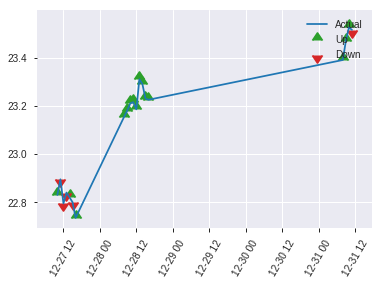


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2027678396364513
RMSE: 0.45029750125494955
LogLoss: 0.5898473991024773
Mean Per-Class Error: 0.2887110016420362
AUC: 0.7599343185550083
pr_auc: 0.7352875978485616
Gini: 0.5198686371100165
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36993437284010056: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   58   0.5      (58.0/116.0)
1      13   92   0.1238   (13.0/105.0)
Total  71   150  0.3213   (71.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369934     0.721569  149
max f2                       0.236527     0.829228  188
max f0point5                 0.519304     0.708245  91
max accuracy                 0.519304     0.714932  91
max precision                0.942515     1         0
max recall                   0.149814     1         216
max specificity              0.942515     1         0
max absolute_mcc             0.519304     0.428097  91
max min_per_class_accuracy   0.498198     0.67619   106
max mean_per_class_accuracy  0.519304     0.711289  91

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 46.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.916255           2.10476   2.10476            1                0.931875  1                           0.931875            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.908798           2.10476   2.10476            1                0.912991  1                           0.924321            0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.89333            2.10476   2.10476            1                0.903594  1                           0.918399            0.0190476       0.0666667                  110.476   110.476
    4        0.040724                    0.858211           2.10476   2.10476            1                0.888383  1                           0.911729            0.0190476       0.0857143                  110.476   110.476
    5        0.0542986                   0.841558           1.40317   1.92937            0.666667         0.846152  0.916667                    0.895335            0.0190476       0.104762                   40.3175   92.9365
    6        0.104072                    0.664756           1.53074   1.73872            0.727273         0.747876  0.826087                    0.824811            0.0761905       0.180952                   53.0736   73.8716
    7        0.153846                    0.597982           1.53074   1.67143            0.727273         0.623094  0.794118                    0.759549            0.0761905       0.257143                   53.0736   67.1429
    8        0.20362                     0.573515           1.72208   1.68381            0.818182         0.579298  0.8                         0.715488            0.0857143       0.342857                   72.2078   68.381
    9        0.303167                    0.538823           1.33939   1.57072            0.636364         0.554041  0.746269                    0.662476            0.133333        0.47619                    33.9394   57.0718
    10       0.402715                    0.523342           1.33939   1.51354            0.636364         0.530654  0.719101                    0.629891            0.133333        0.609524                   33.9394   51.3537
    11       0.502262                    0.494719           0.861039  1.38421            0.409091         0.50958   0.657658                    0.606045            0.0857143       0.695238                   -13.8961  38.4213
    12       0.60181                     0.451885           0.765368  1.28185            0.363636         0.470165  0.609023                    0.583569            0.0761905       0.771429                   -23.4632  28.1847
    13       0.701357                    0.339997           1.14805   1.26286            0.545455         0.394348  0.6                         0.556712            0.114286        0.885714                   14.8052   26.2857
    14       0.800905                    0.275955           0.382684  1.15346            0.181818         0.300794  0.548023                    0.524903            0.0380952       0.92381                    -61.7316  15.3457
    15       0.900452                    0.212953           0.382684  1.06825            0.181818         0.237652  0.507538                    0.493146            0.0380952       0.961905                   -61.7316  6.8246
    16       1                           0.088589           0.382684  1                  0.181818         0.167535  0.475113                    0.460733           

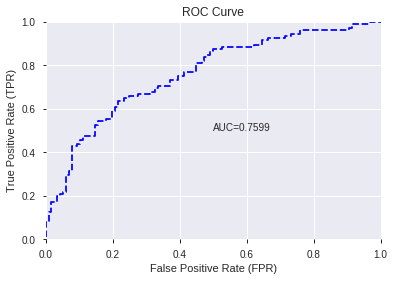

This function is available for GLM models only


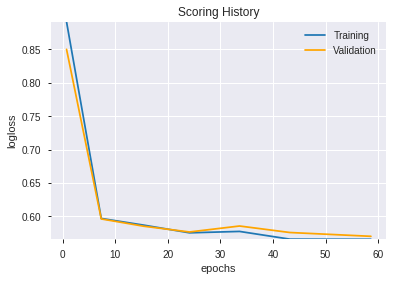

['CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'BOP',
 'SUB',
 'TRANGE',
 'DIV',
 'STOCHF_fastk',
 'CCI_8',
 'CDLMARUBOZU',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CCI_12',
 'CDLBELTHOLD',
 'ADOSC',
 'CDLENGULFING',
 'WILLR_8',
 'CCI_14',
 'PLUS_DI_30',
 'WILLR_14',
 'STOCHRSI_fastd',
 'STOCH_slowk',
 'MINUS_DM_8',
 'WILLR_12',
 'CMO_30',
 'WILLR_20',
 'CCI_20',
 'RSI_30',
 'PLUS_DI_20',
 'MINUS_DI_14',
 'PLUS_DI_24',
 'WILLR_24',
 'PLUS_DI_8',
 'MINUS_DI_8',
 'ROCR100_20',
 'STOCHF_fastd',
 'MINUS_DI_12',
 'MOM_20',
 'ROCP_20',
 'ROCR_8',
 'RSI_24',
 'LINEARREG_ANGLE_8',
 'CMO_24',
 'ROCR100_12',
 'ROC_20',
 'WILLR_30',
 'PLUS_DI_14',
 'ROC_24',
 'ROCR_20',
 'PLUS_DI_12',
 'ROC_8',
 'MOM_30',
 'ROCP_12',
 'CMO_20',
 'ROCR100_24',
 'ROCP_30',
 'CCI_30',
 'ROCR_30',
 'MOM_8',
 'MOM_12',
 'ROC_12',
 'ROC_30',
 'ROCR100_30',
 'ROCR_12',
 'RSI_20',
 'LINEARREG_SLOPE_8',
 'ROCP_8',
 'MOM_14',
 'RSI_8',
 'RSI_14',
 'CMO_8',
 'ROCR100_14',
 'ROCR_24',
 'CMO_12',
 'ROCR100_8',
 'CMO_14',
 'ROCP_14',
 'CCI_24

In [0]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse     mse
0  GLM_grid_1_AutoML_20190725_064809_model_1  0.766092   0.5968              0.316215  0.445309  0.1983

variable  relative_importance  scaled_importance  percentage
0            SUB             0.911432           1.000000    0.060051
1   STOCHF_fastk             0.843780           0.925774    0.055593
2     PLUS_DI_30             0.668674           0.733652    0.044056
3          CCI_8             0.604117           0.662822    0.039803
4            BOP             0.560012           0.614430    0.036897
..           ...                  ...                ...         ...
77     ROCR100_8             0.017815           0.019547    0.001174
78        CMO_30             0.016924           0.018569    0.001115
79    ROCR100_24             0.015391           0.016887    0.001014
80     PLUS_DI_8             0.008312           0.009119    0.000548
81        TRANGE             0.000854           0.000937    0.000056

[82 rows x 4 columns]

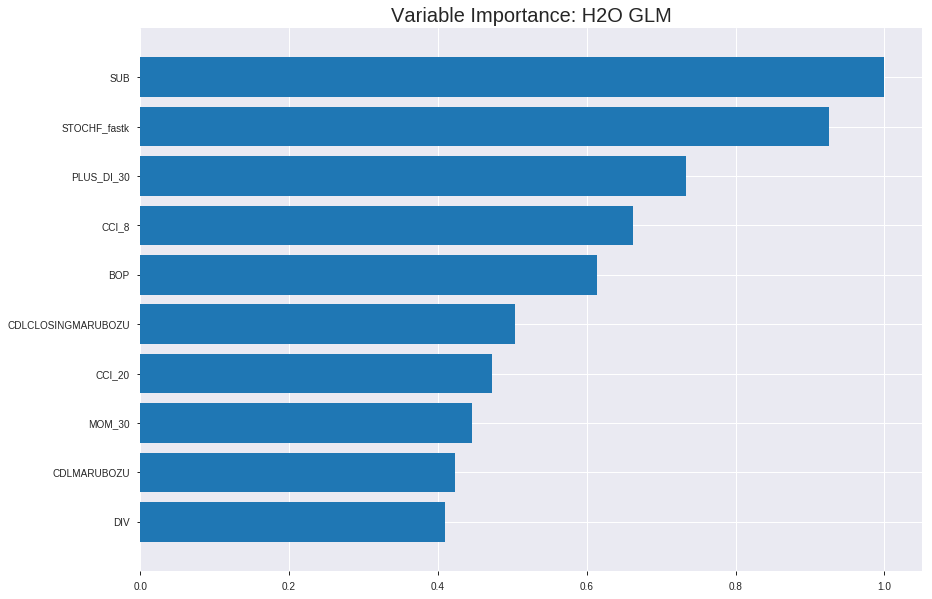

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_064809_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18773887446648174
RMSE: 0.4332884425720143
LogLoss: 0.5549423231257853
Null degrees of freedom: 1543
Residual degrees of freedom: 1461
Null deviance: 2140.428130863218
Residual deviance: 1713.661893812425
AIC: 1879.661893812425
AUC: 0.787534816604584
pr_auc: 0.7704748140634281
Gini: 0.575069633209168
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39053990516182646: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      411  359   0.4662   (359.0/770.0)
1      97   677   0.1253   (97.0/774.0)
Total  508  1036  0.2953   (456.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39054      0.748066  255
max f2                       0.215457     0.855158  323
max f0point5                 0.587678     0.726257  160
max accuracy                 0.554402     0.710492  177
max precision                0.985229     1         0
max recall                   0.0295552    1         391
max specificity              0.985229     1         0
max absolute_mcc             0.39054      0.434646  255
max min_per_class_accuracy   0.524931     0.702842  193
max mean_per_class_accuracy  0.554402     0.710613  177

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.951877           1.87016   1.87016            0.9375           0.962765   0.9375                      0.962765            0.0193798       0.0193798                  87.0155   87.0155
    2        0.0200777                   0.930801           1.72885   1.80178            0.866667         0.943965   0.903226                    0.953668            0.0167959       0.0361757                  72.8854   80.1784
    3        0.0304404                   0.910345           1.87016   1.82506            0.9375           0.920869   0.914894                    0.942502            0.0193798       0.0555556                  87.0155   82.5059
    4        0.0401554                   0.896553           1.72885   1.80178            0.866667         0.902465   0.903226                    0.932816            0.0167959       0.0723514                  72.8854   80.1784
    5        0.0505181                   0.88282            1.74548   1.79023            0.875            0.889427   0.897436                    0.923916            0.0180879       0.0904393                  74.5478   79.0234
    6        0.100389                    0.823351           1.68395   1.73743            0.844156         0.853331   0.870968                    0.888851            0.0839793       0.174419                   68.3949   73.7434
    7        0.150259                    0.763504           1.60623   1.69389            0.805195         0.79157    0.849138                    0.856564            0.0801034       0.254522                   60.6228   69.3888
    8        0.20013                     0.725246           1.5026    1.64622            0.753247         0.743614   0.825243                    0.828418            0.0749354       0.329457                   50.2601   64.6221
    9        0.29987                     0.651714           1.46374   1.58553            0.733766         0.690446   0.794816                    0.782527            0.145995        0.475452                   46.374    58.5525
    10       0.400259                    0.584769           1.3256    1.52033            0.664516         0.617276   0.762136                    0.74108             0.133075        0.608527                   32.5598   52.0333
    11       0.5                         0.523086           0.945602  1.40568            0.474026         0.555137   0.704663                    0.703988            0.0943152       0.702842                   -5.43978  40.5685
    12       0.599741                    0.44795            1.02332   1.3421             0.512987         0.485691   0.672786                    0.667684            0.102067        0.80491                    2.33229   34.2095
    13       0.70013                     0.364704           0.849412  1.27145            0.425806         0.407273   0.637373                    0.630344            0.0852713       0.890181                   -15.0588  27.1452
    14       0.79987                     0.265844           0.595859  1.18721            0.298701         0.319851   0.595142                    0.591627            0.0594315       0.949612                   -40.4141  18.7208
    15       0.899611                    0.13673            0.362697  1.09579            0.181818         0.203887   0.549316                    0.548638            0.0361757       0.985788                   -63.7303  9.57933
    16       1                           0.00402979         0.141569  1                  0.0709677        0.0770455  0.501295                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18388697091387365
RMSE: 0.4288204413433129
LogLoss: 0.5498772174954784
Null degrees of freedom: 440
Residual degrees of freedom: 358
Null deviance: 611.4883070433551
Residual deviance: 484.9917058310119
AIC: 650.9917058310119
AUC: 0.8029877847474414
pr_auc: 0.7734699863339387
Gini: 0.6059755694948827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41231539697965247: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  99   0.4249   (99.0/233.0)
1      27   181  0.1298   (27.0/208.0)
Total  161  280  0.2857   (126.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412315     0.741803  253
max f2                       0.170628     0.837459  342
max f0point5                 0.58686      0.75237   143
max accuracy                 0.58686      0.743764  143
max precision                0.962279     1         0
max recall                   0.0302785    1         392
max specificity              0.962279     1         0
max absolute_mcc             0.58686      0.492001  143
max min_per_class_accuracy   0.510806     0.742489  193
max mean_per_class_accuracy  0.510806     0.743841  193

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 47.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.920545           2.12019   2.12019            1                0.936669   1                           0.936669            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.894028           2.12019   2.12019            1                0.910428   1                           0.925006            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.868589           1.69615   1.96875            0.8              0.879927   0.928571                    0.908906            0.0192308       0.0625                     69.6154   96.875
    4        0.0408163                   0.847126           1.59014   1.88462            0.75             0.859701   0.888889                    0.897972            0.0144231       0.0769231                  59.0144   88.4615
    5        0.0521542                   0.828201           2.12019   1.93583            1                0.835975   0.913043                    0.884494            0.0240385       0.100962                   112.019   93.5828
    6        0.102041                    0.775199           1.92745   1.93173            0.909091         0.798305   0.911111                    0.842357            0.0961538       0.197115                   92.7448   93.1731
    7        0.151927                    0.723087           1.44559   1.7721             0.681818         0.753386   0.835821                    0.813143            0.0721154       0.269231                   44.5586   77.2101
    8        0.201814                    0.689779           1.44559   1.69139            0.681818         0.706227   0.797753                    0.786714            0.0721154       0.341346                   44.5586   69.1389
    9        0.301587                    0.614224           1.68652   1.68978            0.795455         0.647753   0.796992                    0.740742            0.168269        0.509615                   68.6517   68.9777
    10       0.401361                    0.562542           1.34921   1.60512            0.636364         0.58607    0.757062                    0.702293            0.134615        0.644231                   34.9213   60.5117
    11       0.501134                    0.504867           1.0601    1.49661            0.5              0.531594   0.705882                    0.668307            0.105769        0.75                       6.00962   49.6606
    12       0.600907                    0.437567           0.819165  1.38413            0.386364         0.472004   0.65283                     0.635714            0.0817308       0.831731                   -18.0835  38.4126
    13       0.70068                     0.346427           0.62642   1.27623            0.295455         0.392852   0.601942                    0.601131            0.0625          0.894231                   -37.358   27.6232
    14       0.800454                    0.244545           0.481862  1.17722            0.227273         0.297514   0.555241                    0.563287            0.0480769       0.942308                   -51.8138  17.7217
    15       0.900227                    0.117135           0.337303  1.08413            0.159091         0.186409   0.511335                    0.521517            0.0336538       0.975962                   -66.2697  8.41286
    16       1                           0.00490838         0.240931  1                  0.113636         0.0626577  0.471655                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 06:48:09  0.000 sec   2            .2E2      83            1.3550316991515376  1.3633508401868926
     2019-07-25 06:48:09  0.019 sec   4            .12E2     83            1.3446944162100334  1.3548184312448155
     2019-07-25 06:48:09  0.037 sec   6            .76E1     83            1.3322372175891026  1.3435388092122411
     2019-07-25 06:48:09  0.055 sec   8            .47E1     83            1.317108047061916   1.3284660290183268
     2019-07-25 06:48:09  0.073 sec   10           .29E1     83            1.2988552647380345  1.3088303235482728
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 06:48:09  0.420 sec   46           .55E-3    83            1.1086091854332787  1.0999917358521611
     2019-07-25 06:48:09  0.441 sec   48           .34E-3    83            1.1076934990924212  1.1006812782718023
     2019-07-25 06:48:09  0.462 sec   50           .21E-3    83            1.106773499928114   1.1015146074351763
     2019-07-25 06:48:09  0.483 sec   52           .13E-3    83            1.1060040267081814  1.1023399790693822
     2019-07-25 06:48:09  0.504 sec   54           .82E-4    83            1.1053121426197272  1.1031339837925145


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7194570135746606)

('F1', 0.71875)

('auc', 0.7660919540229885)

('logloss', 0.596800490048474)

('mean_per_class_error', 0.28078817733990147)

('rmse', 0.445308671895101)

('mse', 0.1982998132649787)

glm prediction progress: |████████████████████████████████████████████████| 100%


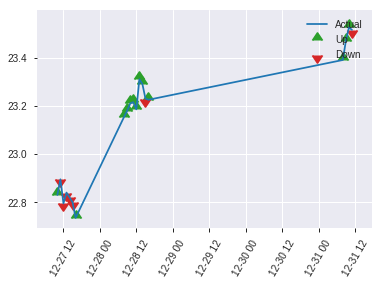


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1982998132649787
RMSE: 0.445308671895101
LogLoss: 0.596800490048474
Null degrees of freedom: 220
Residual degrees of freedom: 138
Null deviance: 306.4295320199308
Residual deviance: 263.7858166014255
AIC: 429.7858166014255
AUC: 0.7660919540229885
pr_auc: 0.7443842894905661
Gini: 0.5321839080459769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37718255650508153: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   59   0.5086   (59.0/116.0)
1      13   92   0.1238   (13.0/105.0)
Total  70   151  0.3258   (72.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377183     0.71875   150
max f2                       0.0148009    0.820313  219
max f0point5                 0.589729     0.71116   87
max accuracy                 0.562005     0.719457  96
max precision                0.938319     1         0
max recall                   0.0148009    1         219
max specificity              0.938319     1         0
max absolute_mcc             0.518971     0.4381    106
max min_per_class_accuracy   0.518971     0.714286  106
max mean_per_class_accuracy  0.518971     0.719212  106

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 47.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.924163           2.10476   2.10476            1                0.935053   1                           0.935053            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.872733           2.10476   2.10476            1                0.884921   1                           0.915               0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.862683           2.10476   2.10476            1                0.867241   1                           0.901354            0.0190476       0.0666667                  110.476   110.476
    4        0.040724                    0.838018           2.10476   2.10476            1                0.850813   1                           0.890123            0.0190476       0.0857143                  110.476   110.476
    5        0.0542986                   0.835856           2.10476   2.10476            1                0.836662   1                           0.876758            0.0285714       0.114286                   110.476   110.476
    6        0.104072                    0.767194           1.33939   1.73872            0.636364         0.790475   0.826087                    0.835492            0.0666667       0.180952                   33.9394   73.8716
    7        0.153846                    0.739225           1.91342   1.79524            0.909091         0.753148   0.852941                    0.808851            0.0952381       0.27619                    91.342    79.5238
    8        0.20362                     0.710716           1.14805   1.63704            0.545455         0.722835   0.777778                    0.787825            0.0571429       0.333333                   14.8052   63.7037
    9        0.303167                    0.642855           1.33939   1.5393             0.636364         0.673001   0.731343                    0.750122            0.133333        0.466667                   33.9394   53.9303
    10       0.402715                    0.588538           1.53074   1.53719            0.727273         0.610986   0.730337                    0.715729            0.152381        0.619048                   53.0736   53.7186
    11       0.502262                    0.501353           1.05238   1.4411             0.5              0.539317   0.684685                    0.680764            0.104762        0.72381                    5.2381    44.1098
    12       0.60181                     0.436889           0.765368  1.32932            0.363636         0.471128   0.631579                    0.646088            0.0761905       0.8                        -23.4632  32.9323
    13       0.701357                    0.356922           0.765368  1.24928            0.363636         0.393559   0.593548                    0.610245            0.0761905       0.87619                    -23.4632  24.9278
    14       0.800905                    0.237272           0.478355  1.15346            0.227273         0.296093   0.548023                    0.571198            0.047619        0.92381                    -52.1645  15.3457
    15       0.900452                    0.111121           0.287013  1.05767            0.136364         0.170103   0.502513                    0.526856            0.0285714       0.952381                   -71.2987  5.76693
    16       1                           0.00960068         0.478355  1                  0.227273         0.0542928  0.475113                   

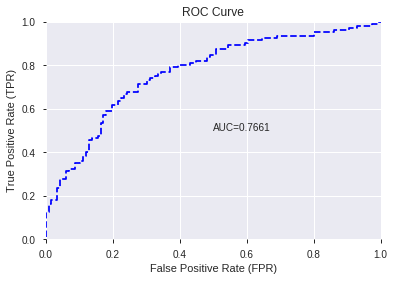

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


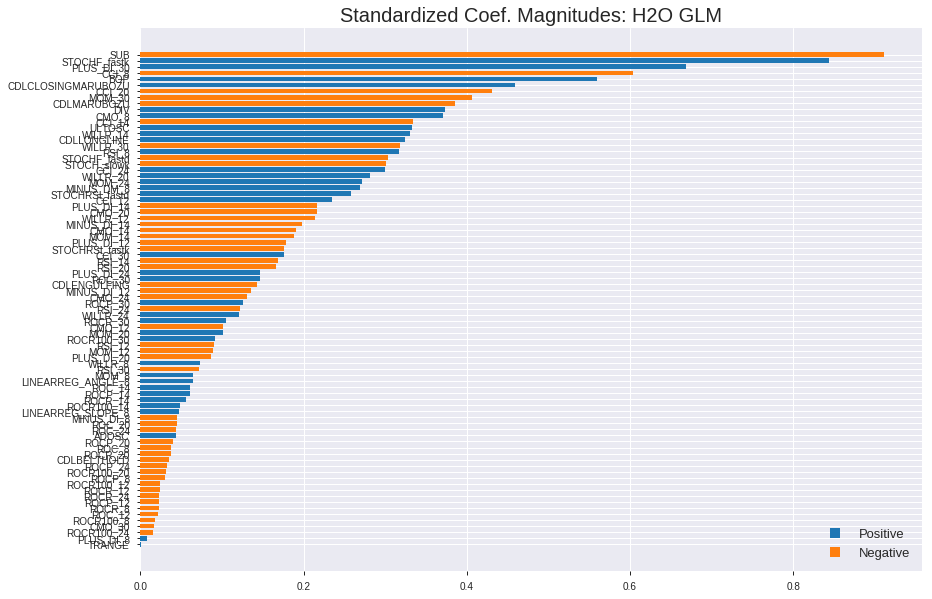

'log_likelihood'
--2019-07-25 06:48:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


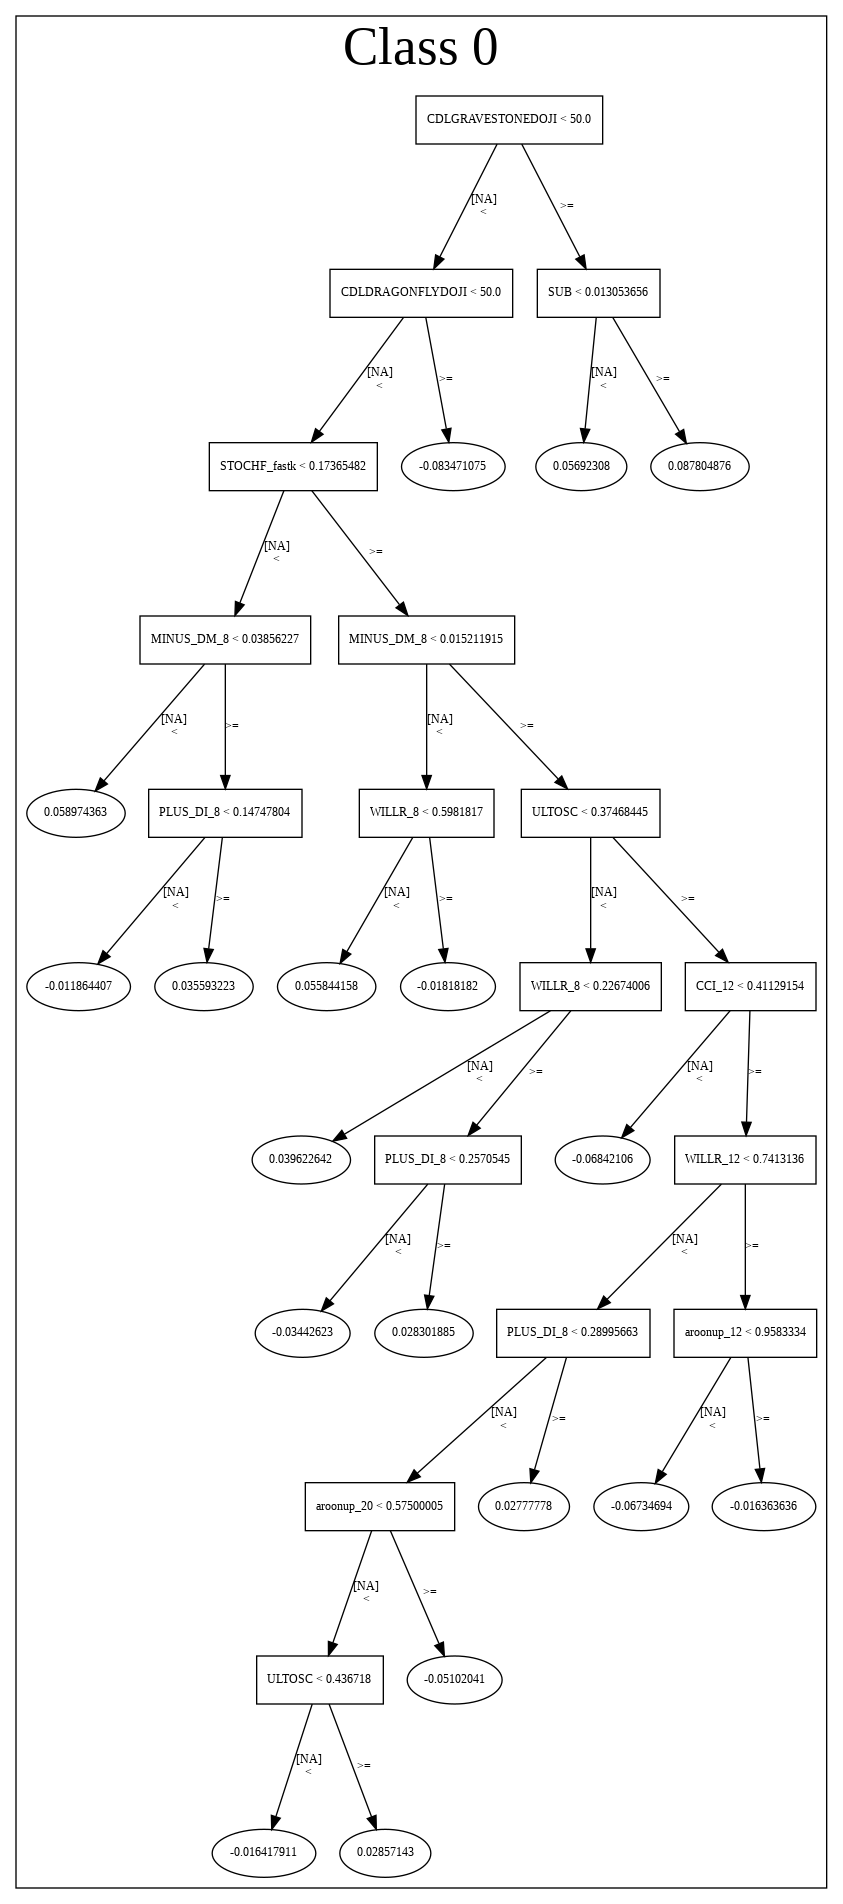

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_064809_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_064809_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['SUB',
 'STOCHF_fastk',
 'PLUS_DI_30',
 'CCI_8',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'CCI_20',
 'MOM_30',
 'CDLMARUBOZU',
 'DIV',
 'CMO_8',
 'CCI_14',
 'ULTOSC',
 'WILLR_14',
 'CDLLONGLINE',
 'WILLR_30',
 'RSI_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CCI_24',
 'WILLR_20',
 'MOM_24',
 'MINUS_DM_8',
 'STOCHRSI_fastd',
 'CCI_12',
 'PLUS_DI_14',
 'CMO_20',
 'WILLR_12',
 'MINUS_DI_14',
 'CMO_14',
 'MOM_14',
 'PLUS_DI_12',
 'STOCHRSI_fastk',
 'CCI_30',
 'RSI_14',
 'RSI_20',
 'PLUS_DI_24',
 'ROC_30',
 'CDLENGULFING',
 'MINUS_DI_12',
 'CMO_24',
 'ROCP_30',
 'RSI_24',
 'WILLR_24',
 'ROCR_30',
 'CMO_12',
 'MOM_20',
 'ROCR100_30',
 'RSI_12',
 'MOM_12',
 'PLUS_DI_20',
 'WILLR_8',
 'RSI_30',
 'MOM_8',
 'LINEARREG_ANGLE_8',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'LINEARREG_SLOPE_8',
 'MINUS_DI_8',
 'ROC_20',
 'ROC_24',
 'ADOSC',
 'ROCP_20',
 'ROC_8',
 'ROCR_20',
 'CDLBELTHOLD',
 'ROCP_24',
 'ROCR100_20',
 'ROCP_8',
 'ROCR100_12',
 'ROCR_12',
 'ROCR_24',
 'ROCP_12',
 'ROCR_8',
 'ROC_12',
 'ROC

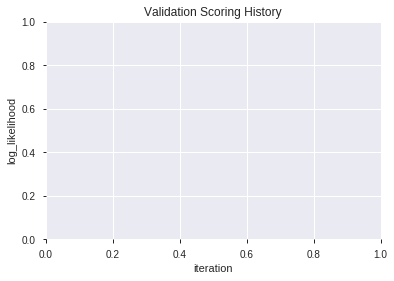

In [0]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190725_064825  0.758867  0.587549              0.304187  0.446613  0.199463
1  XGBoost_grid_1_AutoML_20190725_064825_model_6  0.756240  0.589163              0.268555  0.447039  0.199844
2  XGBoost_grid_1_AutoML_20190725_064825_model_2  0.751642  0.595932              0.281938  0.450240  0.202716
3               XGBoost_2_AutoML_20190725_064825  0.751067  0.595500              0.317570  0.450364  0.202828
4  XGBoost_grid_1_AutoML_20190725_064825_model_1  0.750575  0.604057              0.293514  0.453357  0.205533
5  XGBoost_grid_1_AutoML_20190725_064825_model_4  0.748933  0.599647              0.278530  0.452177  0.204464
6  XGBoost_grid_1_AutoML_20190725_064825_model_7  0.746141  0.605990              0.256979  0.453596  0.205749
7  XGBoost_grid_1_AutoML_20190725_064825_model_5  0.745567  0.611637              0.297824  0.455969  0.207908
8               XGBoost_3_AutoML_20190725_064825  0.741626  0.608235              0.318473  0.455616  0.207586
9  XGBoost_grid_1_AutoML_20190725_064825_model_3  0.732348  0.612104              0.310304  0.458540  0.210259

variable  relative_importance  scaled_importance  percentage
0              BOP          1363.429565           1.000000    0.150763
1     STOCHF_fastk           709.435425           0.520332    0.078447
2           TRANGE           449.976715           0.330033    0.049757
3              DIV           294.963531           0.216339    0.032616
4   STOCHRSI_fastk           276.008667           0.202437    0.030520
..             ...                  ...                ...         ...
75      ROCR100_12             6.561521           0.004813    0.000726
76         ROCR_14             6.374265           0.004675    0.000705
77     CDLBELTHOLD             4.790193           0.003513    0.000530
78     CDLMARUBOZU             3.173500           0.002328    0.000351
79    CDLENGULFING             3.053233           0.002239    0.000338

[80 rows x 4 columns]

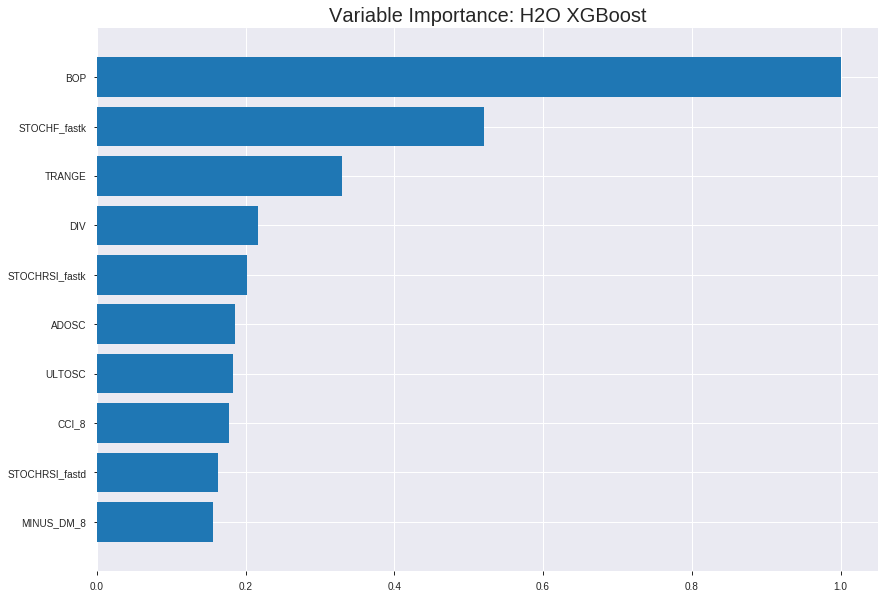

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190725_064825


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11104762535782209
RMSE: 0.3332380910967744
LogLoss: 0.37895216340344295
Mean Per-Class Error: 0.1094214570958757
AUC: 0.9539388905667976
pr_auc: 0.9511023612908217
Gini: 0.9078777811335952
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48819608241319656: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      677  93   0.1208   (93.0/770.0)
1      78   696  0.1008   (78.0/774.0)
Total  755  789  0.1108   (171.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488196     0.890595  209
max f2                       0.379483     0.919244  255
max f0point5                 0.563184     0.909994  177
max accuracy                 0.516909     0.890544  197
max precision                0.948177     1         0
max recall                   0.131087     1         364
max specificity              0.948177     1         0
max absolute_mcc             0.516909     0.781391  197
max min_per_class_accuracy   0.500009     0.887597  203
max mean_per_class_accuracy  0.516909     0.890579  197

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.924811           1.99483    1.99483            1                0.931565  1                           0.931565            0.0206718       0.0206718                  99.4832   99.4832
    2        0.0200777                   0.913606           1.99483    1.99483            1                0.917391  1                           0.924706            0.0193798       0.0400517                  99.4832   99.4832
    3        0.0304404                   0.905615           1.99483    1.99483            1                0.910461  1                           0.919857            0.0206718       0.0607235                  99.4832   99.4832
    4        0.0401554                   0.893749           1.99483    1.99483            1                0.900867  1                           0.915263            0.0193798       0.0801034                  99.4832   99.4832
    5        0.0505181                   0.885558           1.99483    1.99483            1                0.889036  1                           0.909883            0.0206718       0.100775                   99.4832   99.4832
    6        0.100389                    0.849592           1.94302    1.96909            0.974026         0.867427  0.987097                    0.888792            0.0968992       0.197674                   94.3018   96.9092
    7        0.150259                    0.807305           1.99483    1.97764            1                0.830761  0.991379                    0.869532            0.0994832       0.297158                   99.4832   97.7635
    8        0.20013                     0.766022           1.96893    1.97546            0.987013         0.785981  0.990291                    0.848711            0.0981912       0.395349                   96.8925   97.5465
    9        0.29987                     0.700179           1.8653     1.93882            0.935065         0.734989  0.971922                    0.810886            0.186047        0.581395                   86.5297   93.8822
    10       0.400259                    0.613439           1.7503     1.89154            0.877419         0.66103   0.94822                     0.773301            0.175711        0.757106                   75.0304   89.154
    11       0.5                         0.497755           1.3083     1.77519            0.655844         0.556184  0.889896                    0.72999             0.130491        0.887597                   30.8299   77.5194
    12       0.599741                    0.407556           0.621766   1.58337            0.311688         0.452258  0.793737                    0.683801            0.0620155       0.949612                   -37.8234  58.3371
    13       0.70013                     0.313204           0.334617   1.40432            0.167742         0.359324  0.703978                    0.637276            0.0335917       0.983204                   -66.5383  40.4317
    14       0.79987                     0.225078           0.116581   1.24374            0.0584416        0.268584  0.623482                    0.591301            0.0116279       0.994832                   -88.3419  24.3741
    15       0.899611                    0.139109           0.0388604  1.11015            0.0194805        0.180384  0.556515                    0.545742            0.00387597      0.998708                   -96.114   11.0155
    16       1                           0.0516494          0.0128699  1                  0.00645161       0.102863  0.501295                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18839921147965985
RMSE: 0.43404977995577865
LogLoss: 0.5522748686803787
Mean Per-Class Error: 0.2870584351271046
AUC: 0.7826015186530207
pr_auc: 0.7795582896234385
Gini: 0.5652030373060415
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3099154829978943: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  120  0.515    (120.0/233.0)
1      24   184  0.1154   (24.0/208.0)
Total  137  304  0.3265   (144.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309915     0.71875   272
max f2                       0.139489     0.840744  367
max f0point5                 0.626132     0.703593  103
max accuracy                 0.414323     0.709751  214
max precision                0.940668     1         0
max recall                   0.139489     1         367
max specificity              0.940668     1         0
max absolute_mcc             0.414323     0.426871  214
max min_per_class_accuracy   0.459127     0.692308  193
max mean_per_class_accuracy  0.414323     0.712942  214

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 45.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.914544           2.12019   2.12019            1                0.928549  1                           0.928549            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.890176           2.12019   2.12019            1                0.900885  1                           0.916254            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.874117           2.12019   2.12019            1                0.880554  1                           0.903504            0.0240385       0.0673077                  112.019   112.019
    4        0.0408163                   0.85975            2.12019   2.12019            1                0.865869  1                           0.895141            0.0192308       0.0865385                  112.019   112.019
    5        0.0521542                   0.84633            2.12019   2.12019            1                0.854126  1                           0.886224            0.0240385       0.110577                   112.019   112.019
    6        0.102041                    0.790128           2.12019   2.12019            1                0.8197    1                           0.853701            0.105769        0.216346                   112.019   112.019
    7        0.151927                    0.723273           1.54196   1.93032            0.727273         0.751348  0.910448                    0.820093            0.0769231       0.293269                   54.1958   93.0324
    8        0.201814                    0.663584           1.34921   1.78668            0.636364         0.693322  0.842697                    0.788756            0.0673077       0.360577                   34.9213   78.6679
    9        0.301587                    0.581676           1.25284   1.61007            0.590909         0.62701   0.759398                    0.735246            0.125           0.485577                   25.2841   61.0071
    10       0.401361                    0.522051           1.10828   1.48533            0.522727         0.557062  0.700565                    0.690952            0.110577        0.596154                   10.8282   48.5332
    11       0.501134                    0.442381           1.0601    1.40067            0.5              0.480919  0.660633                    0.649135            0.105769        0.701923                   6.00962   40.067
    12       0.600907                    0.378008           1.01191   1.33612            0.477273         0.408202  0.630189                    0.609131            0.100962        0.802885                   1.191     33.6121
    13       0.70068                     0.302594           0.819165  1.26251            0.386364         0.341518  0.595469                    0.571024            0.0817308       0.884615                   -18.0835  26.2509
    14       0.800454                    0.214753           0.481862  1.1652             0.227273         0.255844  0.549575                    0.531738            0.0480769       0.932692                   -51.8138  16.5205
    15       0.900227                    0.154414           0.530048  1.09481            0.25             0.188363  0.516373                    0.493682            0.0528846       0.985577                   -46.9952  9.48096
    16       1                           0.0648123          0.144559  1                  0.0681818        0.112833  0.471655                    0.455683          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:48:25  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.498705                         0.5                0.693147              0.5               0                    1                  0.528345
    2019-07-25 06:48:25  0.107 sec   5                  0.470919         0.63631             0.855733        0.847164           1.99483          0.240933                         0.479444           0.652637              0.771449          0.753439             2.12019            0.312925
    2019-07-25 06:48:25  0.175 sec   10                 0.447918         0.592502            0.878896        0.874041           1.99483          0.20272                          0.465356           0.624936              0.773935          0.764847             2.12019            0.312925
    2019-07-25 06:48:25  0.244 sec   15                 0.429728         0.558105            0.890297        0.888326           1.99483          0.20013                          0.453949           0.602346              0.785655          0.775541             2.12019            0.303855
    2019-07-25 06:48:25  0.319 sec   20                 0.413747         0.527764            0.89721         0.896055           1.99483          0.180699                         0.446166           0.58615               0.787997          0.781967             2.12019            0.30839
    2019-07-25 06:48:26  0.387 sec   25                 0.401902         0.505153            0.904802        0.903522           1.99483          0.171632                         0.441199           0.575471              0.791061          0.784796             2.12019            0.31746
    2019-07-25 06:48:26  0.457 sec   30                 0.391212         0.4845              0.911409        0.909109           1.99483          0.167746                         0.438609           0.569028              0.787698          0.781704             2.12019            0.31746
    2019-07-25 06:48:26  0.525 sec   35                 0.381791         0.466698            0.918693        0.914736           1.99483          0.158031                         0.435862           0.562451              0.790246          0.785927             2.12019            0.290249
    2019-07-25 06:48:26  0.595 sec   40                 0.373134         0.450519            0.925748        0.924188           1.99483          0.148316                         0.434251           0.558037              0.791061          0.786541             2.12019            0.294785
    2019-07-25 06:48:26  0.703 sec   45                 0.365731         0.436632            0.930821        0.928763           1.99483          0.139249                         0.433547           0.555405              0.789235          0.78571              2.12019            0.29932
    2019-07-25 06:48:26  0.769 sec   50                 0.358206         0.422724            0.935462        0.93172            1.99483          0.134715                         0.433032           0.553426              0.78808           0.785229             2.12019            0.319728
    2019-07-25 06:48:26  0.835 sec   55                 0.35141          0.410708            0.940966        0.937999           1.99483          0.123057                         0.433162           0.552998              0.786305          0.784

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
BOP             1363.4295654296875     1.0                    0.15076281455497895
STOCHF_fastk    709.4354248046875      0.5203315541871116     0.0784466496110155
TRANGE          449.9767150878906      0.33003297456446135    0.04975670014128997
DIV             294.9635314941406      0.2163393980687094     0.03261593655196861
STOCHRSI_fastk  276.0086669921875      0.20243705578234458    0.030519980299969548
---             ---                    ---                    ---
ROCR100_12      6.561520576477051      0.004812511583177511   0.0007255477913582793
ROCR_14         6.374264717102051      0.004675169791475945   0.0007048417562853275
CDLBELTHOLD     4.790192604064941      0.0035133407148577587  0.0005296811346625574
CDLMARUBOZU     3.1735000610351562     0.0023275863612617358  0.00035091347094360134
CDLENGULFING    3.0532331466674805     0.002239377246968565   0.00033761481660336107


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7239819004524887)

('F1', 0.7228915662650602)

('auc', 0.7588669950738915)

('logloss', 0.5875485904786064)

('mean_per_class_error', 0.27873563218390807)

('rmse', 0.44661302653137036)

('mse', 0.19946319546751054)

xgboost prediction progress: |████████████████████████████████████████████| 100%


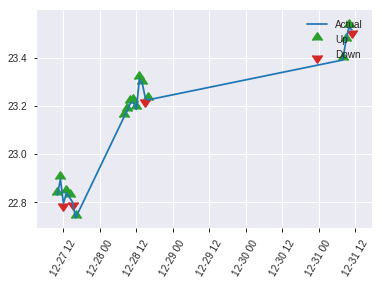


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19946319546751054
RMSE: 0.44661302653137036
LogLoss: 0.5875485904786064
Mean Per-Class Error: 0.27873563218390807
AUC: 0.7588669950738915
pr_auc: 0.707024904951951
Gini: 0.5177339901477831
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33088892698287964: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   54   0.4655   (54.0/116.0)
1      15   90   0.1429   (15.0/105.0)
Total  77   144  0.3122   (69.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330889     0.722892  143
max f2                       0.210677     0.827703  171
max f0point5                 0.526222     0.718816  91
max accuracy                 0.526222     0.723982  91
max precision                0.918876     1         0
max recall                   0.0880602    1         215
max specificity              0.918876     1         0
max absolute_mcc             0.526222     0.446478  91
max min_per_class_accuracy   0.458131     0.685714  106
max mean_per_class_accuracy  0.505092     0.721264  95

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.912084           2.10476   2.10476            1                0.917845  1                           0.917845            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.886119           0         1.26286            0                0.890856  0.6                         0.907049            0               0.0285714                  -100      26.2857
    3        0.0316742                   0.874697           2.10476   1.5034             1                0.880116  0.714286                    0.899354            0.0190476       0.047619                   110.476   50.3401
    4        0.040724                    0.867349           2.10476   1.63704            1                0.871318  0.777778                    0.893124            0.0190476       0.0666667                  110.476   63.7037
    5        0.0542986                   0.848631           2.10476   1.75397            1                0.859239  0.833333                    0.884653            0.0285714       0.0952381                  110.476   75.3968
    6        0.104072                    0.800795           1.72208   1.73872            0.818182         0.816503  0.826087                    0.852059            0.0857143       0.180952                   72.2078   73.8716
    7        0.153846                    0.750472           1.72208   1.73333            0.818182         0.769001  0.823529                    0.825187            0.0857143       0.266667                   72.2078   73.3333
    8        0.20362                     0.688496           0.95671   1.54349            0.454545         0.719232  0.733333                    0.799287            0.047619        0.314286                   -4.329    54.3492
    9        0.303167                    0.615024           1.53074   1.5393             0.727273         0.651506  0.731343                    0.750762            0.152381        0.466667                   53.0736   53.9303
    10       0.402715                    0.539309           1.53074   1.53719            0.727273         0.573493  0.730337                    0.706943            0.152381        0.619048                   53.0736   53.7186
    11       0.502262                    0.451029           0.861039  1.40317            0.409091         0.48611   0.666667                    0.663174            0.0857143       0.704762                   -13.8961  40.3175
    12       0.60181                     0.383159           0.861039  1.3135             0.409091         0.411412  0.62406                     0.621529            0.0857143       0.790476                   -13.8961  31.3498
    13       0.701357                    0.284955           0.95671   1.26286            0.454545         0.324481  0.6                         0.579368            0.0952381       0.885714                   -4.329    26.2857
    14       0.800905                    0.195685           0.478355  1.16535            0.227273         0.233801  0.553672                    0.536416            0.047619        0.933333                   -52.1645  16.5348
    15       0.900452                    0.134548           0.287013  1.06825            0.136364         0.164136  0.507538                    0.495259            0.0285714       0.961905                   -71.2987  6.8246
    16       1                           0.0557783          0.382684  1                  0.181818         0.100655  0.475113                    0.455977          

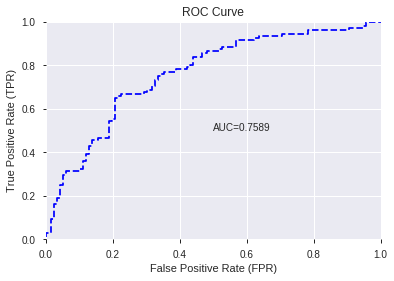

This function is available for GLM models only


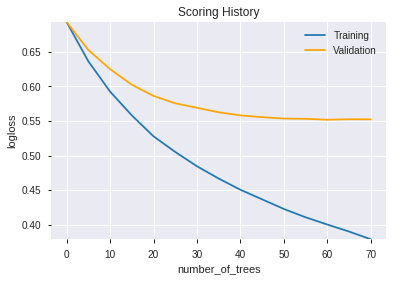

--2019-07-25 06:48:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

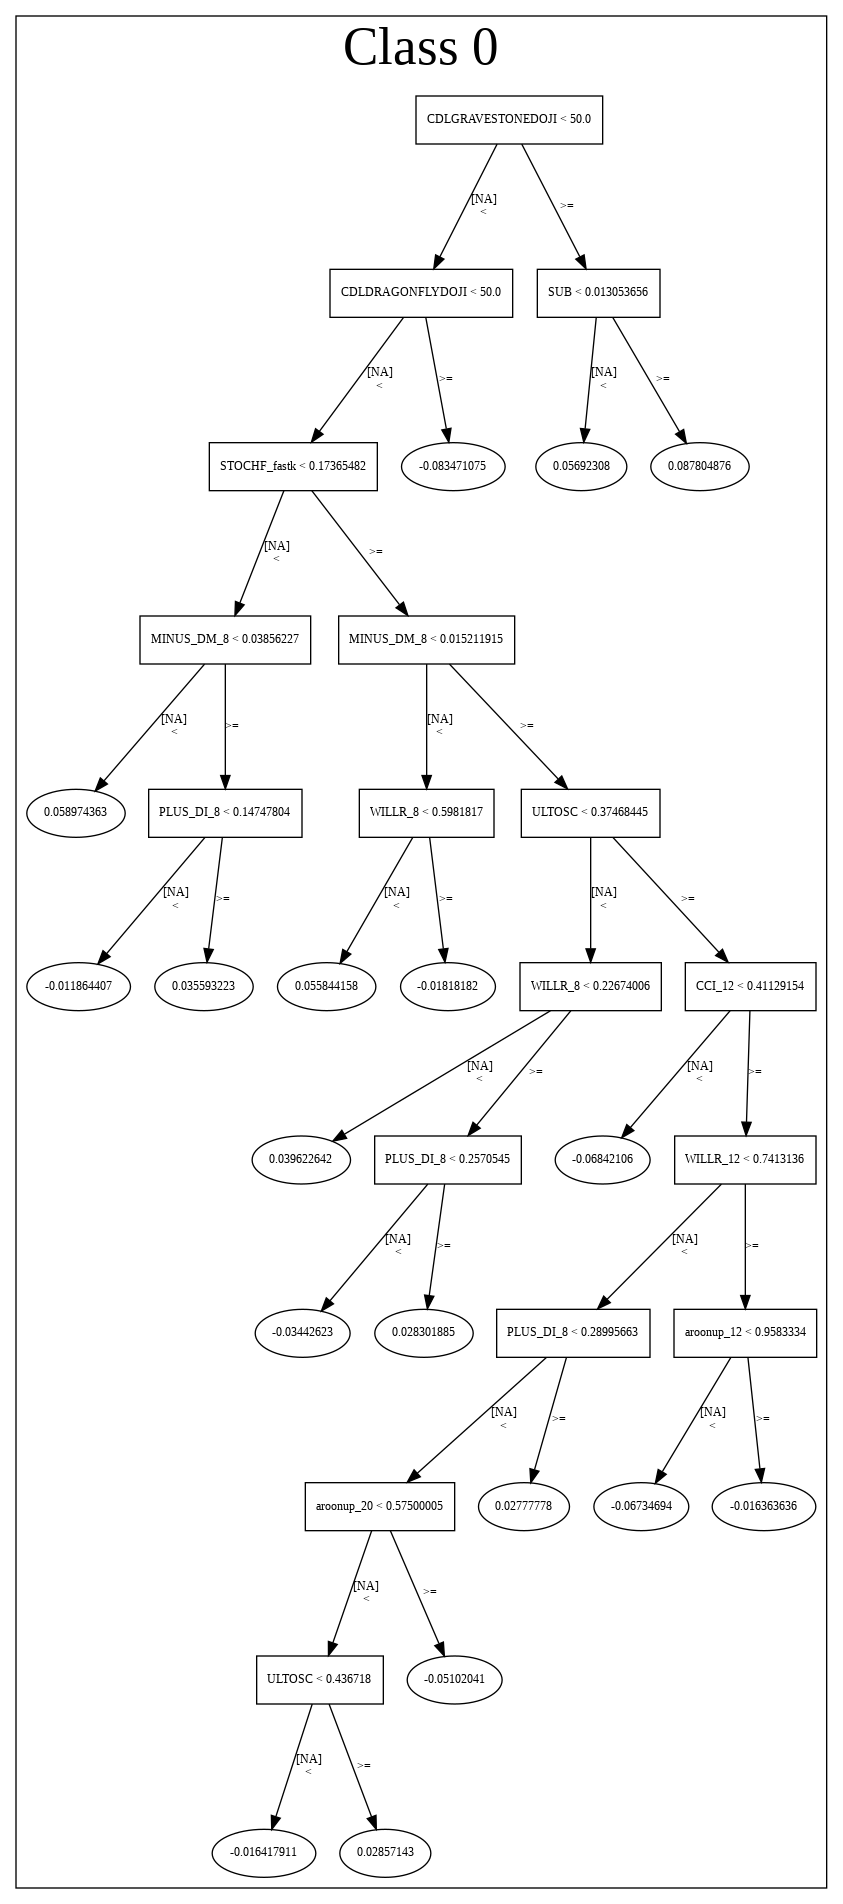

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190725_064825',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190725_064825',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_a71d',
   'type

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'DIV',
 'STOCHRSI_fastk',
 'ADOSC',
 'ULTOSC',
 'CCI_8',
 'STOCHRSI_fastd',
 'MINUS_DM_8',
 'MINUS_DI_8',
 'WILLR_8',
 'PLUS_DI_8',
 'SUB',
 'STOCH_slowk',
 'CDLCLOSINGMARUBOZU',
 'LINEARREG_ANGLE_8',
 'CDLLONGLINE',
 'CCI_14',
 'WILLR_30',
 'WILLR_12',
 'WILLR_14',
 'MOM_30',
 'CCI_12',
 'PLUS_DI_30',
 'MOM_24',
 'ROC_12',
 'WILLR_24',
 'PLUS_DI_24',
 'CCI_24',
 'MOM_20',
 'ROC_8',
 'CMO_30',
 'MOM_12',
 'CCI_30',
 'MINUS_DI_14',
 'CCI_20',
 'ROC_20',
 'CMO_8',
 'PLUS_DI_12',
 'MOM_8',
 'MOM_14',
 'WILLR_20',
 'MINUS_DI_12',
 'ROC_24',
 'PLUS_DI_20',
 'STOCHF_fastd',
 'ROC_14',
 'CMO_12',
 'PLUS_DI_14',
 'CMO_24',
 'LINEARREG_SLOPE_8',
 'ROCP_14',
 'ROCP_24',
 'ROC_30',
 'CMO_20',
 'ROCP_30',
 'CMO_14',
 'ROCP_8',
 'RSI_8',
 'RSI_24',
 'ROCP_20',
 'ROCP_12',
 'RSI_12',
 'ROCR100_20',
 'RSI_14',
 'RSI_30',
 'ROCR_30',
 'ROCR_20',
 'RSI_20',
 'ROCR_24',
 'ROCR100_30',
 'ROCR_12',
 'ROCR_8',
 'ROCR100_14',
 'ROCR100_12',
 'ROCR_14',
 'CDLBELTHOLD',
 '

In [0]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [0]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

64

['MAVP_20_1',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_upperband_20_5_5',
 'BBANDS_middleband_30_0_3',
 'BOP',
 'ADX_8',
 'AROONOSC_8',
 'CCI_8',
 'MFI_8',
 'MOM_8',
 'WILLR_8',
 'CMO_12',
 'MFI_12',
 'MOM_12',
 'ROCR100_12',
 'TRIX_12',
 'WILLR_12',
 'ADXR_14',
 'aroonup_14',
 'CMO_14',
 'DX_14',
 'PLUS_DM_14',
 'ROCR_14',
 'ROCR100_14',
 'WILLR_14',
 'MINUS_DI_20',
 'ROC_20',
 'ROCR100_20',
 'WILLR_20',
 'aroondown_24',
 'aroonup_24',
 'AROONOSC_24',
 'CCI_24',
 'MACDFIX_signal_24',
 'PLUS_DM_24',
 'ROCR_24',
 'AROONOSC_30',
 'CMO_30',
 'DX_30',
 'MFI_30',
 'MINUS_DI_30',
 'MINUS_DM_30',
 'MOM_30',
 'PLUS_DM_30',
 'ROC_30',
 'APO',
 'MACDEXT',
 'STOCHF_fastk',
 'ATR_8',
 'NATR_8',
 'TRANGE',
 'HT_DCPERIOD',
 'CDLLONGLINE',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'BETA_12',
 'LINEARREG_12',
 'LINEARREG_ANGLE_12',
 'LINEARREG_SLOPE_12',
 'BETA_14',
 'CORREL_14',
 'LINEARREG_ANGLE_14',
 'STDDEV_14',
 'VAR_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_064952_model_9  0.755255  0.588667              0.272660  0.446695  0.199536
1  DeepLearning_grid_1_AutoML_20190725_064952_model_8  0.746552  0.611844              0.286946  0.452685  0.204923
2  DeepLearning_grid_1_AutoML_20190725_064952_model_5  0.743760  0.642702              0.305090  0.459440  0.211085
3  DeepLearning_grid_1_AutoML_20190725_064952_model_4  0.736289  0.720887              0.295567  0.480724  0.231095
4  DeepLearning_grid_1_AutoML_20190725_064952_model_6  0.724877  0.630568              0.307594  0.460291  0.211868
5  DeepLearning_grid_1_AutoML_20190725_064952_model_3  0.724220  0.680522              0.330049  0.477340  0.227853
6  DeepLearning_grid_1_AutoML_20190725_064952_model_7  0.717241  0.713571              0.324589  0.486815  0.236989
7  DeepLearning_grid_1_AutoML_20190725_064952_model_2  0.696141  0.737098              0.310509  0.489224  0.239340
8  DeepLearning_grid_1_AutoML_20190725_064952_model_1  0.666256  0.860200              0.349343  0.531499  0.282492
9               DeepLearning_1_AutoML_20190725_064952  0.645649  0.693647              0.401519  0.493283  0.243329

variable  relative_importance  scaled_importance  percentage
0    CDLLONGLINE             1.000000           1.000000    0.064544
1         TRANGE             0.611488           0.611488    0.039468
2            BOP             0.549256           0.549256    0.035451
3          CCI_8             0.367018           0.367018    0.023689
4   STOCHF_fastk             0.341042           0.341042    0.022012
..           ...                  ...                ...         ...
59    PLUS_DM_14             0.183857           0.183857    0.011867
60       ROCR_24             0.183042           0.183042    0.011814
61        MOM_30             0.181320           0.181320    0.011703
62        CMO_12             0.177309           0.177309    0.011444
63       TRIX_12             0.177287           0.177287    0.011443

[64 rows x 4 columns]

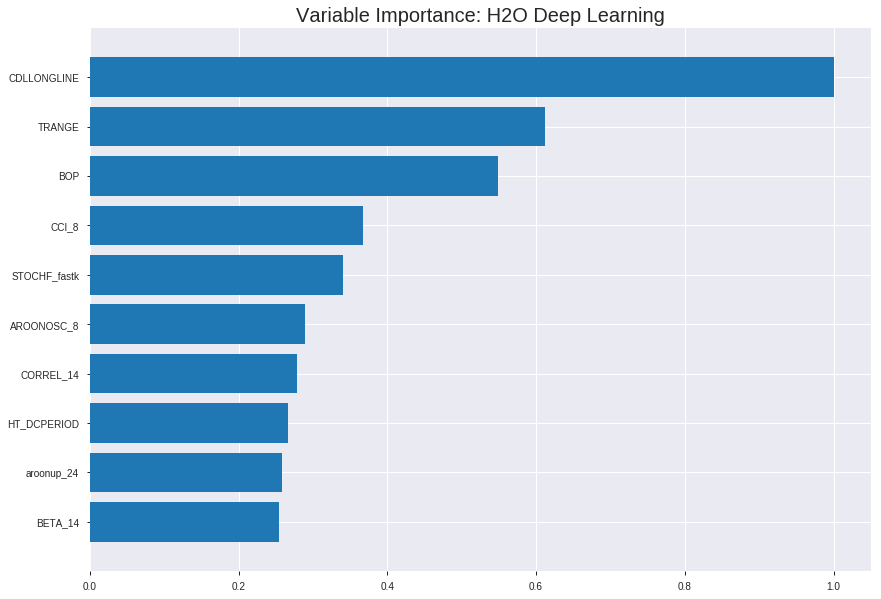

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_064952_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17890831616910324
RMSE: 0.422975550320705
LogLoss: 0.5346555818426786
Mean Per-Class Error: 0.2670425182053089
AUC: 0.8076630088257996
pr_auc: 0.7938066420902938
Gini: 0.6153260176515991
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35184507659037084: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      418  352   0.4571   (352.0/770.0)
1      86   688   0.1111   (86.0/774.0)
Total  504  1040  0.2837   (438.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351845     0.758545  263
max f2                       0.174685     0.853042  333
max f0point5                 0.559016     0.741538  168
max accuracy                 0.460247     0.733161  221
max precision                0.945438     1         0
max recall                   0.0559024    1         393
max specificity              0.945438     1         0
max absolute_mcc             0.456049     0.472232  223
max min_per_class_accuracy   0.509379     0.724806  196
max mean_per_class_accuracy  0.460247     0.732957  221

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 48.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.924908           1.99483   1.99483            1                0.930934   1                           0.930934            0.0206718       0.0206718                  99.4832   99.4832
    2        0.0200777                   0.91386            1.59587   1.80178            0.8              0.91977    0.903226                    0.925532            0.0155039       0.0361757                  59.5866   80.1784
    3        0.0304404                   0.905195           1.99483   1.8675             1                0.908835   0.93617                     0.919848            0.0206718       0.0568475                  99.4832   86.7502
    4        0.0401554                   0.899117           1.99483   1.89831            1                0.901849   0.951613                    0.915493            0.0193798       0.0762274                  99.4832   89.8308
    5        0.0505181                   0.89286            1.74548   1.86696            0.875            0.896266   0.935897                    0.911549            0.0180879       0.0943152                  74.5478   86.6958
    6        0.100389                    0.840582           1.60623   1.73743            0.805195         0.870008   0.870968                    0.890913            0.0801034       0.174419                   60.6228   73.7434
    7        0.150259                    0.79426            1.81348   1.76267            0.909091         0.815224   0.883621                    0.865792            0.0904393       0.264858                   81.3484   76.2675
    8        0.20013                     0.753545           1.47669   1.69141            0.74026          0.774289   0.847896                    0.84299             0.0736434       0.338501                   47.6694   69.1411
    9        0.29987                     0.65742            1.52851   1.63723            0.766234         0.708019   0.820734                    0.798097            0.152455        0.490956                   52.8508   63.7227
    10       0.400259                    0.55894            1.29986   1.55261            0.651613         0.604161   0.778317                    0.749456            0.130491        0.621447                   29.9858   55.2612
    11       0.5                         0.508108           1.04923   1.4522             0.525974         0.531615   0.727979                    0.706001            0.104651        0.726098                   4.92298   45.2196
    12       0.599741                    0.442471           1.01037   1.37872            0.506494         0.479666   0.691145                    0.66836             0.100775        0.826873                   1.03695   37.8718
    13       0.70013                     0.316564           0.797933  1.29544            0.4              0.38403    0.649399                    0.627591            0.0801034       0.906977                   -20.2067  29.5441
    14       0.79987                     0.189716           0.453371  1.19044            0.227273         0.246259   0.596761                    0.58004             0.0452196       0.952196                   -54.6629  19.0438
    15       0.899611                    0.113527           0.349743  1.09723            0.175325         0.145252   0.550036                    0.531835            0.0348837       0.98708                    -65.0257  9.72294
    16       1                           0.0381629          0.128699  1                  0.0645161        0.0837541  0.501295                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1961618421856752
RMSE: 0.44290161682440854
LogLoss: 0.5736060166905119
Mean Per-Class Error: 0.2941049026081215
AUC: 0.7691791845493562
pr_auc: 0.7384586254522392
Gini: 0.5383583690987124
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2660076265002789: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  118  0.5064   (118.0/233.0)
1      25   183  0.1202   (25.0/208.0)
Total  140  301  0.3243   (143.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.266008     0.719057  272
max f2                       0.124222     0.833333  352
max f0point5                 0.552549     0.705275  151
max accuracy                 0.552549     0.709751  151
max precision                0.93194      1         0
max recall                   0.0505101    1         394
max specificity              0.93194      1         0
max absolute_mcc             0.552549     0.419147  151
max min_per_class_accuracy   0.473998     0.695279  195
max mean_per_class_accuracy  0.48955      0.705895  183

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 45.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.91257            1.69615   1.69615            0.8              0.921032   0.8                         0.921032            0.0192308       0.0192308                  69.6154   69.6154
    2        0.0204082                   0.907715           2.12019   1.88462            1                0.911098   0.888889                    0.916617            0.0192308       0.0384615                  112.019   88.4615
    3        0.031746                    0.905734           2.12019   1.96875            1                0.906636   0.928571                    0.913052            0.0240385       0.0625                     112.019   96.875
    4        0.0408163                   0.899601           2.12019   2.0024             1                0.902903   0.944444                    0.910797            0.0192308       0.0817308                  112.019   100.24
    5        0.0521542                   0.891916           2.12019   2.02801            1                0.89526    0.956522                    0.907419            0.0240385       0.105769                   112.019   102.801
    6        0.102041                    0.805999           1.63833   1.8375             0.772727         0.848846   0.866667                    0.878784            0.0817308       0.1875                     63.833    83.75
    7        0.151927                    0.752519           1.63833   1.7721             0.772727         0.780352   0.835821                    0.846463            0.0817308       0.269231                   63.833    77.2101
    8        0.201814                    0.693863           1.44559   1.69139            0.681818         0.718054   0.797753                    0.814721            0.0721154       0.341346                   44.5586   69.1389
    9        0.301587                    0.605048           1.3974    1.59413            0.659091         0.640623   0.75188                     0.757125            0.139423        0.480769                   39.7399   59.413
    10       0.401361                    0.542973           1.25284   1.50929            0.590909         0.569944   0.711864                    0.710594            0.125           0.605769                   25.2841   50.9289
    11       0.501134                    0.463198           0.963724  1.40067            0.454545         0.500947   0.660633                    0.668854            0.0961538       0.701923                   -3.62762  40.067
    12       0.600907                    0.363769           0.915538  1.32012            0.431818         0.417124   0.622642                    0.627058            0.0913462       0.793269                   -8.44624  32.012
    13       0.70068                     0.252298           0.915538  1.26251            0.431818         0.302856   0.595469                    0.580893            0.0913462       0.884615                   -8.44624  26.2509
    14       0.800454                    0.179633           0.481862  1.1652             0.227273         0.212972   0.549575                    0.535033            0.0480769       0.932692                   -51.8138  16.5205
    15       0.900227                    0.110194           0.481862  1.08947            0.227273         0.144236   0.513854                    0.491721            0.0480769       0.980769                   -51.8138  8.94691
    16       1                           0.0450506          0.192745  1                  0.0909091        0.0743576  0.471655                    0.4500


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:58:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:58:17  2 min 44.080 sec  504 obs/sec       0.78044   1             1205       0.5414           0.968567            -0.172466      0.719658        0.703434           1.99483          0.376295                         0.550579           0.980098              -0.216457        0.724094          0.700525             2.12019            0.37415
    2019-07-25 06:58:30  2 min 56.635 sec  803 obs/sec       7.18264   9             11090      0.455315         0.602095            0.170749       0.76397         0.75235            1.74548          0.331606                         0.456057           0.603188              0.165364         0.762339          0.743399             2.12019            0.31746
    2019-07-25 06:58:42  3 min  9.030 sec  935 obs/sec       15.1522   19            23395      0.447383         0.58547             0.199387       0.770926        0.759957           1.99483          0.332902                         0.453614           0.597986              0.174286         0.751083          0.729655             1.69615            0.310658
    2019-07-25 06:58:54  3 min 21.010 sec  1031 obs/sec      23.9624   30            36998      0.443729         0.578465            0.212412       0.785057        0.771111           1.87016          0.292098                         0.446955           0.583859              0.19835          0.761245          0.742686             2.12019            0.344671
    2019-07-25 06:59:06  3 min 32.899 sec  1110 obs/sec      33.511    42            51741      0.435666         0.562743            0.240774       0.791847        0.778178           1.87016          0.298575                         0.445099           0.579009              0.204992         0.762752          0.743028             2.12019            0.346939
    2019-07-25 06:59:18  3 min 45.041 sec  1177 obs/sec      43.8627   55            67724      0.429845         0.549036            0.260927       0.800702        0.785584           1.87016          0.283679                         0.447575           0.588762              0.196122         0.766951          0.719271             1.27212            0.31746
    2019-07-25 06:59:31  3 min 57.668 sec  1232 obs/sec      55.0531   69            85002      0.422976         0.534656            0.284362       0.807663        0.793807           1.99483          0.283679                         0.442902           0.573606              0.212823         0.769179          0.738459             1.69615            0.324263

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
CDLLONGLINE   1.0                    1.0                  0.0645444098414231
TRANGE        0.6114881634712219     0.6114881634712219   0.03946814263626567
BOP           0.5492560267448425     0.5492560267448425   0.035451406098090756
CCI_8         0.36701837182044983    0.36701837182044983  0.02368898421011092
STOCHF_fastk  0.34104228019714355    0.34104228019714355  0.022012372706297884
---           ---                    ---                  ---
PLUS_DM_14    0.18385741114616394    0.18385741114616394  0.011866968097401035
ROCR_24       0.1830422580242157     0.1830422580242157   0.011814354520214492
MOM_30        0.1813203990459442     0.1813203990459442   0.011703218148631803
CMO_12        0.17730873823165894    0.17730873823165894  0.011444287868889798
TRIX_12       0.1772870570421219     0.1772870570421219   0.011442888469306469


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7239819004524887)

('F1', 0.7499999999999999)

('auc', 0.7552545155993432)

('logloss', 0.5886674741991051)

('mean_per_class_error', 0.27266009852216744)

('rmse', 0.446694813006289)

('mse', 0.1995362559667235)

deeplearning prediction progress: |███████████████████████████████████████| 100%


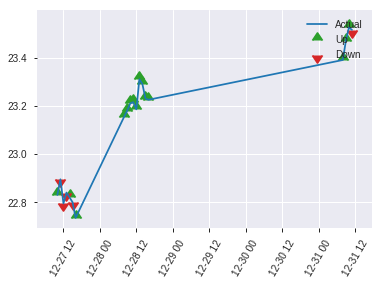


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1995362559667235
RMSE: 0.446694813006289
LogLoss: 0.5886674741991051
Mean Per-Class Error: 0.27266009852216744
AUC: 0.7552545155993432
pr_auc: 0.7156956748335485
Gini: 0.5105090311986864
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30827714630442205: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   50   0.431    (50.0/116.0)
1      12   93   0.1143   (12.0/105.0)
Total  78   143  0.2805   (62.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308277     0.75      142
max f2                       0.0669821    0.829384  212
max f0point5                 0.491938     0.708885  105
max accuracy                 0.491938     0.723982  105
max precision                0.929439     1         0
max recall                   0.0669821    1         212
max specificity              0.929439     1         0
max absolute_mcc             0.308277     0.475132  142
max min_per_class_accuracy   0.491938     0.714286  105
max mean_per_class_accuracy  0.308277     0.72734   142

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 46.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.919978           2.10476   2.10476            1                0.923992   1                           0.923992            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.918757           2.10476   2.10476            1                0.919024   1                           0.922005            0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.918183           1.05238   1.80408            0.5              0.918628   0.857143                    0.92104             0.00952381      0.0571429                  5.2381    80.4082
    4        0.040724                    0.912678           2.10476   1.8709             1                0.915938   0.888889                    0.919906            0.0190476       0.0761905                  110.476   87.0899
    5        0.0542986                   0.903411           2.10476   1.92937            1                0.909244   0.916667                    0.917241            0.0285714       0.104762                   110.476   92.9365
    6        0.104072                    0.791524           1.72208   1.83023            0.818182         0.835711   0.869565                    0.878248            0.0857143       0.190476                   72.2078   83.0228
    7        0.153846                    0.753658           1.53074   1.73333            0.727273         0.774505   0.823529                    0.844684            0.0761905       0.266667                   53.0736   73.3333
    8        0.20362                     0.716295           0.765368  1.49672            0.363636         0.732255   0.711111                    0.817202            0.0380952       0.304762                   -23.4632  49.672
    9        0.303167                    0.642331           1.43506   1.47647            0.681818         0.682422   0.701493                    0.772946            0.142857        0.447619                   43.5065   47.6475
    10       0.402715                    0.56277            1.24372   1.41894            0.590909         0.59272    0.674157                    0.728395            0.12381         0.571429                   24.3723   41.8941
    11       0.502262                    0.485259           1.53074   1.4411             0.727273         0.519267   0.684685                    0.686947            0.152381        0.72381                    53.0736   44.1098
    12       0.60181                     0.380407           1.05238   1.3768             0.5              0.431622   0.654135                    0.644712            0.104762        0.828571                   5.2381    37.6799
    13       0.701357                    0.259617           0.574026  1.26286            0.272727         0.309138   0.6                         0.597082            0.0571429       0.885714                   -42.5974  26.2857
    14       0.800905                    0.18115            0.287013  1.14157            0.136364         0.215232   0.542373                    0.549621            0.0285714       0.914286                   -71.2987  14.1566
    15       0.900452                    0.109436           0.382684  1.05767            0.181818         0.137424   0.502513                    0.504051            0.0380952       0.952381                   -61.7316  5.76693
    16       1                           0.0346879          0.478355  1                  0.227273         0.0698876  0.475113                    

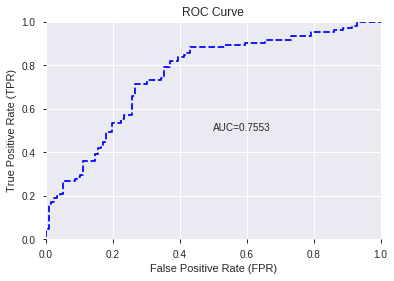

This function is available for GLM models only


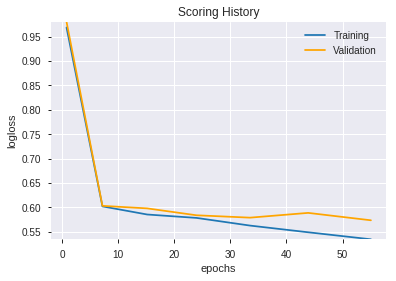

--2019-07-25 06:59:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


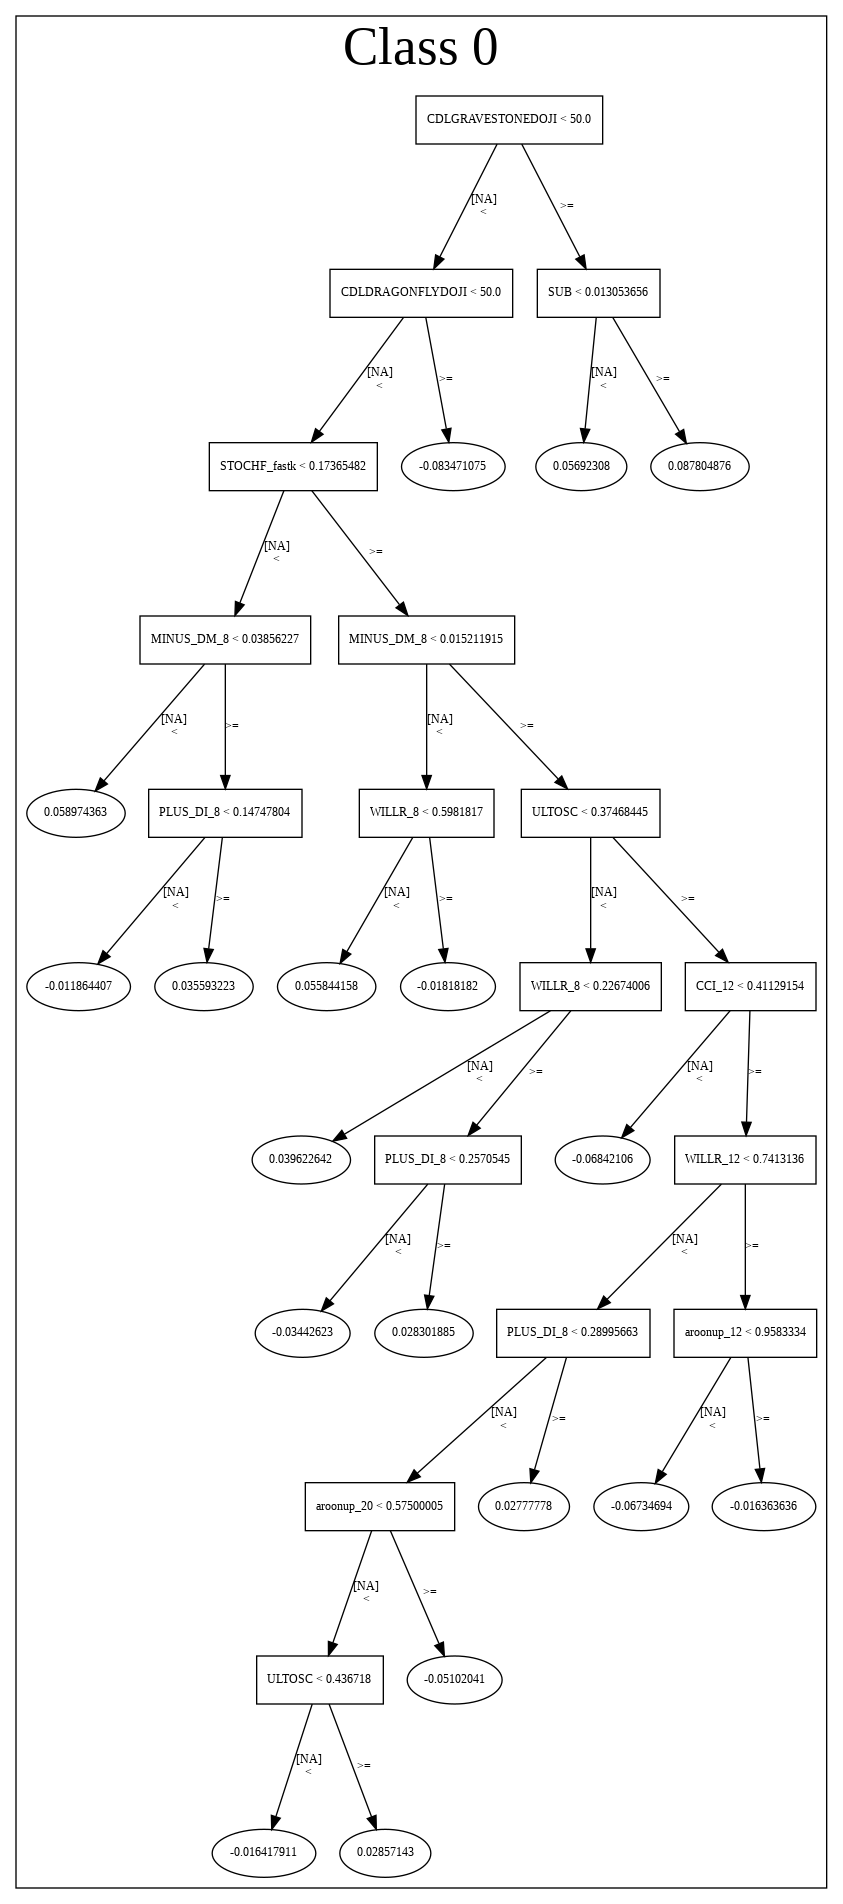

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_064952_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_064952_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLLONGLINE',
 'TRANGE',
 'BOP',
 'CCI_8',
 'STOCHF_fastk',
 'AROONOSC_8',
 'CORREL_14',
 'HT_DCPERIOD',
 'aroonup_24',
 'BETA_14',
 'VAR_8',
 'ADXR_14',
 'NATR_8',
 'MACDFIX_signal_24',
 'MFI_12',
 'MFI_8',
 'aroonup_14',
 'DX_30',
 'PLUS_DM_30',
 'ATR_8',
 'MFI_30',
 'ADX_8',
 'MAVP_20_1',
 'CMO_30',
 'DX_14',
 'BETA_12',
 'ROCR100_20',
 'WILLR_8',
 'MINUS_DI_30',
 'BBANDS_upperband_20_5_5',
 'BBANDS_middleband_30_0_3',
 'MINUS_DI_20',
 'VAR_14',
 'ROC_20',
 'AROONOSC_24',
 'WILLR_12',
 'WILLR_20',
 'aroondown_24',
 'MINUS_DM_30',
 'PLUS_DM_24',
 'MACDEXT',
 'APO',
 'BBANDS_lowerband_20_5_3',
 'LINEARREG_12',
 'LINEARREG_ANGLE_14',
 'ROCR100_14',
 'WILLR_14',
 'AROONOSC_30',
 'MOM_8',
 'LINEARREG_SLOPE_12',
 'ROCR_14',
 'LINEARREG_SLOPE_8',
 'STDDEV_14',
 'LINEARREG_ANGLE_12',
 'CMO_14',
 'MOM_12',
 'CCI_24',
 'ROC_30',
 'ROCR100_12',
 'PLUS_DM_14',
 'ROCR_24',
 'MOM_30',
 'CMO_12',
 'TRIX_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_070038_model_1  0.758456  0.60013              0.295115  0.453165  0.205359

variable  relative_importance  scaled_importance  percentage
0            BOP             0.514588           1.000000    0.103382
1          CCI_8             0.498273           0.968295    0.100104
2   STOCHF_fastk             0.361117           0.701759    0.072549
3         TRANGE             0.317657           0.617302    0.063818
4    CDLLONGLINE             0.307546           0.597654    0.061787
..           ...                  ...                ...         ...
59        ROC_20             0.011477           0.022304    0.002306
60    ROCR100_20             0.010027           0.019485    0.002014
61    aroonup_14             0.006915           0.013439    0.001389
62         DX_30             0.005586           0.010855    0.001122
63       BETA_12             0.000841           0.001633    0.000169

[64 rows x 4 columns]

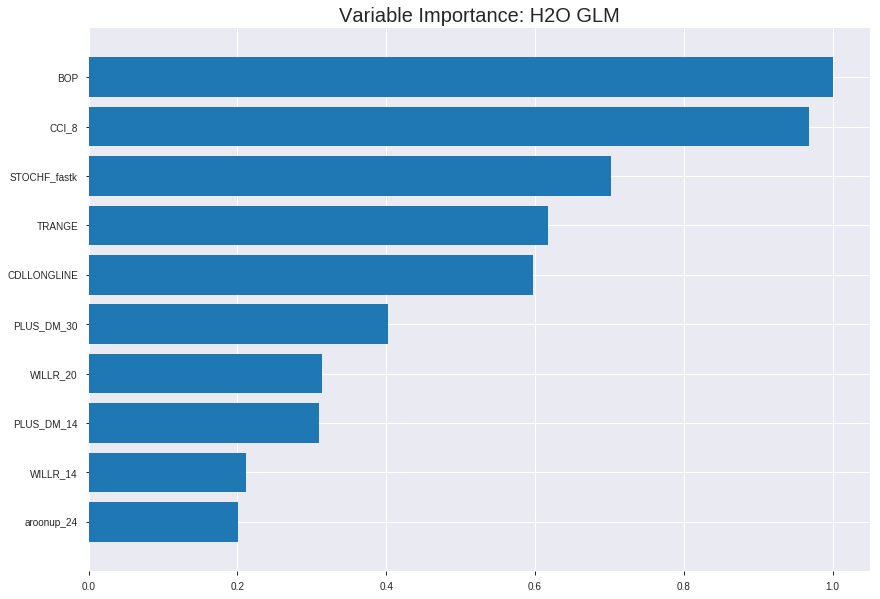

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_070038_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19522105368420997
RMSE: 0.4418382664326506
LogLoss: 0.5740543361223616
Null degrees of freedom: 1543
Residual degrees of freedom: 1479
Null deviance: 2140.428130863218
Residual deviance: 1772.6797899458525
AIC: 1902.6797899458525
AUC: 0.77069784220947
pr_auc: 0.7585552226210476
Gini: 0.54139568441894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3534119971113685: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      340  430   0.5584   (430.0/770.0)
1      72   702   0.093    (72.0/774.0)
Total  412  1132  0.3251   (502.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353412     0.736621  274
max f2                       0.265401     0.845135  315
max f0point5                 0.559911     0.708016  166
max accuracy                 0.514882     0.704016  193
max precision                0.926714     1         0
max recall                   0.071427     1         389
max specificity              0.926714     1         0
max absolute_mcc             0.514882     0.408223  193
max min_per_class_accuracy   0.526661     0.701299  187
max mean_per_class_accuracy  0.514882     0.703968  193

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.90008            1.99483   1.99483            1                0.911512  1                           0.911512            0.0206718       0.0206718                  99.4832   99.4832
    2        0.0200777                   0.883038           1.72885   1.86613            0.866667         0.891704  0.935484                    0.901928            0.0167959       0.0374677                  72.8854   86.6133
    3        0.0304404                   0.864757           1.49612   1.74017            0.75             0.872046  0.87234                     0.891755            0.0155039       0.0529716                  49.6124   74.0173
    4        0.0401554                   0.855795           1.99483   1.80178            1                0.860171  0.903226                    0.884114            0.0193798       0.0723514                  99.4832   80.1784
    5        0.0505181                   0.847834           1.49612   1.73908            0.75             0.851436  0.871795                    0.877411            0.0155039       0.0878553                  49.6124   73.9084
    6        0.100389                    0.784415           1.78758   1.76317            0.896104         0.816269  0.883871                    0.847037            0.0891473       0.177003                   78.7577   76.3174
    7        0.150259                    0.731888           1.60623   1.71108            0.805195         0.75329   0.857759                    0.815923            0.0801034       0.257106                   60.6228   71.1084
    8        0.20013                     0.69795            1.39897   1.63331            0.701299         0.715217  0.81877                     0.790828            0.0697674       0.326873                   39.8973   63.3309
    9        0.29987                     0.632793           1.37307   1.54675            0.688312         0.664334  0.775378                    0.748754            0.136951        0.463824                   37.3066   54.6749
    10       0.400259                    0.577055           1.22264   1.46546            0.612903         0.604984  0.734628                    0.712695            0.122739        0.586563                   22.2639   46.5459
    11       0.5                         0.526479           1.15286   1.4031             0.577922         0.550471  0.703368                    0.680335            0.114987        0.70155                    15.2857   40.3101
    12       0.599741                    0.456964           0.867881  1.31409            0.435065         0.492725  0.658747                    0.649134            0.0865633       0.788114                   -13.2119  31.409
    13       0.70013                     0.384732           0.900892  1.25484            0.451613         0.423529  0.629047                    0.616785            0.0904393       0.878553                   -9.91081  25.4843
    14       0.79987                     0.291337           0.608812  1.17429            0.305195         0.338484  0.588664                    0.582082            0.0607235       0.939276                   -39.1188  17.4286
    15       0.899611                    0.174913           0.349743  1.08287            0.175325         0.236723  0.542837                    0.543792            0.0348837       0.97416                    -65.0257  8.28678
    16       1                           0.0227866          0.257398  1                  0.129032         0.120472  0.501295                    0.501295          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1955792773903428
RMSE: 0.44224345940934257
LogLoss: 0.570672294158327
Null degrees of freedom: 440
Residual degrees of freedom: 376
Null deviance: 611.4883070433551
Residual deviance: 503.3329634476444
AIC: 633.3329634476444
AUC: 0.7708917959722681
pr_auc: 0.7502742565525119
Gini: 0.5417835919445362
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4234693933312802: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  118  0.5064   (118.0/233.0)
1      30   178  0.1442   (30.0/208.0)
Total  145  296  0.3356   (148.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423469     0.706349  265
max f2                       0.257051     0.843023  333
max f0point5                 0.601438     0.693807  151
max accuracy                 0.601438     0.70068   151
max precision                0.932087     1         0
max recall                   0.116596     1         378
max specificity              0.932087     1         0
max absolute_mcc             0.601438     0.400396  151
max min_per_class_accuracy   0.538845     0.690987  193
max mean_per_class_accuracy  0.518714     0.696115  209

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.896326           2.12019   2.12019            1                0.916059  1                           0.916059            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.87828            1.59014   1.88462            0.75             0.887267  0.888889                    0.903263            0.0144231       0.0384615                  59.0144   88.4615
    3        0.031746                    0.861509           2.12019   1.96875            1                0.86858   0.928571                    0.890876            0.0240385       0.0625                     112.019   96.875
    4        0.0408163                   0.854457           2.12019   2.0024             1                0.856754  0.944444                    0.883293            0.0192308       0.0817308                  112.019   100.24
    5        0.0521542                   0.84258            2.12019   2.02801            1                0.848207  0.956522                    0.875666            0.0240385       0.105769                   112.019   102.801
    6        0.102041                    0.794092           1.83108   1.93173            0.863636         0.814013  0.911111                    0.845524            0.0913462       0.197115                   83.1075   93.1731
    7        0.151927                    0.737102           1.63833   1.83539            0.772727         0.75738   0.865672                    0.816581            0.0817308       0.278846                   63.833    83.539
    8        0.201814                    0.696574           1.63833   1.78668            0.772727         0.711439  0.842697                    0.790591            0.0817308       0.360577                   63.833    78.6679
    9        0.301587                    0.640708           1.20465   1.59413            0.568182         0.665214  0.75188                     0.749113            0.120192        0.480769                   20.4655   59.413
    10       0.401361                    0.585848           1.25284   1.50929            0.590909         0.614054  0.711864                    0.715539            0.125           0.605769                   25.2841   50.9289
    11       0.501134                    0.533649           1.01191   1.41026            0.477273         0.558179  0.665158                    0.68421             0.100962        0.706731                   1.191     41.0264
    12       0.600907                    0.462104           0.915538  1.32812            0.431818         0.49976   0.626415                    0.653584            0.0913462       0.798077                   -8.44624  32.812
    13       0.70068                     0.406063           0.722793  1.24192            0.340909         0.433935  0.585761                    0.622307            0.0721154       0.870192                   -27.7207  24.1925
    14       0.800454                    0.302533           0.722793  1.17722            0.340909         0.345513  0.555241                    0.587806            0.0721154       0.942308                   -27.7207  17.7217
    15       0.900227                    0.173013           0.337303  1.08413            0.159091         0.241365  0.511335                    0.549409            0.0336538       0.975962                   -66.2697  8.41286
    16       1                           0.0344651          0.240931  1                  0.113636         0.115322  0.471655                    0.506099            0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 07:00:38  0.000 sec   2            .2E2      65            1.367608839458068   1.3724125562582588
     2019-07-25 07:00:38  0.015 sec   4            .12E2     65            1.3595762899138502  1.3658648761843926
     2019-07-25 07:00:38  0.032 sec   6            .76E1     65            1.3491965198671116  1.356828283239926
     2019-07-25 07:00:38  0.047 sec   8            .47E1     65            1.336054412029063   1.344471526603508
     2019-07-25 07:00:38  0.060 sec   10           .29E1     65            1.3197540216077124  1.327898446706133
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 07:00:38  0.231 sec   34           .97E-2    65            1.1444722854215073  1.1426309258782736
     2019-07-25 07:00:38  0.244 sec   36           .6E-2     65            1.1420338474363214  1.1444316874120872
     2019-07-25 07:00:38  0.265 sec   38           .37E-2    65            1.1402148409646164  1.148120199179815
     2019-07-25 07:00:38  0.283 sec   40           .23E-2    65            1.13892629847114    1.1526018302742558
     2019-07-25 07:00:38  0.299 sec   42           .14E-2    65            1.1380130976820622  1.1575379772538337


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7149321266968326)

('F1', 0.7309236947791165)

('auc', 0.7584564860426929)

('logloss', 0.6001301959031996)

('mean_per_class_error', 0.28624794745484405)

('rmse', 0.45316537666188744)

('mse', 0.2053588586051103)

glm prediction progress: |████████████████████████████████████████████████| 100%


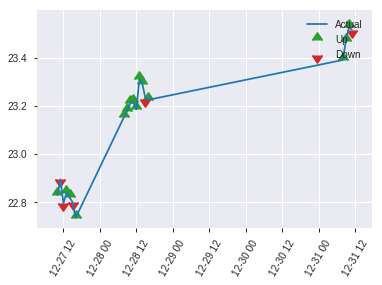


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2053588586051103
RMSE: 0.45316537666188744
LogLoss: 0.6001301959031996
Null degrees of freedom: 220
Residual degrees of freedom: 156
Null deviance: 306.4295320199308
Residual deviance: 265.2575465892142
AIC: 395.2575465892142
AUC: 0.7584564860426929
pr_auc: 0.7192265709174356
Gini: 0.5169129720853858
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4688472008190396: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   53   0.4569   (53.0/116.0)
1      14   91   0.1333   (14.0/105.0)
Total  77   144  0.3032   (67.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468847     0.730924  143
max f2                       0.0739778    0.824176  216
max f0point5                 0.599811     0.701754  101
max accuracy                 0.599811     0.714932  101
max precision                0.917851     1         0
max recall                   0.0739778    1         216
max specificity              0.917851     1         0
max absolute_mcc             0.524346     0.429733  122
max min_per_class_accuracy   0.574533     0.698276  108
max mean_per_class_accuracy  0.524346     0.713752  122

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 53.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.896181           2.10476   2.10476            1                0.906679  1                           0.906679            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.883644           2.10476   2.10476            1                0.888469  1                           0.899395            0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.867884           1.05238   1.80408            0.5              0.877576  0.857143                    0.893161            0.00952381      0.0571429                  5.2381    80.4082
    4        0.040724                    0.8497             2.10476   1.8709             1                0.860787  0.888889                    0.885967            0.0190476       0.0761905                  110.476   87.0899
    5        0.0542986                   0.836296           2.10476   1.92937            1                0.843366  0.916667                    0.875317            0.0285714       0.104762                   110.476   92.9365
    6        0.104072                    0.790481           1.53074   1.73872            0.727273         0.80861   0.826087                    0.843413            0.0761905       0.180952                   53.0736   73.8716
    7        0.153846                    0.755829           1.72208   1.73333            0.818182         0.771747  0.823529                    0.820227            0.0857143       0.266667                   72.2078   73.3333
    8        0.20362                     0.7361             1.33939   1.63704            0.636364         0.74606   0.777778                    0.802097            0.0666667       0.333333                   33.9394   63.7037
    9        0.303167                    0.68809            1.14805   1.47647            0.545455         0.711267  0.701493                    0.772272            0.114286        0.447619                   14.8052   47.6475
    10       0.402715                    0.644014           1.62641   1.51354            0.772727         0.663192  0.719101                    0.745309            0.161905        0.609524                   62.6407   51.3537
    11       0.502262                    0.571959           1.14805   1.4411             0.545455         0.604896  0.684685                    0.717479            0.114286        0.72381                    14.8052   44.1098
    12       0.60181                     0.513706           0.861039  1.34515            0.409091         0.53442   0.639098                    0.687199            0.0857143       0.809524                   -13.8961  34.5149
    13       0.701357                    0.438794           0.861039  1.27644            0.409091         0.471756  0.606452                    0.65662             0.0857143       0.895238                   -13.8961  27.6436
    14       0.800905                    0.327697           0.095671  1.12967            0.0454545        0.374081  0.536723                    0.621502            0.00952381      0.904762                   -90.4329  12.9674
    15       0.900452                    0.172325           0.478355  1.05767            0.227273         0.257088  0.502513                    0.581215            0.047619        0.952381                   -52.1645  5.76693
    16       1                           0.0262797          0.478355  1                  0.227273         0.118357  0.475113                    0.535139         

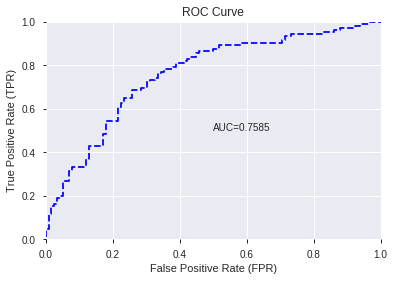

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


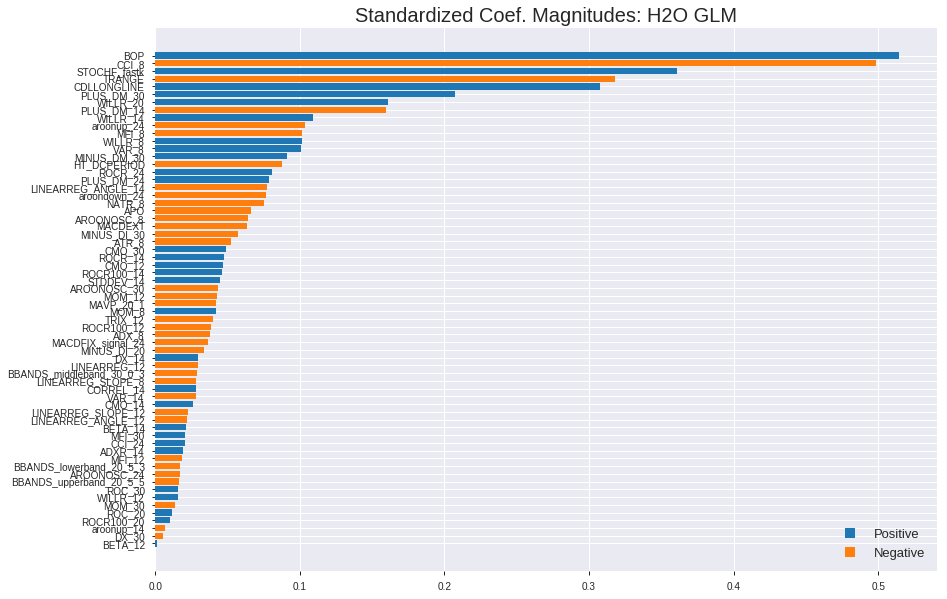

'log_likelihood'
--2019-07-25 07:00:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.16.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.16.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


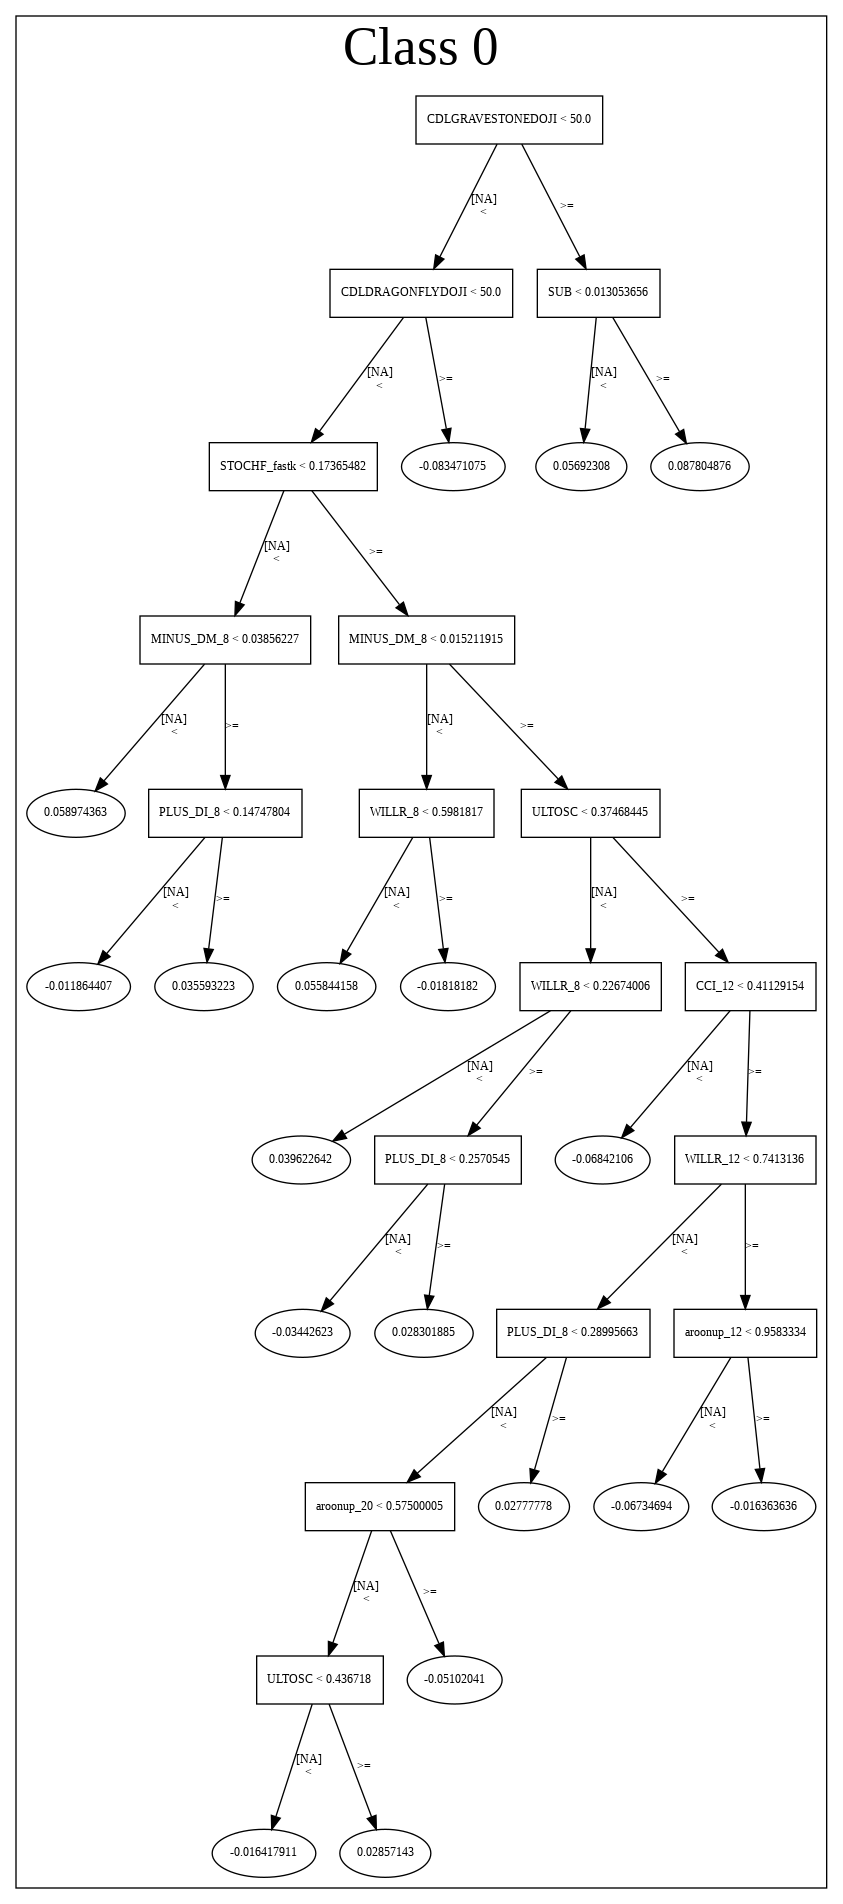

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_070038_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_070038_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CCI_8',
 'STOCHF_fastk',
 'TRANGE',
 'CDLLONGLINE',
 'PLUS_DM_30',
 'WILLR_20',
 'PLUS_DM_14',
 'WILLR_14',
 'aroonup_24',
 'MFI_8',
 'WILLR_8',
 'VAR_8',
 'MINUS_DM_30',
 'HT_DCPERIOD',
 'ROCR_24',
 'PLUS_DM_24',
 'LINEARREG_ANGLE_14',
 'aroondown_24',
 'NATR_8',
 'APO',
 'AROONOSC_8',
 'MACDEXT',
 'MINUS_DI_30',
 'ATR_8',
 'CMO_30',
 'ROCR_14',
 'CMO_12',
 'ROCR100_14',
 'STDDEV_14',
 'AROONOSC_30',
 'MOM_12',
 'MAVP_20_1',
 'MOM_8',
 'TRIX_12',
 'ROCR100_12',
 'ADX_8',
 'MACDFIX_signal_24',
 'MINUS_DI_20',
 'DX_14',
 'LINEARREG_12',
 'BBANDS_middleband_30_0_3',
 'LINEARREG_SLOPE_8',
 'CORREL_14',
 'VAR_14',
 'CMO_14',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'BETA_14',
 'MFI_30',
 'CCI_24',
 'ADXR_14',
 'MFI_12',
 'BBANDS_lowerband_20_5_3',
 'AROONOSC_24',
 'BBANDS_upperband_20_5_5',
 'ROC_30',
 'WILLR_12',
 'MOM_30',
 'ROC_20',
 'ROCR100_20',
 'aroonup_14',
 'DX_30',
 'BETA_12']

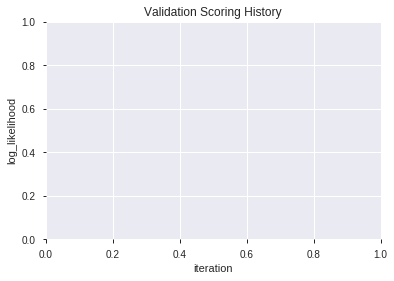

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_070145_model_6  0.742775  0.594873              0.290353  0.451149  0.203535
1               XGBoost_1_AutoML_20190725_070145  0.740722  0.604848              0.284442  0.454744  0.206792
2  XGBoost_grid_1_AutoML_20190725_070145_model_2  0.739655  0.600907              0.323235  0.453991  0.206108
3  XGBoost_grid_1_AutoML_20190725_070145_model_7  0.739163  0.605392              0.317118  0.455644  0.207612
4  XGBoost_grid_1_AutoML_20190725_070145_model_3  0.738998  0.601835              0.320525  0.454425  0.206502
5  XGBoost_grid_1_AutoML_20190725_070145_model_4  0.737274  0.604054              0.288300  0.455177  0.207186
6  XGBoost_grid_1_AutoML_20190725_070145_model_5  0.737192  0.615230              0.313259  0.458369  0.210102
7               XGBoost_2_AutoML_20190725_070145  0.734729  0.603466              0.298974  0.455234  0.207238
8               XGBoost_3_AutoML_20190725_070145  0.733826  0.609052              0.325287  0.457130  0.208968
9  XGBoost_grid_1_AutoML_20190725_070145_model_1  0.729475  0.613835              0.313259  0.459157  0.210825

variable  relative_importance  scaled_importance  percentage
0                  BOP          1838.599243           1.000000    0.166040
1               TRANGE           842.003662           0.457959    0.076040
2         STOCHF_fastk           734.069641           0.399255    0.066292
3                CCI_8           314.645782           0.171133    0.028415
4                MFI_8           255.478104           0.138953    0.023072
..                 ...                  ...                ...         ...
59          ROCR100_20            44.161125           0.024019    0.003988
60             MACDEXT            23.216845           0.012627    0.002097
61              VAR_14            21.026016           0.011436    0.001899
62          ROCR100_14            16.000383           0.008702    0.001445
63  LINEARREG_SLOPE_12             3.970711           0.002160    0.000359

[64 rows x 4 columns]

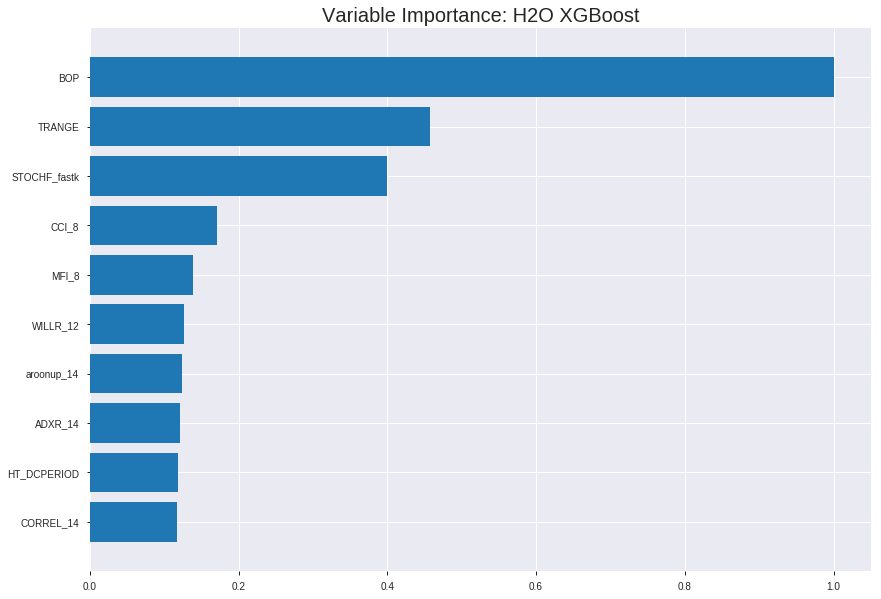

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_070145_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1186564851622872
RMSE: 0.34446550649127006
LogLoss: 0.39473617708764425
Mean Per-Class Error: 0.12566864659887922
AUC: 0.9476232423906843
pr_auc: 0.9467514185692422
Gini: 0.8952464847813686
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49982836097478867: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      647  123  0.1597   (123.0/770.0)
1      73   701  0.0943   (73.0/774.0)
Total  720  824  0.1269   (196.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499828     0.877347  205
max f2                       0.339637     0.914107  274
max f0point5                 0.589272     0.891266  162
max accuracy                 0.525734     0.874352  193
max precision                0.961375     1         0
max recall                   0.240144     1         315
max specificity              0.961375     1         0
max absolute_mcc             0.525734     0.748783  193
max min_per_class_accuracy   0.529068     0.871429  191
max mean_per_class_accuracy  0.525734     0.874331  193

Gains/Lift Table: Avg response rate: 50.13 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.932825           1.99483   1.99483            1                0.944812  1                           0.944812            0.0206718       0.0206718                  99.4832   99.4832
    2        0.0200777                   0.921739           1.99483   1.99483            1                0.927525  1                           0.936447            0.0193798       0.0400517                  99.4832   99.4832
    3        0.0304404                   0.90835            1.99483   1.99483            1                0.915442  1                           0.929297            0.0206718       0.0607235                  99.4832   99.4832
    4        0.0401554                   0.898571           1.99483   1.99483            1                0.90281   1                           0.922889            0.0193798       0.0801034                  99.4832   99.4832
    5        0.0505181                   0.886034           1.99483   1.99483            1                0.891356  1                           0.91642             0.0206718       0.100775                   99.4832   99.4832
    6        0.100389                    0.837754           1.99483   1.99483            1                0.863145  1                           0.889955            0.0994832       0.200258                   99.4832   99.4832
    7        0.150259                    0.788397           1.96893   1.98623            0.987013         0.814217  0.99569                     0.864818            0.0981912       0.29845                    96.8925   98.6234
    8        0.20013                     0.748341           1.91711   1.96901            0.961039         0.768347  0.987055                    0.840778            0.0956072       0.394057                   91.7111   96.9009
    9        0.29987                     0.673792           1.90416   1.94744            0.954545         0.712002  0.976242                    0.797945            0.189922        0.583979                   90.4158   94.7439
    10       0.400259                    0.6025             1.59587   1.85926            0.8              0.638851  0.932039                    0.758043            0.160207        0.744186                   59.5866   85.9261
    11       0.5                         0.529808           1.25649   1.73902            0.62987          0.564289  0.871762                    0.719393            0.125323        0.869509                   25.6485   73.9018
    12       0.599741                    0.434117           0.738347  1.5726             0.37013          0.483118  0.788337                    0.680099            0.0736434       0.943152                   -26.1653  57.26
    13       0.70013                     0.332653           0.424706  1.40801            0.212903         0.383109  0.705828                    0.637514            0.0426357       0.985788                   -57.5294  40.8008
    14       0.79987                     0.224476           0.142488  1.2502             0.0714286        0.281775  0.626721                    0.593155            0.0142119       1                          -85.7512  25.0202
    15       0.899611                    0.138808           0         1.11159            0                0.176422  0.557235                    0.546951            0               1                          -100      11.1591
    16       1                           0.0426295          0         1                  0                0.100683  0.501295                    0.502151           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1842493291381544
RMSE: 0.4292427391793068
LogLoss: 0.5443298573898858
Mean Per-Class Error: 0.2807857378672829
AUC: 0.7963539947177286
pr_auc: 0.7793756900550622
Gini: 0.5927079894354572
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31356605887413025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  112  0.4807   (112.0/233.0)
1      21   187  0.101    (21.0/208.0)
Total  142  299  0.3016   (133.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313566     0.737673  269
max f2                       0.241142     0.84537   310
max f0point5                 0.58541      0.712366  121
max accuracy                 0.509142     0.716553  164
max precision                0.93019      1         0
max recall                   0.12253      1         375
max specificity              0.93019      1         0
max absolute_mcc             0.366595     0.449676  244
max min_per_class_accuracy   0.447429     0.716346  189
max mean_per_class_accuracy  0.366595     0.719214  244

Gains/Lift Table: Avg response rate: 47.17 %, avg score: 44.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.918585           2.12019   2.12019            1                0.924337  1                           0.924337            0.0240385       0.0240385                  112.019   112.019
    2        0.0204082                   0.900199           2.12019   2.12019            1                0.91139   1                           0.918583            0.0192308       0.0432692                  112.019   112.019
    3        0.031746                    0.885087           2.12019   2.12019            1                0.892185  1                           0.909155            0.0240385       0.0673077                  112.019   112.019
    4        0.0408163                   0.852712           2.12019   2.12019            1                0.866961  1                           0.899778            0.0192308       0.0865385                  112.019   112.019
    5        0.0521542                   0.837897           2.12019   2.12019            1                0.843344  1                           0.88751             0.0240385       0.110577                   112.019   112.019
    6        0.102041                    0.760354           1.92745   2.02596            0.909091         0.792139  0.955556                    0.840884            0.0961538       0.206731                   92.7448   102.596
    7        0.151927                    0.690127           1.63833   1.89868            0.772727         0.72255   0.895522                    0.802028            0.0817308       0.288462                   63.833    89.868
    8        0.201814                    0.651385           1.15647   1.71521            0.545455         0.666686  0.808989                    0.768573            0.0576923       0.346154                   15.6469   71.5212
    9        0.301587                    0.585481           1.59014   1.67384            0.75             0.614094  0.789474                    0.717467            0.158654        0.504808                   59.0144   67.3836
    10       0.401361                    0.520198           1.01191   1.50929            0.477273         0.550202  0.711864                    0.675887            0.100962        0.605769                   1.191     50.9289
    11       0.501134                    0.438363           1.20465   1.44864            0.568182         0.477143  0.683258                    0.636318            0.120192        0.725962                   20.4655   44.8638
    12       0.600907                    0.375719           0.963724  1.36812            0.454545         0.400369  0.645283                    0.597142            0.0961538       0.822115                   -3.62762  36.8124
    13       0.70068                     0.286572           0.867351  1.29682            0.409091         0.333481  0.61165                     0.559598            0.0865385       0.908654                   -13.2649  29.6817
    14       0.800454                    0.231936           0.481862  1.19524            0.227273         0.258805  0.563739                    0.522105            0.0480769       0.956731                   -51.8138  19.5236
    15       0.900227                    0.156115           0.289117  1.09481            0.136364         0.193483  0.516373                    0.485683            0.0288462       0.985577                   -71.0883  9.48096
    16       1                           0.0627095          0.144559  1                  0.0681818        0.115497  0.471655                    0.448749          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:01:57  7.287 sec   0                  0.5              0.693147            0.5             0                  1                0.498705                         0.5                0.693147              0.5               0                    1                  0.528345
    2019-07-25 07:01:57  7.359 sec   5                  0.472671         0.639599            0.835108        0.805858           1.99483          0.268782                         0.480671           0.654994              0.76661           0.755466             2.12019            0.331066
    2019-07-25 07:01:57  7.403 sec   10                 0.450603         0.597174            0.854191        0.85153            1.99483          0.232513                         0.465118           0.624441              0.778155          0.759052             2.12019            0.287982
    2019-07-25 07:01:57  7.447 sec   15                 0.435281         0.567489            0.860185        0.857153           1.99483          0.239637                         0.454973           0.604292              0.785697          0.768726             2.12019            0.265306
    2019-07-25 07:01:57  7.492 sec   20                 0.422325         0.542009            0.867711        0.867046           1.99483          0.235751                         0.447647           0.589305              0.789369          0.774094             2.12019            0.272109
    2019-07-25 07:01:57  7.540 sec   25                 0.411043         0.519672            0.876635        0.875073           1.99483          0.218264                         0.442693           0.578537              0.78841           0.769503             2.12019            0.278912
    2019-07-25 07:01:57  7.589 sec   30                 0.402799         0.503457            0.886585        0.887748           1.99483          0.207902                         0.439144           0.570545              0.791392          0.770161             2.12019            0.281179
    2019-07-25 07:01:57  7.637 sec   35                 0.395859         0.489719            0.893907        0.895493           1.99483          0.204663                         0.437802           0.56698               0.790164          0.77085              2.12019            0.29932
    2019-07-25 07:01:57  7.689 sec   40                 0.389359         0.47684             0.901186        0.90217            1.99483          0.193005                         0.436661           0.563631              0.788905          0.76876              2.12019            0.294785
    2019-07-25 07:01:57  7.737 sec   45                 0.382651         0.463603            0.907854        0.90891            1.99483          0.184585                         0.435839           0.561246              0.787224          0.76628              2.12019            0.292517
    2019-07-25 07:01:57  7.784 sec   50                 0.377398         0.453607            0.913607        0.913047           1.99483          0.167746                         0.434687           0.558157              0.788266          0.767826             2.12019            0.285714
    2019-07-25 07:01:57  7.847 sec   55                 0.370534         0.441085            0.921425        0.92198            1.99483          0.161917                         0.433367           0.554779              0.789968          0.

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
BOP                 1838.5992431640625     1.0                   0.16604034363863437
TRANGE              842.003662109375       0.4579593216085323    0.07603972313239658
STOCHF_fastk        734.0696411132812      0.39925483698666925   0.06629241033265351
CCI_8               314.6457824707031      0.17113342325172845   0.028415052404772857
MFI_8               255.4781036376953      0.13895257739693218   0.023071733700460558
---                 ---                    ---                   ---
ROCR100_20          44.16112518310547      0.024018896639546188  0.00398810585185109
MACDEXT             23.21684455871582      0.012627463350176157  0.0020966683539475105
VAR_14              21.026016235351562     0.011435888660090873  0.0018988188829346506
ROCR100_14          16.000383377075195     0.008702485566968898  0.001444963694049772
LINEARREG_SLOPE_12  3.9707107543945312     0.002159639067163597  0.0003585872128472634


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7058823529411765)

('F1', 0.736)

('auc', 0.7427750410509032)

('logloss', 0.594873363448771)

('mean_per_class_error', 0.288752052545156)

('rmse', 0.45114896994182163)

('mse', 0.20353539307956667)

xgboost prediction progress: |████████████████████████████████████████████| 100%


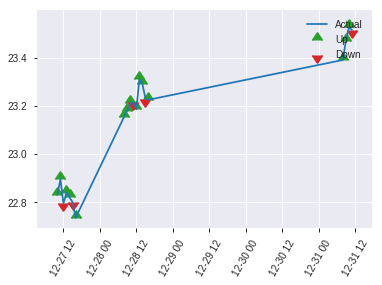


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20353539307956667
RMSE: 0.45114896994182163
LogLoss: 0.594873363448771
Mean Per-Class Error: 0.288752052545156
AUC: 0.7427750410509032
pr_auc: 0.7057318865322846
Gini: 0.4855500821018064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3586362302303314: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   53   0.4569   (53.0/116.0)
1      13   92   0.1238   (13.0/105.0)
Total  76   145  0.2986   (66.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358636     0.736     144
max f2                       0.164166     0.829228  188
max f0point5                 0.49932      0.680529  105
max accuracy                 0.416606     0.705882  131
max precision                0.936882     1         0
max recall                   0.055187     1         220
max specificity              0.936882     1         0
max absolute_mcc             0.358636     0.44081   144
max min_per_class_accuracy   0.49932      0.685714  105
max mean_per_class_accuracy  0.416606     0.711248  131

Gains/Lift Table: Avg response rate: 47.51 %, avg score: 46.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.918781           2.10476   2.10476            1                0.925878  1                           0.925878            0.0285714       0.0285714                  110.476   110.476
    2        0.0226244                   0.910359           2.10476   2.10476            1                0.915182  1                           0.921599            0.0190476       0.047619                   110.476   110.476
    3        0.0316742                   0.901174           1.05238   1.80408            0.5              0.905145  0.857143                    0.916898            0.00952381      0.0571429                  5.2381    80.4082
    4        0.040724                    0.887961           2.10476   1.8709             1                0.897999  0.888889                    0.912698            0.0190476       0.0761905                  110.476   87.0899
    5        0.0542986                   0.853452           2.10476   1.92937            1                0.874577  0.916667                    0.903168            0.0285714       0.104762                   110.476   92.9365
    6        0.104072                    0.796293           1.91342   1.92174            0.909091         0.822042  0.913043                    0.864369            0.0952381       0.2                        91.342    92.1739
    7        0.153846                    0.733785           0.95671   1.60952            0.454545         0.753158  0.764706                    0.828389            0.047619        0.247619                   -4.329    60.9524
    8        0.20362                     0.678772           1.33939   1.54349            0.636364         0.705569  0.733333                    0.798366            0.0666667       0.314286                   33.9394   54.3492
    9        0.303167                    0.620546           1.14805   1.41365            0.545455         0.641817  0.671642                    0.746962            0.114286        0.428571                   14.8052   41.3646
    10       0.402715                    0.550531           1.43506   1.41894            0.681818         0.578723  0.674157                    0.705375            0.142857        0.571429                   43.5065   41.8941
    11       0.502262                    0.47207            1.14805   1.36525            0.545455         0.51368   0.648649                    0.667381            0.114286        0.685714                   14.8052   36.5251
    12       0.60181                     0.416268           1.33939   1.36097            0.636364         0.446437  0.646617                    0.630834            0.133333        0.819048                   33.9394   36.0974
    13       0.701357                    0.311563           0.574026  1.24928            0.272727         0.359336  0.593548                    0.592299            0.0571429       0.87619                    -42.5974  24.9278
    14       0.800905                    0.198576           0.382684  1.14157            0.181818         0.244971  0.542373                    0.549128            0.0380952       0.914286                   -61.7316  14.1566
    15       0.900452                    0.129372           0.478355  1.06825            0.227273         0.163445  0.507538                    0.50649             0.047619        0.961905                   -52.1645  6.8246
    16       1                           0.055187           0.382684  1                  0.181818         0.103472  0.475113                    0.466371          

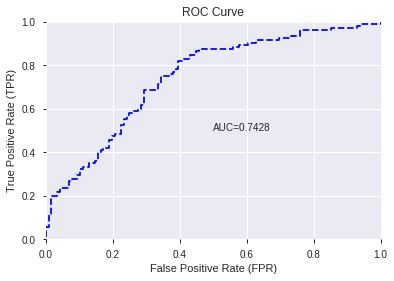

This function is available for GLM models only


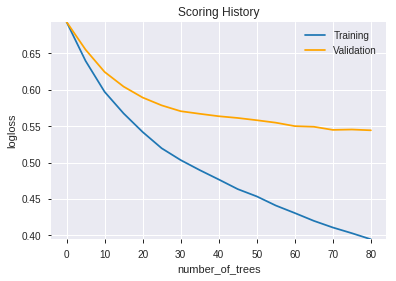

--2019-07-25 07:02:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

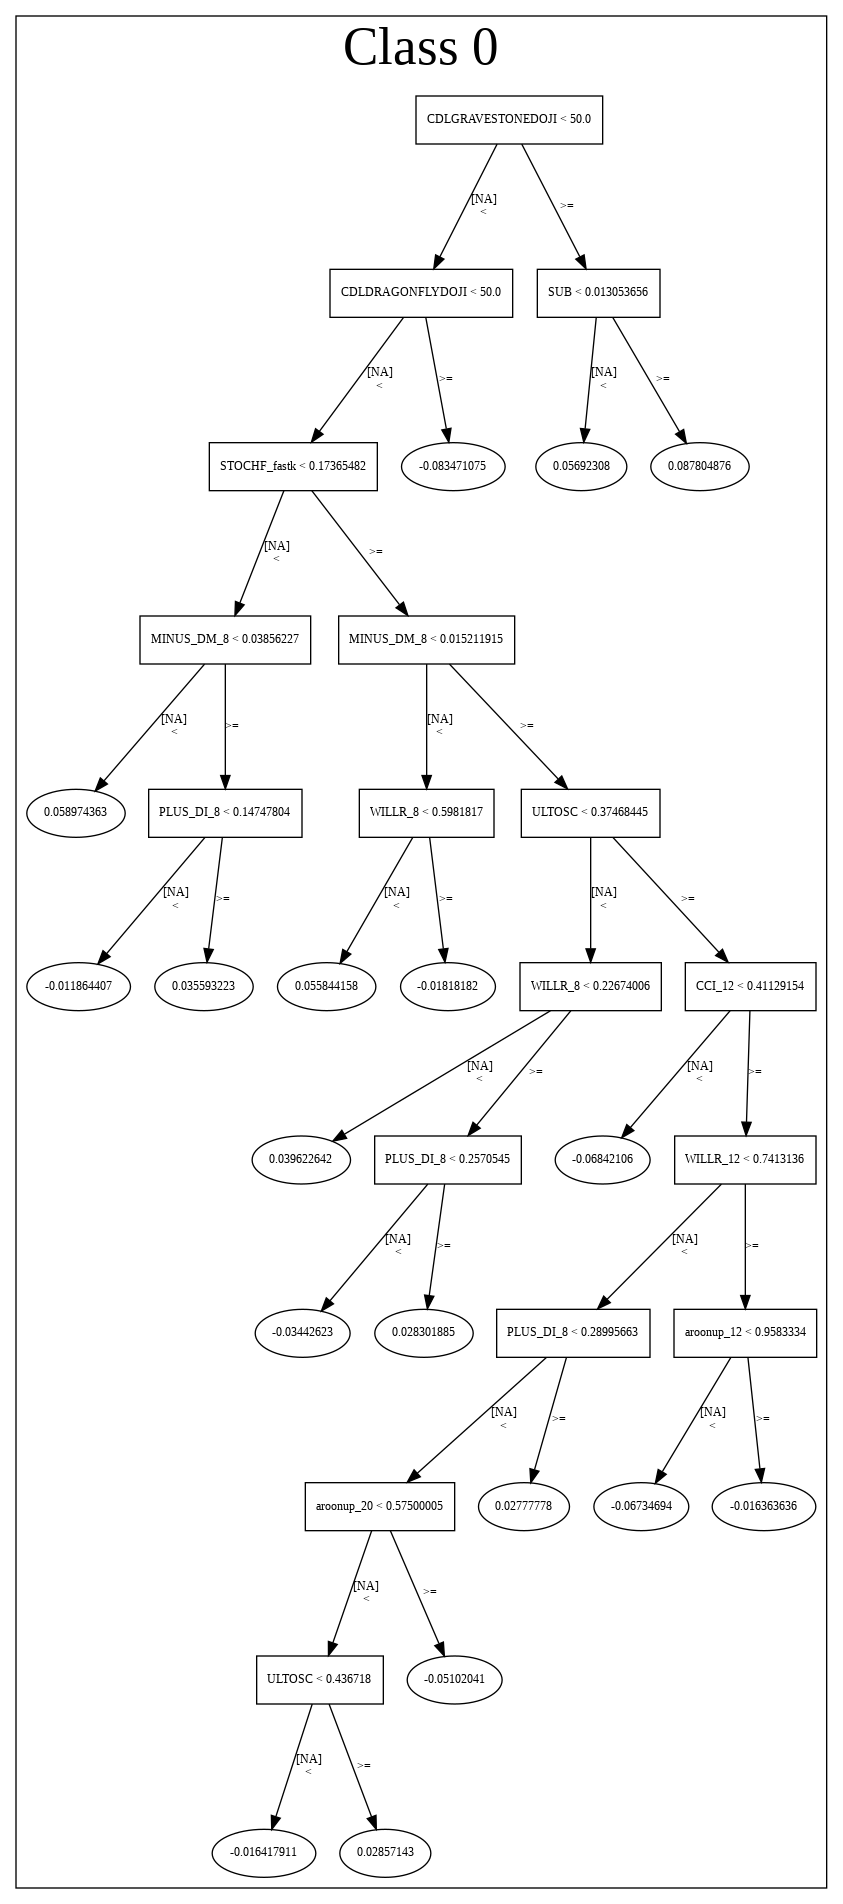

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_070145_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_070145_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a71d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_8',
 'MFI_8',
 'WILLR_12',
 'aroonup_14',
 'ADXR_14',
 'HT_DCPERIOD',
 'CORREL_14',
 'WILLR_8',
 'NATR_8',
 'MACDFIX_signal_24',
 'DX_14',
 'ATR_8',
 'DX_30',
 'ADX_8',
 'BBANDS_upperband_20_5_5',
 'BETA_14',
 'STDDEV_14',
 'BETA_12',
 'WILLR_14',
 'VAR_8',
 'ROC_20',
 'PLUS_DM_24',
 'MFI_30',
 'MFI_12',
 'WILLR_20',
 'AROONOSC_30',
 'ROCR_24',
 'MINUS_DM_30',
 'BBANDS_middleband_30_0_3',
 'CDLLONGLINE',
 'LINEARREG_12',
 'MAVP_20_1',
 'MINUS_DI_30',
 'LINEARREG_SLOPE_8',
 'ROCR100_12',
 'PLUS_DM_14',
 'CCI_24',
 'MOM_30',
 'LINEARREG_ANGLE_14',
 'APO',
 'LINEARREG_ANGLE_12',
 'aroondown_24',
 'PLUS_DM_30',
 'MOM_12',
 'CMO_30',
 'AROONOSC_24',
 'ROCR_14',
 'MINUS_DI_20',
 'AROONOSC_8',
 'MOM_8',
 'BBANDS_lowerband_20_5_3',
 'aroonup_24',
 'TRIX_12',
 'CMO_12',
 'ROC_30',
 'CMO_14',
 'ROCR100_20',
 'MACDEXT',
 'VAR_14',
 'ROCR100_14',
 'LINEARREG_SLOPE_12']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.724
GLM             0.719
XGBoost         0.742
dtype: float64

DeepLearning    GLM  XGBoost
All          0.715  0.706    0.701
DLF          0.719  0.710    0.742
Fwe          0.715  0.719    0.724
RFE          0.724  0.715    0.706
XGBF         0.706  0.710    0.742





F1


DeepLearning    0.750
GLM             0.737
XGBoost         0.736
dtype: float64

DeepLearning    GLM  XGBoost
All          0.718  0.737    0.723
DLF          0.727  0.726    0.720
Fwe          0.722  0.719    0.723
RFE          0.750  0.731    0.736
XGBF         0.724  0.726    0.720





auc


DeepLearning    0.769
GLM             0.766
XGBoost         0.769
dtype: float64

DeepLearning    GLM  XGBoost
All          0.758  0.748    0.751
DLF          0.762  0.755    0.769
Fwe          0.760  0.766    0.759
RFE          0.755  0.758    0.743
XGBF         0.769  0.755    0.769





logloss


DeepLearning    0.614
GLM             0.616
XGBoost         0.595
dtype: float64

DeepLearning    GLM  XGBoost
All          0.598  0.616    0.591
DLF          0.614  0.599    0.581
Fwe          0.590  0.597    0.588
RFE          0.589  0.600    0.595
XGBF         0.580  0.599    0.581





mean_per_class_error


DeepLearning    0.297
GLM             0.286
XGBoost         0.302
dtype: float64

DeepLearning    GLM  XGBoost
All          0.289  0.286    0.302
DLF          0.280  0.285    0.263
Fwe          0.289  0.281    0.279
RFE          0.273  0.286    0.289
XGBF         0.297  0.285    0.263





rmse


DeepLearning    0.457
GLM             0.458
XGBoost         0.451
dtype: float64

DeepLearning    GLM  XGBoost
All          0.453  0.458    0.450
DLF          0.457  0.451    0.443
Fwe          0.450  0.445    0.447
RFE          0.447  0.453    0.451
XGBF         0.444  0.451    0.443





mse


DeepLearning    0.208
GLM             0.210
XGBoost         0.204
dtype: float64

DeepLearning    GLM  XGBoost
All          0.205  0.210    0.202
DLF          0.208  0.203    0.196
Fwe          0.203  0.198    0.199
RFE          0.200  0.205    0.204
XGBF         0.197  0.203    0.196

{'F1':       DeepLearning    GLM  XGBoost
 All          0.718    NaN      NaN
 DLF          0.727    NaN      NaN
 DLF            NaN  0.726      NaN
 DLF            NaN    NaN    0.720
 All            NaN  0.737      NaN
 All            NaN    NaN    0.723
 XGBF         0.724    NaN      NaN
 XGBF           NaN  0.726      NaN
 XGBF           NaN    NaN    0.720
 Fwe          0.722    NaN      NaN
 Fwe            NaN  0.719      NaN
 Fwe            NaN    NaN    0.723
 RFE          0.750    NaN      NaN
 RFE            NaN  0.731      NaN
 RFE            NaN    NaN    0.736,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.715    NaN      NaN
 DLF          0.719    NaN      NaN
 DLF            NaN  0.710      NaN
 DLF            NaN    NaN    0.742
 All            NaN  0.706      NaN
 All            NaN    NaN    0.701
 XGBF         0.706    NaN      NaN
 XGBF           NaN  0.710      NaN
 XGBF           NaN    NaN    0.742
 Fwe          0.715    NaN      NaN
 Fwe     